### Naive Bayes

In [1]:
# Importando os módulos necessários para o processamento dos dados
import numpy   as np
import pandas  as pd

# Módulos necessários para visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importando os módulos auxiliares

from sklearn.model_selection import train_test_split # Divisão de conjunto de treinamento e teste
from sklearn.model_selection import cross_validate # Validação cruzada do modelo
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV # Busca pelos melhores hiperparâmetros
from sklearn.externals import joblib # Necessário para salvar os modelos treinados em arquivos externos
from imblearn.over_sampling import SMOTE # Balanceamento de classes
from sklearn.preprocessing import LabelEncoder

# Métricas de avaliação

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools

# Função auxiliar para plotar a matriz de confusão. 
# Retirada de: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    
def gerar_dataset_balanceado(train_data, 
                             train_target, 
                             test_data, 
                             test_target):
    
    sm = SMOTE(random_state=0, ratio='minority')
    
    encoders = list()
    
    for i in range(2): # Repete duas vezes o loop: um para o conjunto de treino e outro para o de teste
        if i == 0:
            data = train_data
            target = train_target
        elif i == 1:
            data = test_data
            target = test_target
    
        for feature in train_data.select_dtypes('object').columns:
            lb = LabelEncoder()

            lb.fit(data[feature])
            data[feature] = list(lb.transform(data[feature]))
            data[feature] = data[feature].astype('object')

            encoders.append(lb)

        data_b, target_b = sm.fit_sample(data, target)
    #     train_data_b = train_data_b.astype('int64')

    #     train_data_b = pd.DataFrame(train_data_b, columns=pd.get_dummies(train_data).columns)
        data_b = pd.DataFrame(data_b, columns=data.columns)
        data_b['earnings'] = target_b
        data_b = data_b.sample(frac=1) # Embaralha os registros

        target_b = data_b['earnings']
        data_b.drop(columns='earnings', inplace=True)

        for idx, feature in enumerate(data.select_dtypes('object').columns):

            data[feature] = encoders[idx].inverse_transform(list(data[feature]))

            data_b[feature] = data_b[feature].astype('int64')
            data_b[feature] = encoders[idx].inverse_transform(list(data_b[feature]))
        
        if i == 0:
            train_data_b = data_b
            train_target_b = target_b
        elif i == 1:
            test_data_b = data_b
            test_target_b = target_b
    
#     test_data_b, test_target_b = sm.fit_sample(pd.get_dummies(test_data), test_target)

#     test_data_b = pd.DataFrame(test_data_b, columns=pd.get_dummies(test_data).columns)
#     test_data_b['earnings'] = test_target_b
#     test_data_b = test_data_b.sample(frac=1) # Embaralha os registros
    
#     test_target_b = test_data_b['earnings']
#     test_data_b.drop(columns='earnings', inplace=True)
    
    return train_data_b, train_target_b, test_data_b, test_target_b

def exibir_resultados_finais(clf, 
                             test_data, 
                             test_target, 
                             id_abordagem, 
                             str_balanceamento, 
                             path_arquivos,
                             tipo_classificador,
                             fracao_dataset=0.1):
    
    # Classificando o conjunto de teste

    predicoes = clf.predict(test_data)

    if tipo_classificador == 'arvore':
    
        # Salvando a árvore treinada graficamente

        export_graphviz(clf, 
                        out_file=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.dot', 
                        feature_names=test_data.columns,  
                        class_names=['Less than or equal to', 'More than'],  
                        filled=True, rounded=True,  
                        special_characters=True)  

    # Avaliando o desempenho

    # Matriz de confusão

    cfs_mtx = confusion_matrix(test_target, predicoes)

    sns.set(font_scale=1.2)
    ax = sns.heatmap(cfs_mtx, 
                     xticklabels=['<=50K', '>50K'], 
                     yticklabels=['<=50K', '>50K'], 
                     annot=cfs_mtx,
                     fmt='d',
                     cbar=None)

    ax.set_xlabel('Predito', labelpad=20, fontsize=20)
    ax.set_ylabel('Real', labelpad=20, fontsize=20)
    ax.set_title('Matriz de Confusão')

    # plot_confusion_matrix(cfs_mtx, ['<=50K', '>50K'], normalize=False)
    plt.show()

    acc = accuracy_score(test_target, predicoes)
    pre = precision_score(test_target, predicoes)
    rec = recall_score(test_target, predicoes)
    roc_auc = roc_auc_score(test_target, predicoes)
    prc_auc = average_precision_score(test_target, predicoes)

    print('Acurácia: %.3f %%' % (acc*100))
    print('Precisão: %.3f %%' % (pre*100))
    print('Recall: %.3f %%' % (rec*100))
    print('ROC AUC: %.3f %%' % (roc_auc*100))
    print('PRC AUC: %.3f %%' % (prc_auc*100))

# ATENÇÃO!!! Escolher corretamente qual a fração do dataset que está sendo utilizada

fracao_dataset = 0.1

In [2]:
# Importando os arquivos com os datasets pré-processados

path_arquivos = 'Data/'

data_pre_proc_1 = pd.read_csv(path_arquivos+'data-pre-proc-1.csv')
data_pre_proc_2 = pd.read_csv(path_arquivos+'data-pre-proc-2.csv')
data_pre_proc_3 = pd.read_csv(path_arquivos+'data-pre-proc-3.csv')
data_pre_proc_4 = pd.read_csv(path_arquivos+'data-pre-proc-4.csv')

# Descartando a primeira coluna, que é só identificador do registro

data_pre_proc_1 = data_pre_proc_1.iloc[:,1::]
data_pre_proc_2 = data_pre_proc_2.iloc[:,1::]
data_pre_proc_3 = data_pre_proc_3.iloc[:,1::]
data_pre_proc_4 = data_pre_proc_4.iloc[:,1::]

# print(data_pre_proc_1.dtypes)

# lb = LabelEncoder()

# lb.fit(data_pre_proc_1['native-country'])

# aux = lb.fit_transform(data_pre_proc_1['native-country'])
# print(set(aux))

# Transformando as features numéricas em categóricas - necessário somente para o naive bayes

for i in range(4):
    if i == 0:
        data_pre_proc = data_pre_proc_1
    elif i == 1:
        data_pre_proc = data_pre_proc_2
    elif i == 2:
        data_pre_proc = data_pre_proc_3
    elif i == 3:
        data_pre_proc = data_pre_proc_4
        
    data_pre_proc_numeric = data_pre_proc.select_dtypes('float64')
#     print(data_pre_proc_numeric.dtypes)
    data_pre_proc = data_pre_proc.astype('object')
    data_pre_proc['earnings'] = data_pre_proc['earnings'].astype('int64')
#     print(data_pre_proc.dtypes)
#     print(data_pre_proc_numeric.dtypes)
    
    for feature in data_pre_proc_numeric.columns:
        if feature == 'age':
            
            linhas = data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 25)
            data_pre_proc.loc[linhas, feature] = 'young'
            
            linhas = (data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 50)) & (data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 25))
            data_pre_proc.loc[linhas, feature] = 'adult-young'
    
            linhas = (data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 50)) & (data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 75))
            data_pre_proc.loc[linhas, feature] = 'adult-senior'
            
            linhas = data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 75)
            data_pre_proc.loc[linhas, feature] = 'senior'
            
        elif feature == 'investment-status':
            
            # A feature está normalizada pelo z-score. Antes da normalização, valores negativos representam 'perdas', 
            # valores nulos representam 'sem ganho' e valores positivos representam 'lucros'. Como o z-score é uma
            # transformação linear, ela preserva a ordem dos valores. Sendo assim, olhei na distribuição original
            # (antes da aplicação do z-score), quais percentis estavam associados a valores negativos, nulos e positivos.
            # A partir daí, chegou-se aos valores de percentis mostrados abaixo.
            
            linhas = data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 5)
            data_pre_proc.loc[linhas, feature] = 'loss'
            
            linhas = (data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 5)) & (data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 93))
            data_pre_proc.loc[linhas, feature] = 'none'
            
            linhas = data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 93)
            data_pre_proc.loc[linhas, feature] = 'gain'
            
        else:
            
            if feature == 'fnlwgt':
                labels = ['low', 'medium', 'high']
            elif feature == 'hours-per-week':
                labels = ['few', 'moderate', 'plenty']
                
            linhas = data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 25)
            data_pre_proc.loc[linhas, feature] = labels[0]
            
            linhas = (data_pre_proc_numeric[feature] < np.percentile(data_pre_proc_numeric[feature], 75)) & (data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 25))
            data_pre_proc.loc[linhas, feature] = labels[1]
            
            linhas = data_pre_proc_numeric[feature] >= np.percentile(data_pre_proc_numeric[feature], 75)
            data_pre_proc.loc[linhas, feature] = labels[2]
            
    if i == 0:
        data_pre_proc_1 = data_pre_proc
    elif i == 1:
        data_pre_proc_2 = data_pre_proc
    elif i == 2:
        data_pre_proc_3 = data_pre_proc
    elif i == 3:
        data_pre_proc_4 = data_pre_proc

# Separando o target e dividindo os conjuntos de treino e teste para cada dataset

# Dataset 1

target_1 = data_pre_proc_1['earnings']
data_pre_proc_1.drop(columns='earnings', inplace=True)

train_data_1, test_data_1, train_target_1, test_target_1 = train_test_split(
    data_pre_proc_1, target_1, test_size=0.33, random_state=0)

train_data_b_1, train_target_b_1, test_data_b_1, test_target_b_1 = gerar_dataset_balanceado(
    train_data_1, train_target_1, test_data_1, test_target_1)

# Dataset 2

target_2 = data_pre_proc_2['earnings']
data_pre_proc_2.drop(columns='earnings', inplace=True)

train_data_2, test_data_2, train_target_2, test_target_2 = train_test_split(
    data_pre_proc_2, target_2, test_size=0.33, random_state=0)

train_data_b_2, train_target_b_2, test_data_b_2, test_target_b_2 = gerar_dataset_balanceado(
    train_data_2, train_target_2, test_data_2, test_target_2)
    
# Dataset 3
    
target_3 = data_pre_proc_3['earnings']
data_pre_proc_3.drop(columns='earnings', inplace=True)

train_data_3, test_data_3, train_target_3, test_target_3 = train_test_split(
    data_pre_proc_3, target_3, test_size=0.33, random_state=0)

train_data_b_3, train_target_b_3, test_data_b_3, test_target_b_3 = gerar_dataset_balanceado(
    train_data_3, train_target_3, test_data_3, test_target_3)
    
# Dataset 4    

target_4 = data_pre_proc_4['earnings']
data_pre_proc_4.drop(columns='earnings', inplace=True)

train_data_4, test_data_4, train_target_4, test_target_4 = train_test_split(
    data_pre_proc_4, target_4, test_size=0.33, random_state=0)

train_data_b_4, train_target_b_4, test_data_b_4, test_target_b_4 = gerar_dataset_balanceado(
    train_data_4, train_target_4, test_data_4, test_target_4)

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that a

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that a

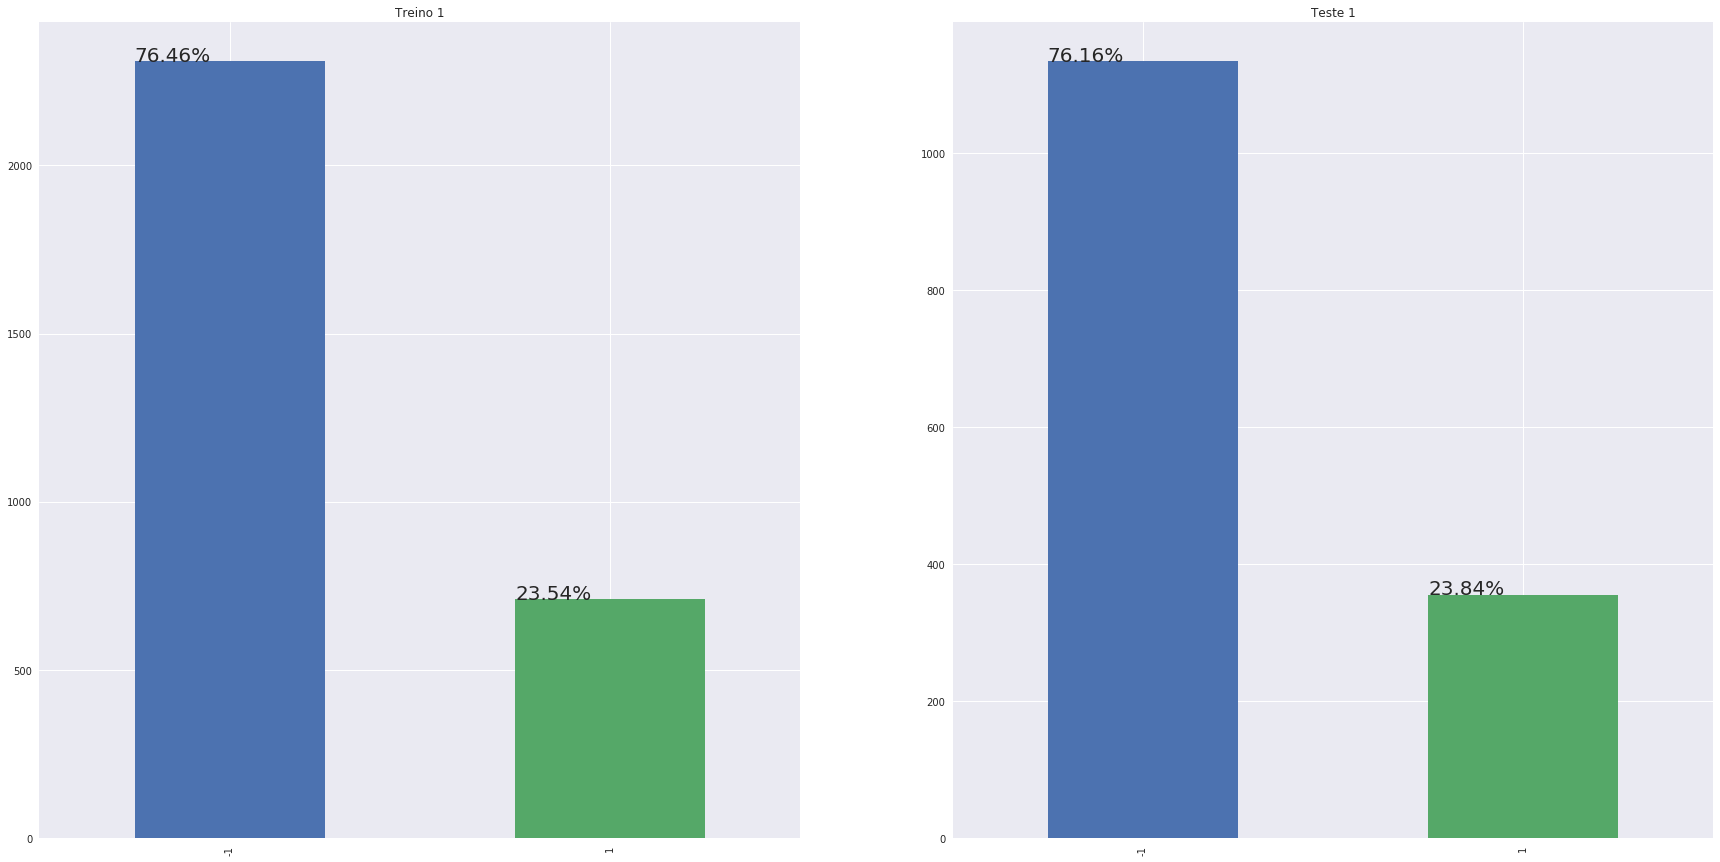

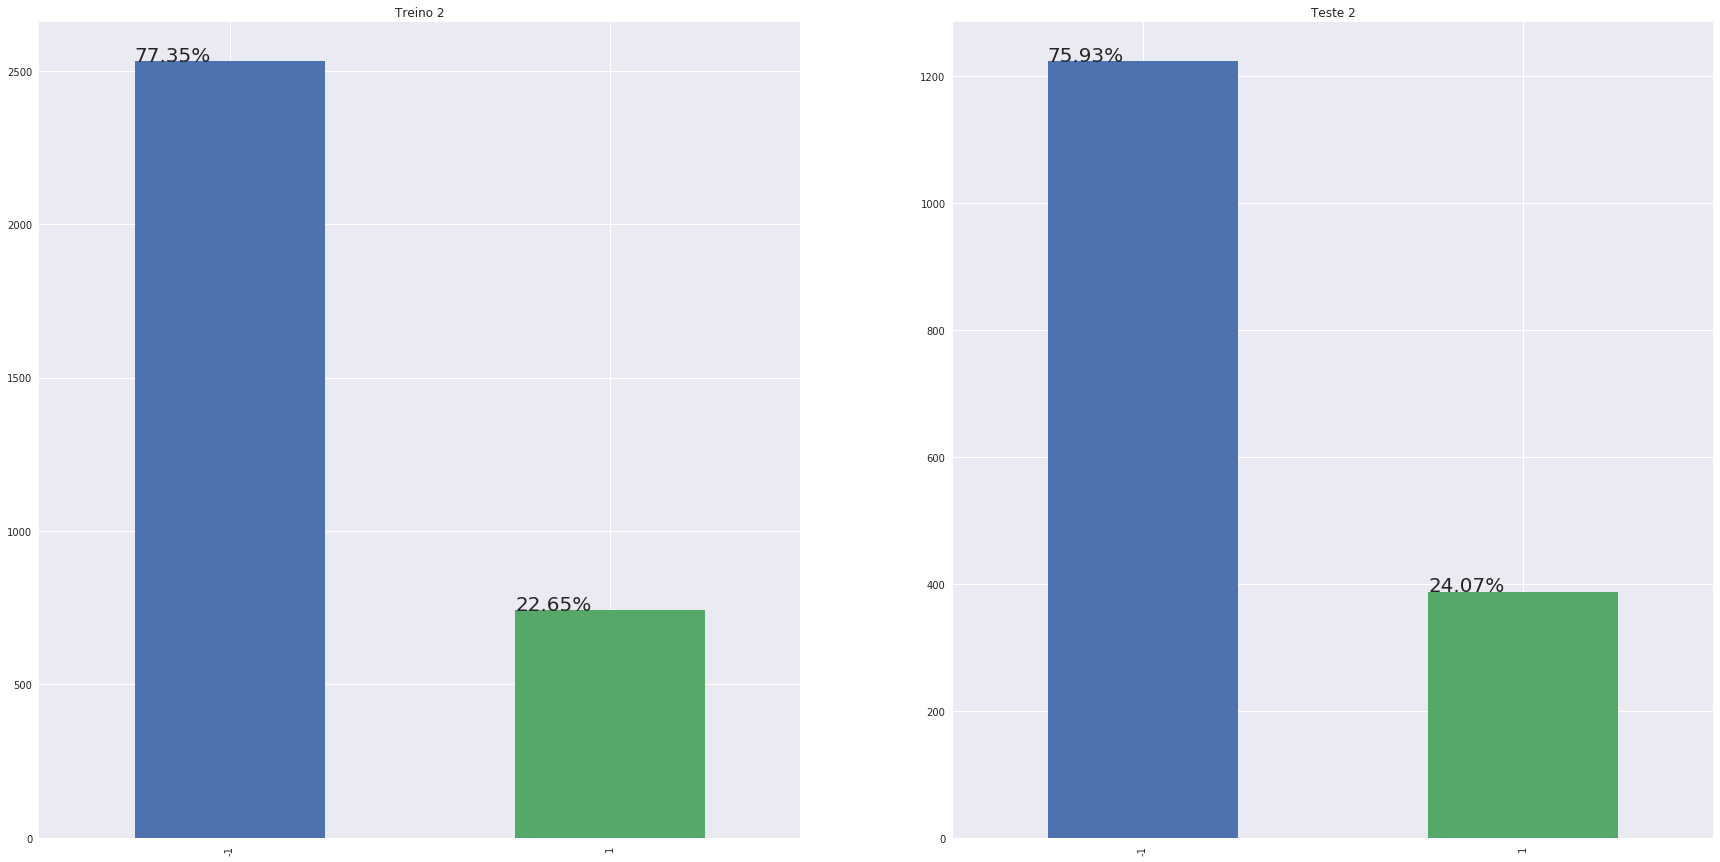

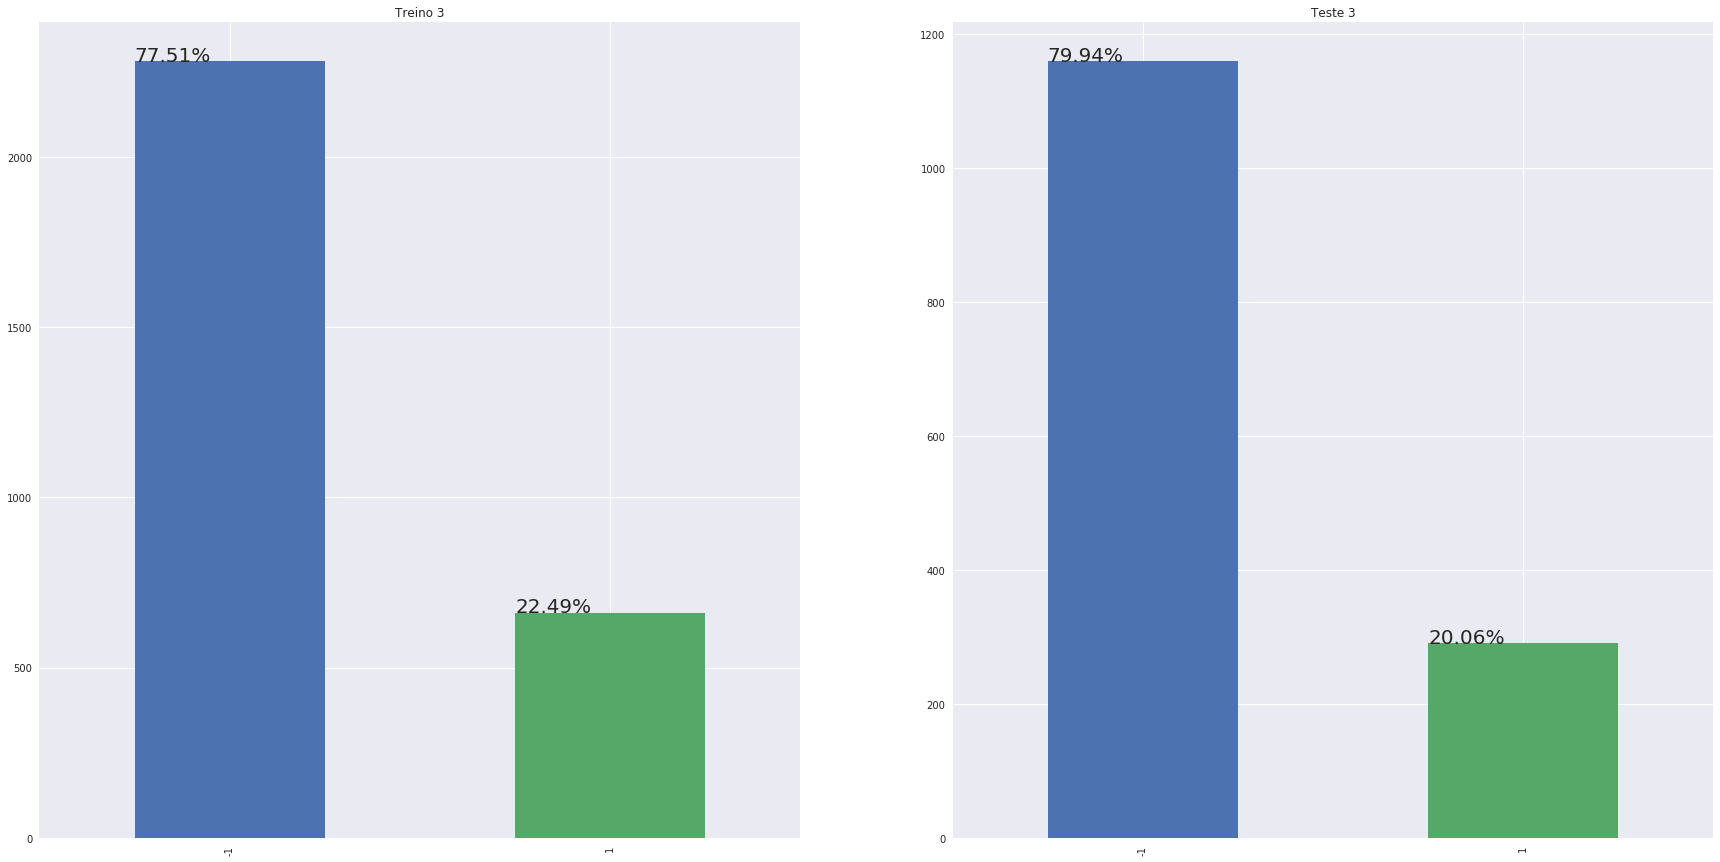

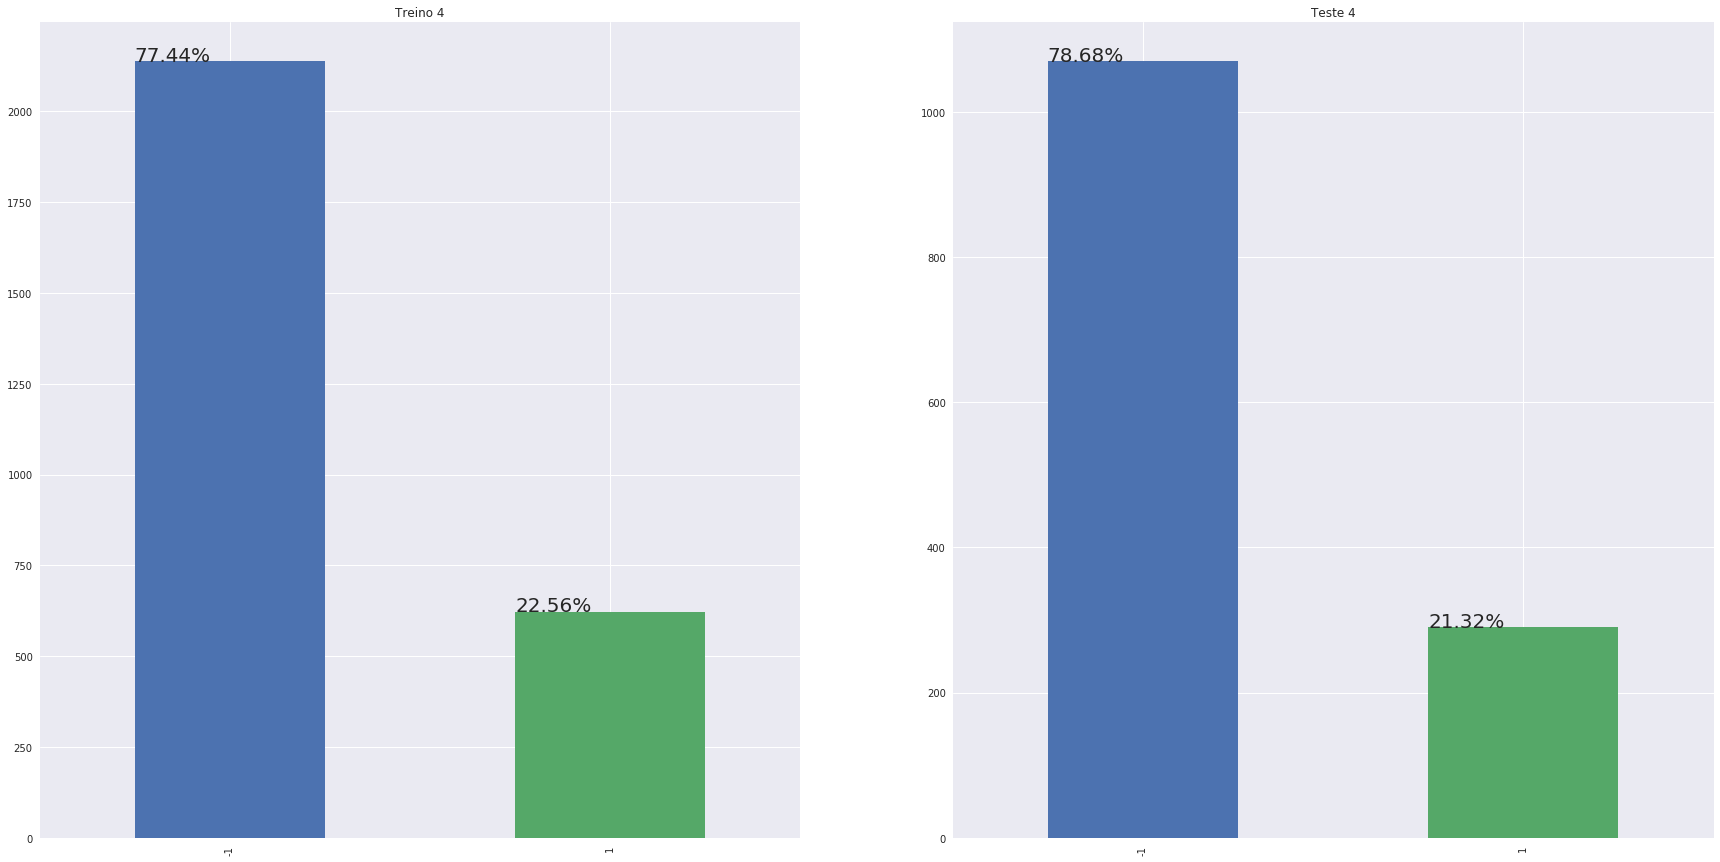

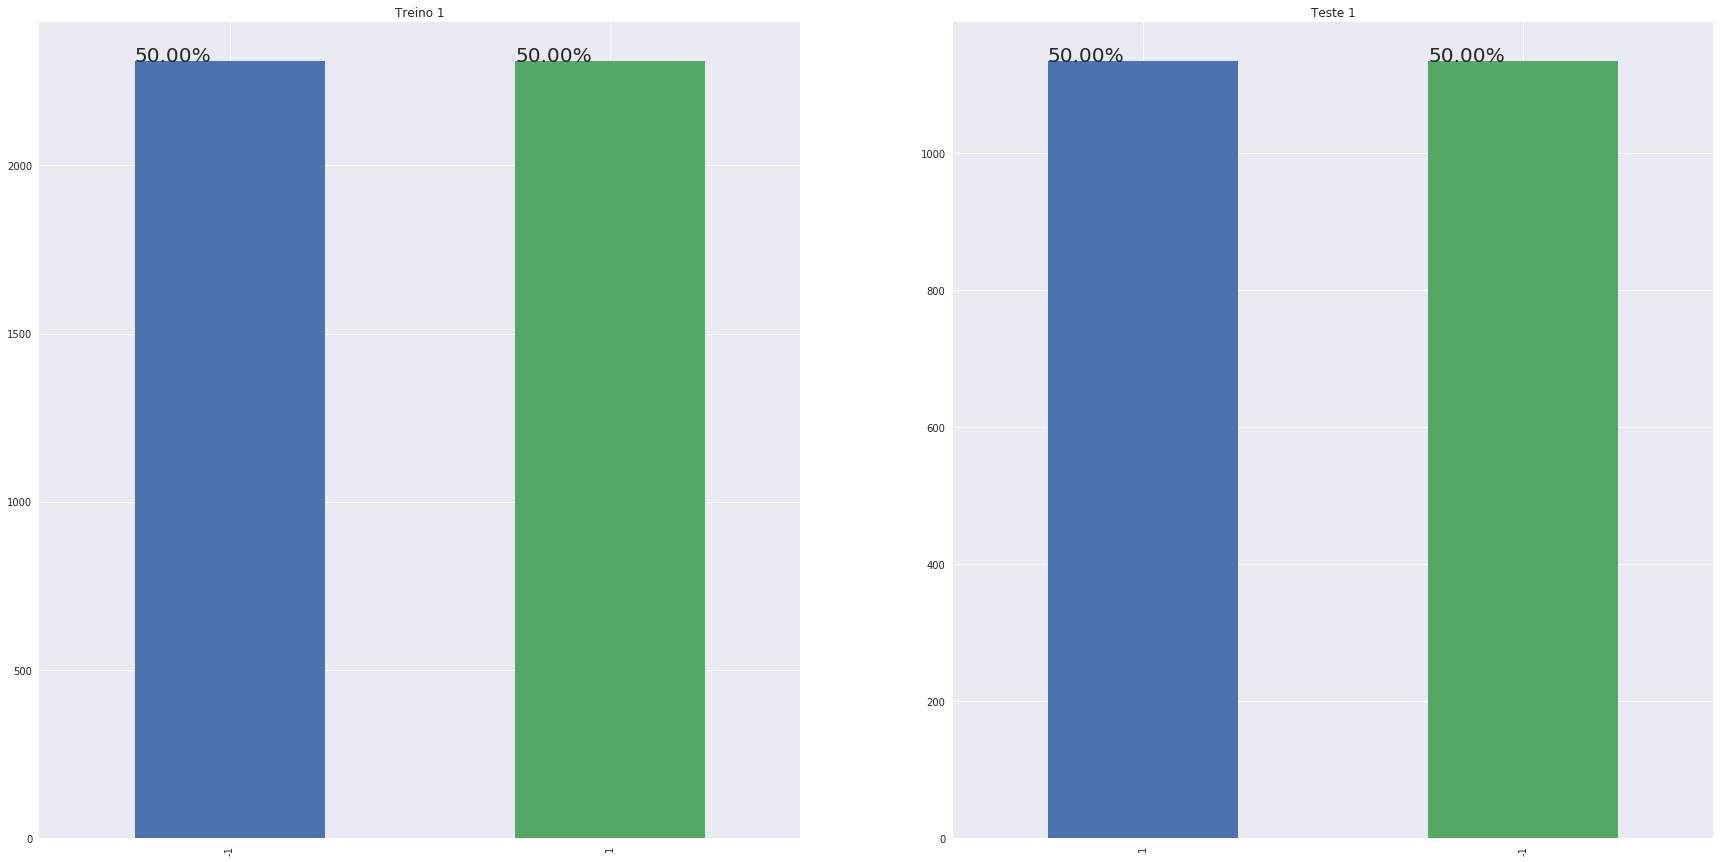

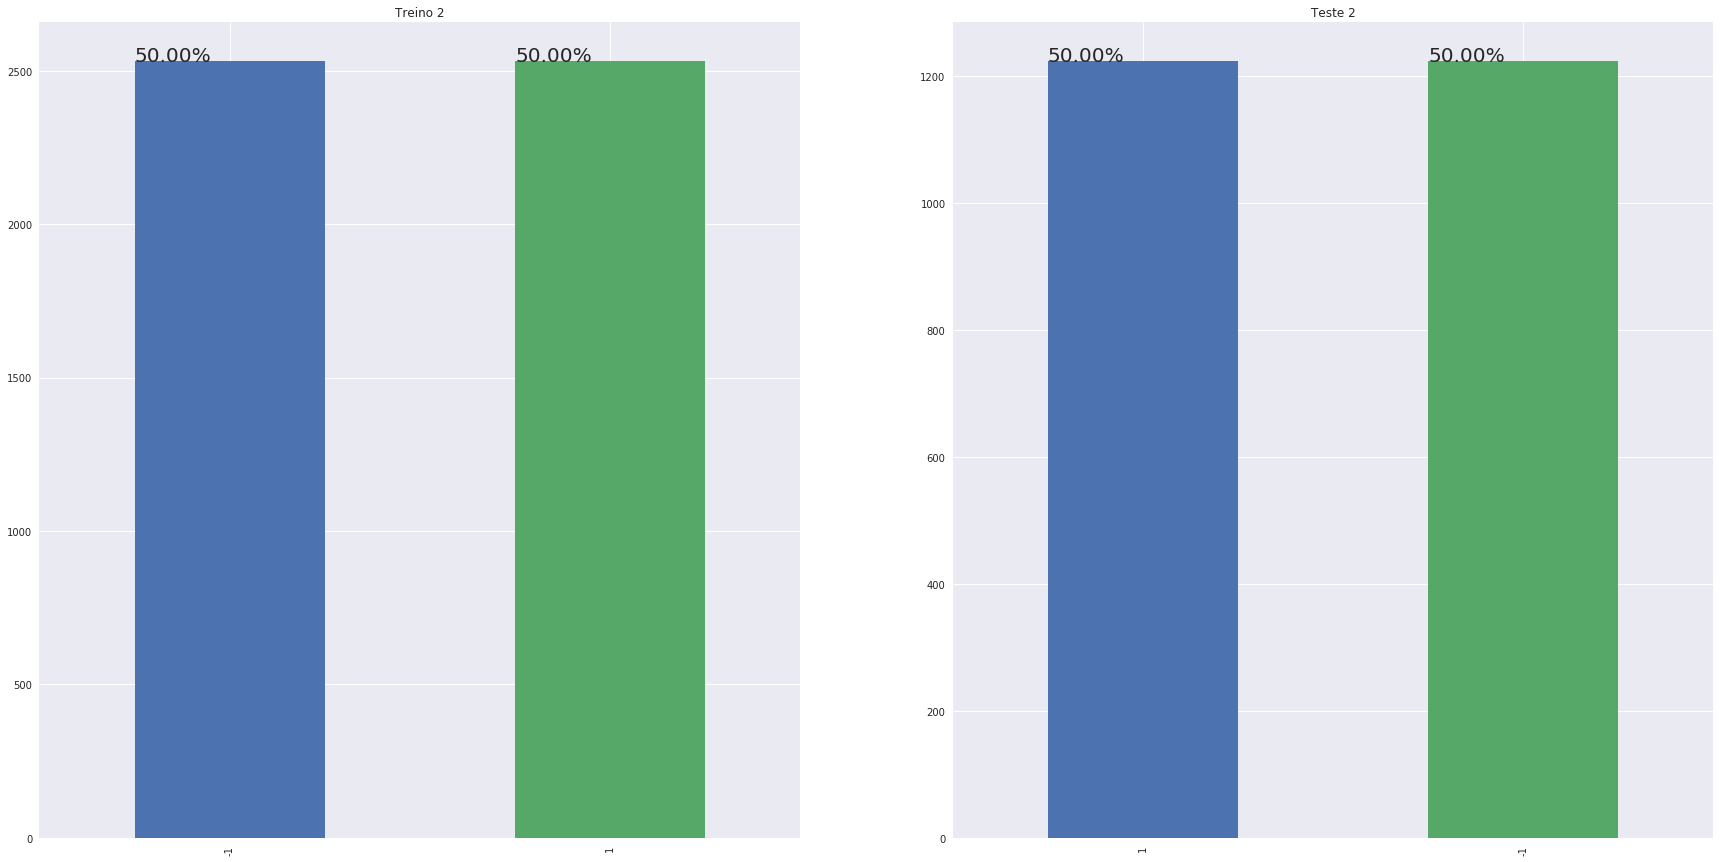

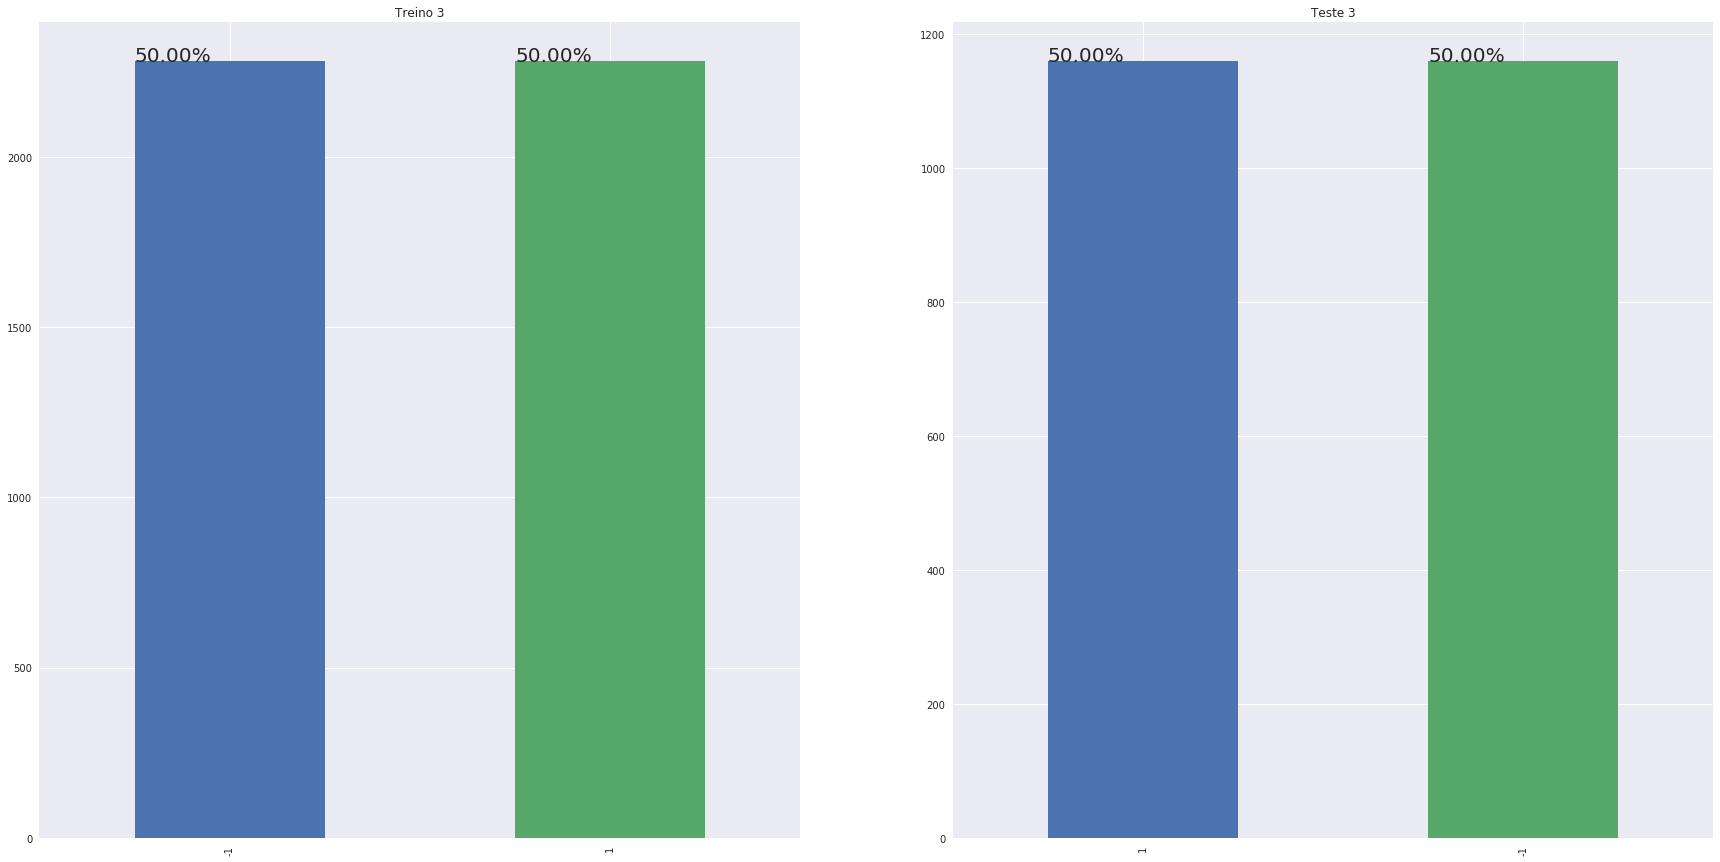

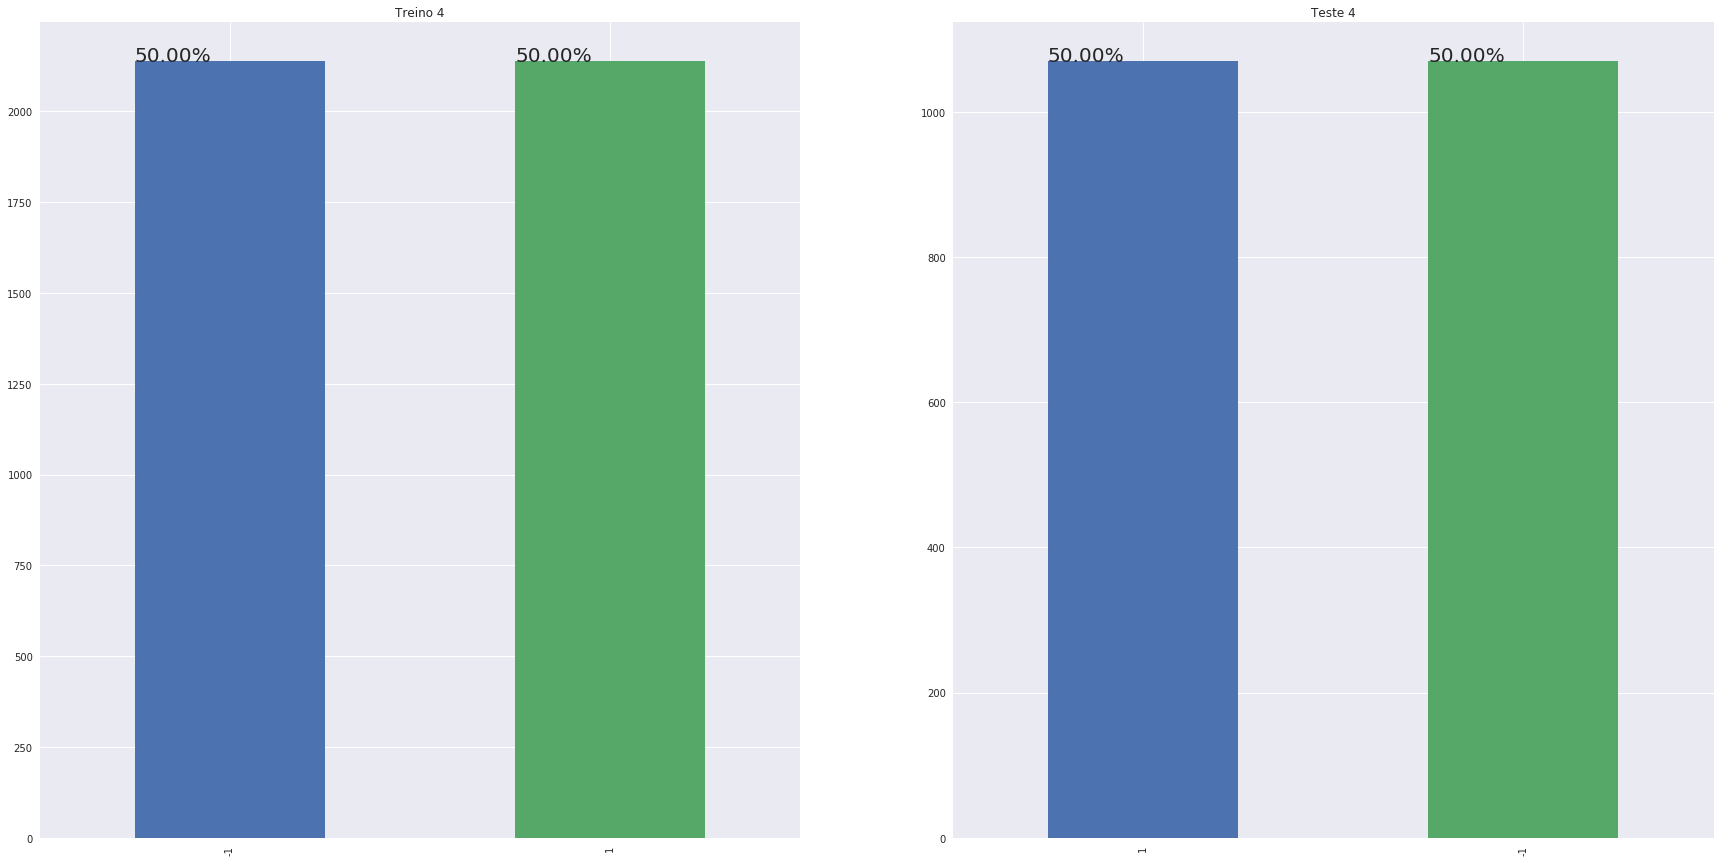

In [3]:
# Checando a distribuição dos targets em cada conjunto (treino e teste) de cada abordagem

sns.set(style='darkgrid')
temp_train = [train_target_1, train_target_2, train_target_3, train_target_4]
temp_test = [test_target_1, test_target_2, test_target_3, test_target_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

temp_train_b = [train_target_b_1, train_target_b_2, train_target_b_3, train_target_b_4]
temp_test_b = [test_target_b_1, test_target_b_2, test_target_b_3, test_target_b_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train_b[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test_b[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

In [4]:
# Importando módulos do SVM

from sklearn.naive_bayes import BernoulliNB

# Definindo os parâmetros do modelo e possíveis valores

bnb = BernoulliNB()

param_grid = {'alpha': [1], 'binarize': [None], 'fit_prior': [True], 'class_prior': [None]}

# Validação cruzada com cada conjunto de parâmetros

clf_bnb = GridSearchCV(bnb,param_grid,return_train_score=True,cv=10, 
                   scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision'], refit=False)

#### Treinamento

In [5]:
# Abordagem 1: Retirar valores faltantes e manter outliers

clf_bnb.fit(pd.get_dummies(train_data_1), train_target_1)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb.fit(pd.get_dummies(train_data_b_1), train_target_b_1)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Data/naive-bayes-abordagem-1-balanceado-dataset-10pct.pkl']

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


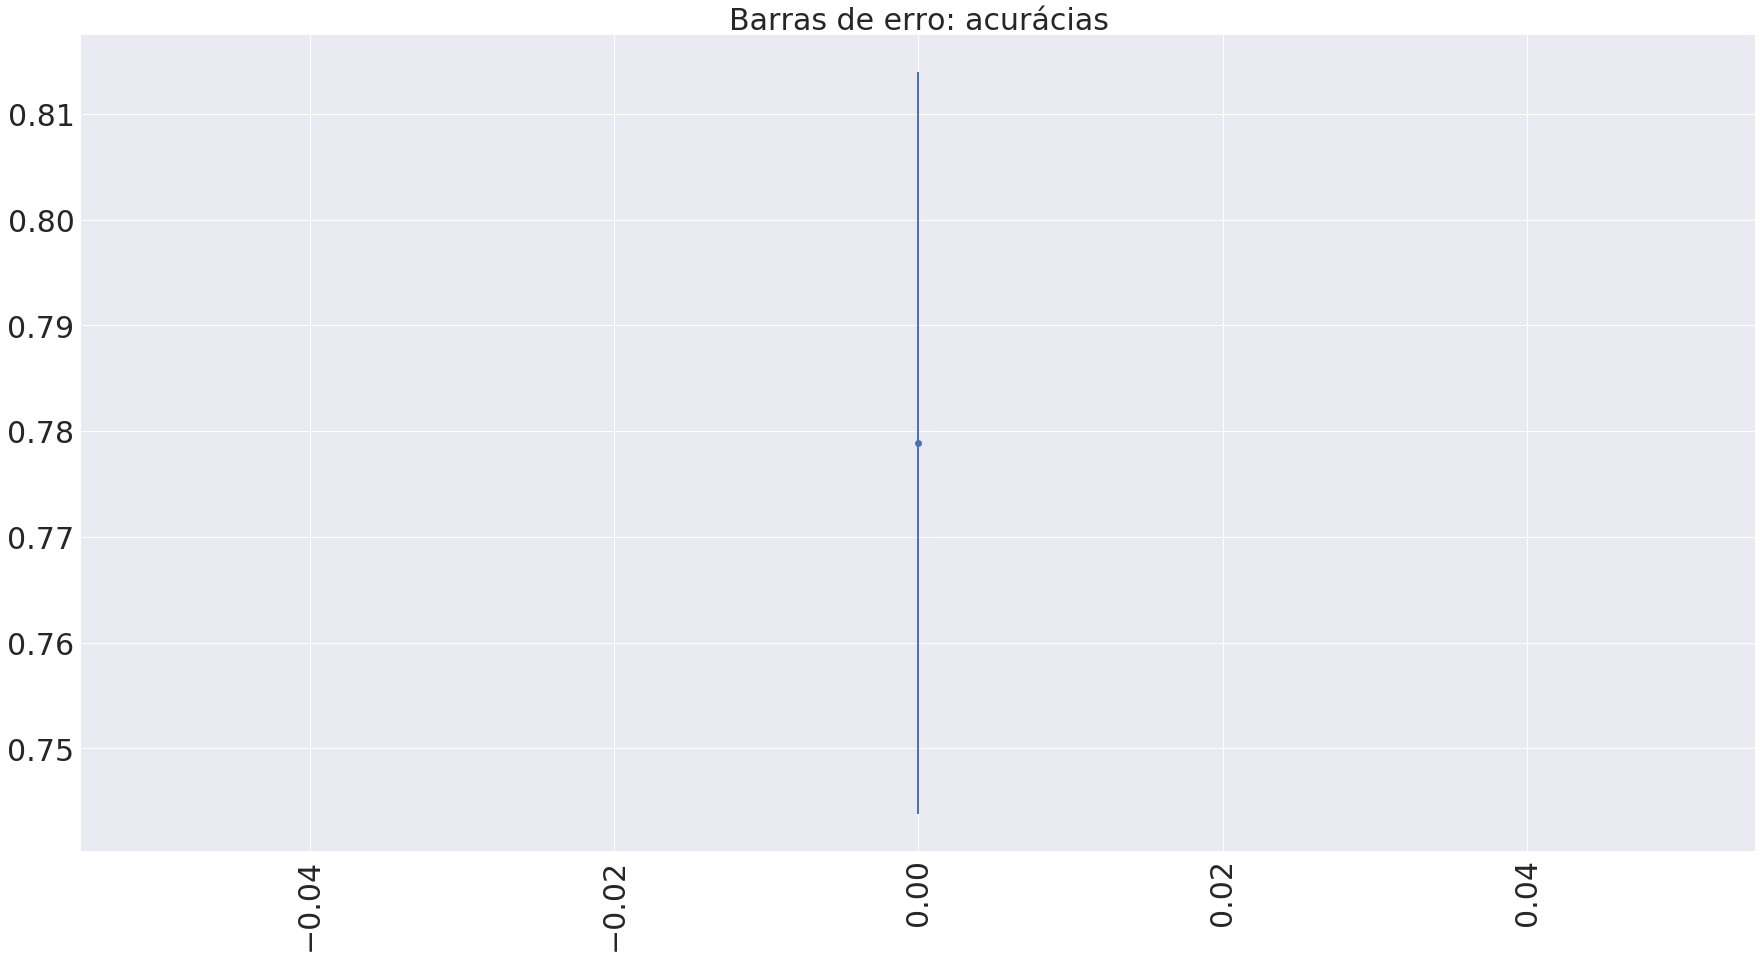

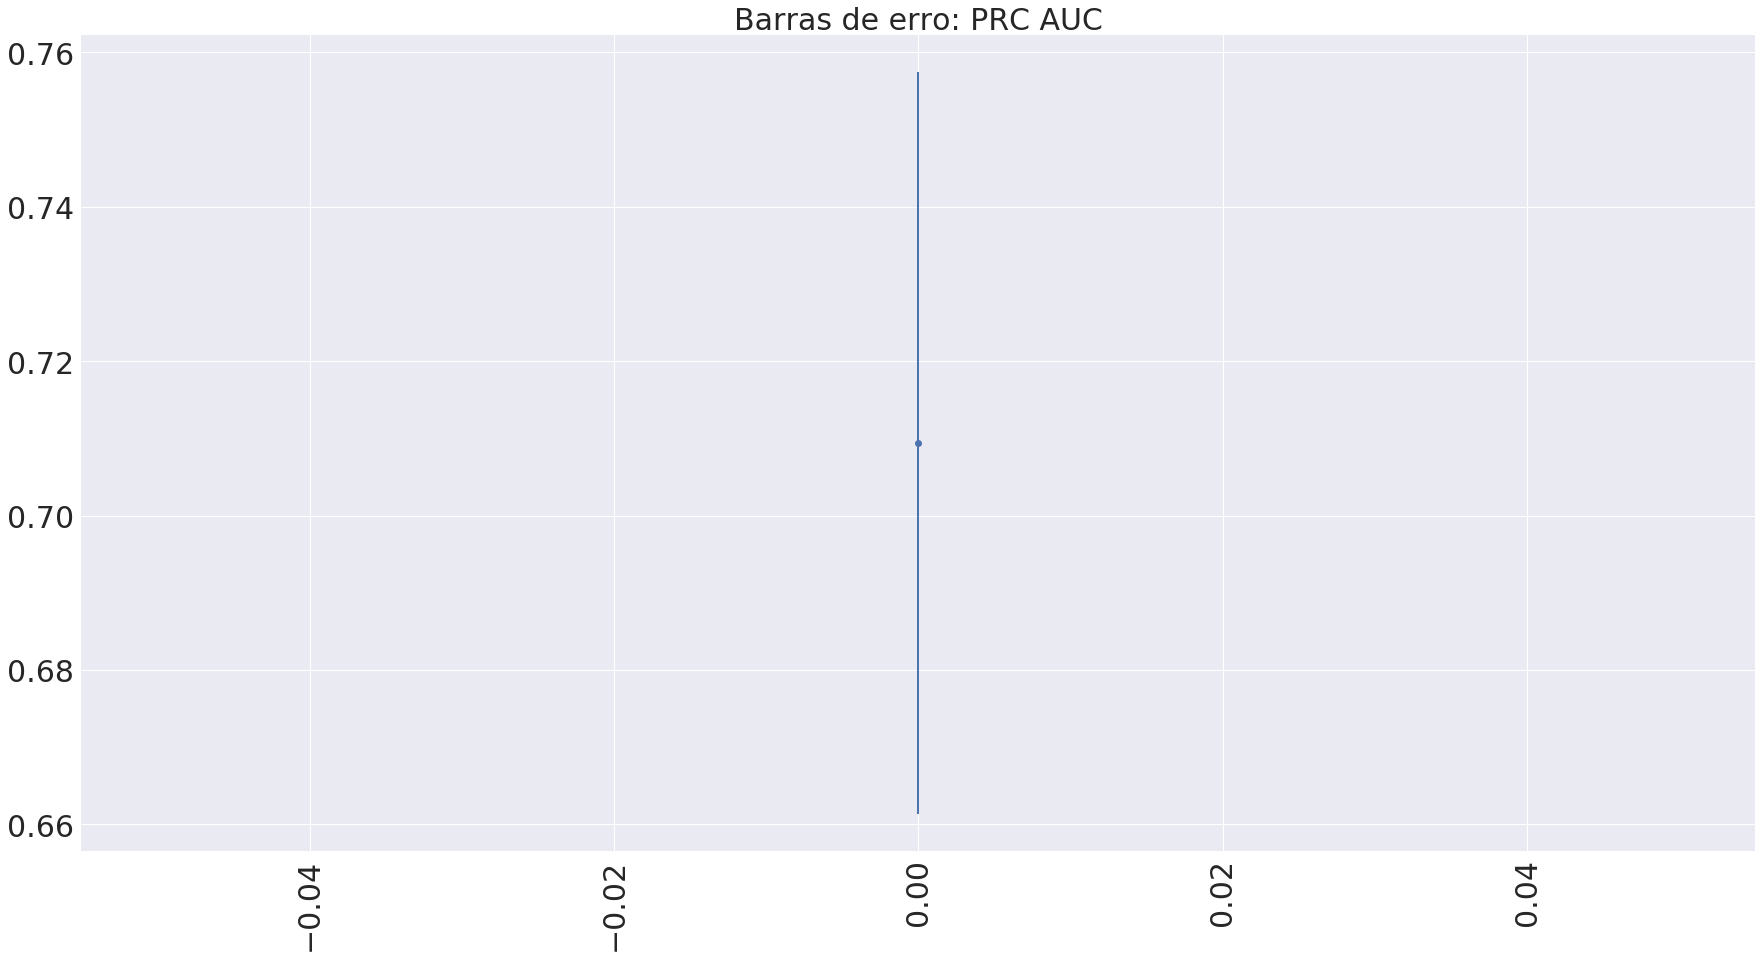

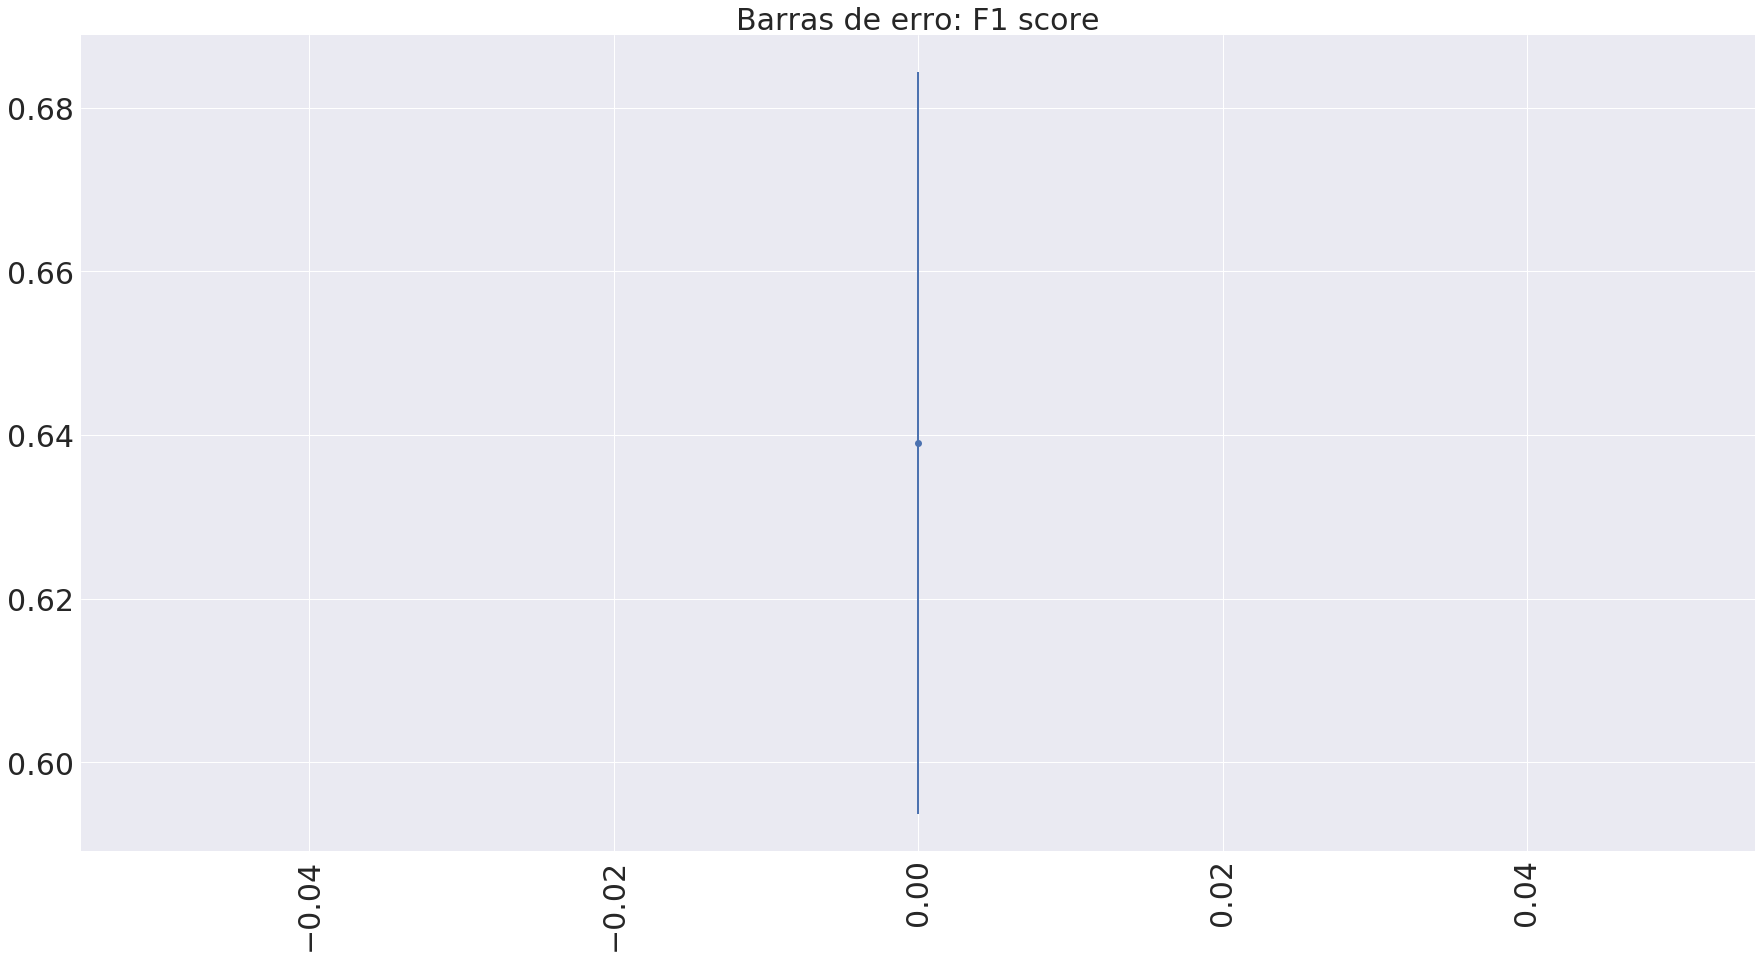

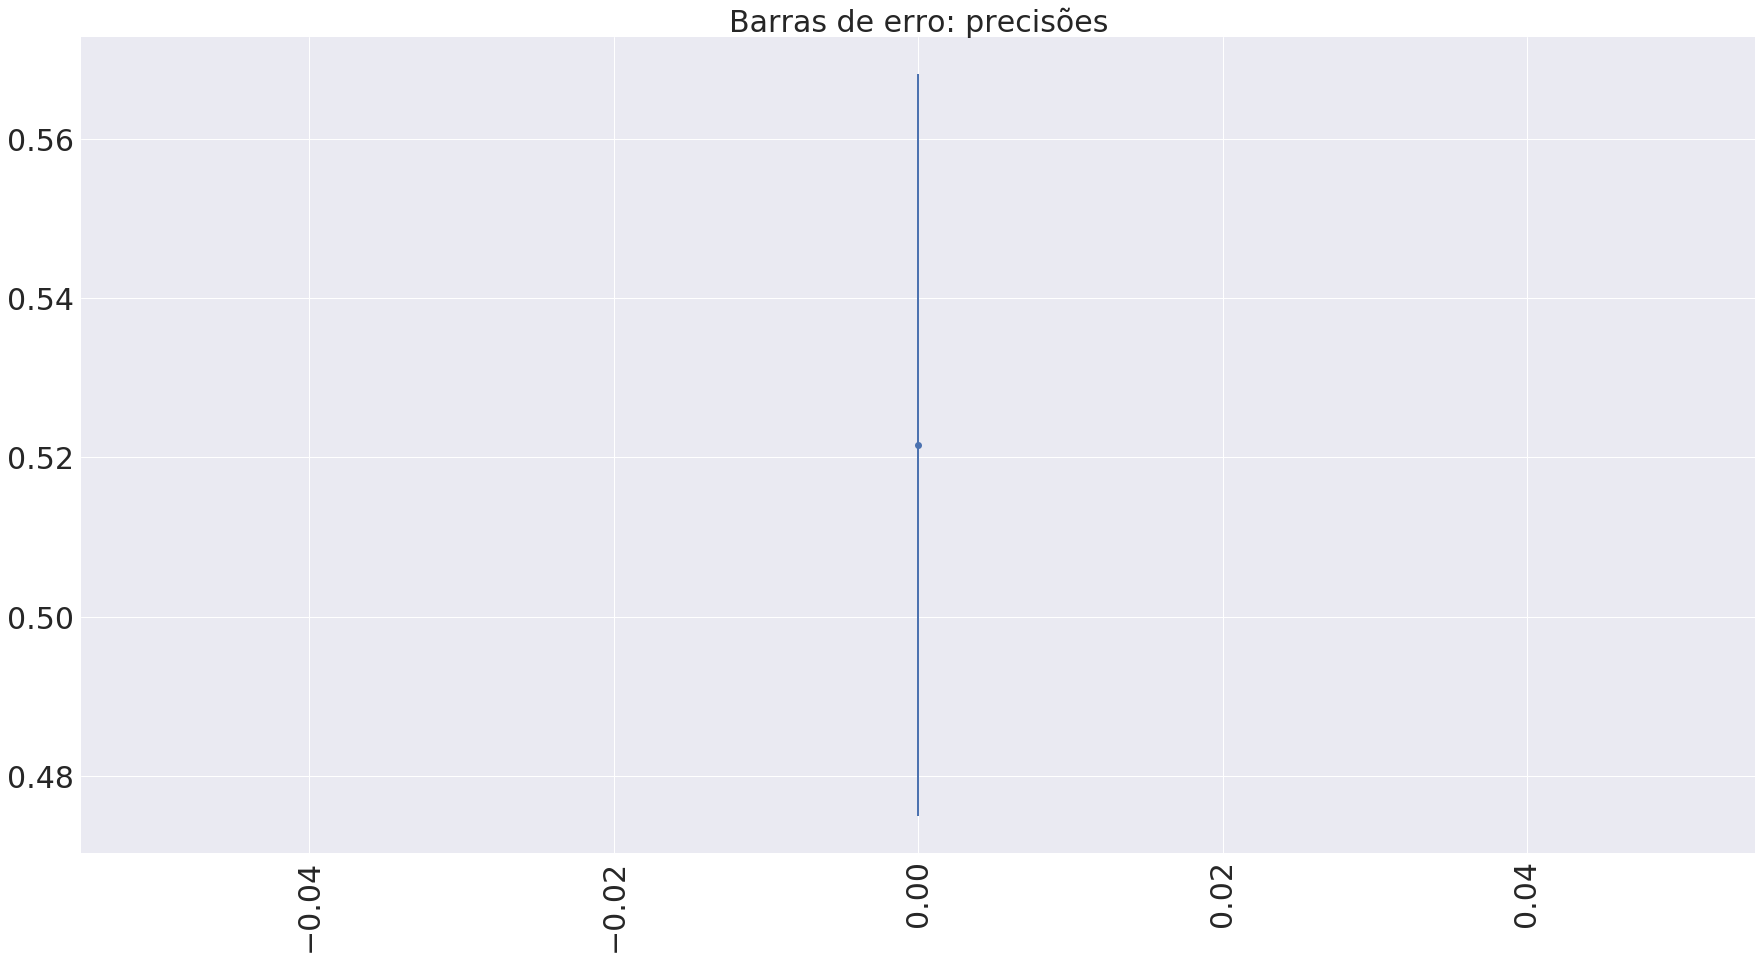

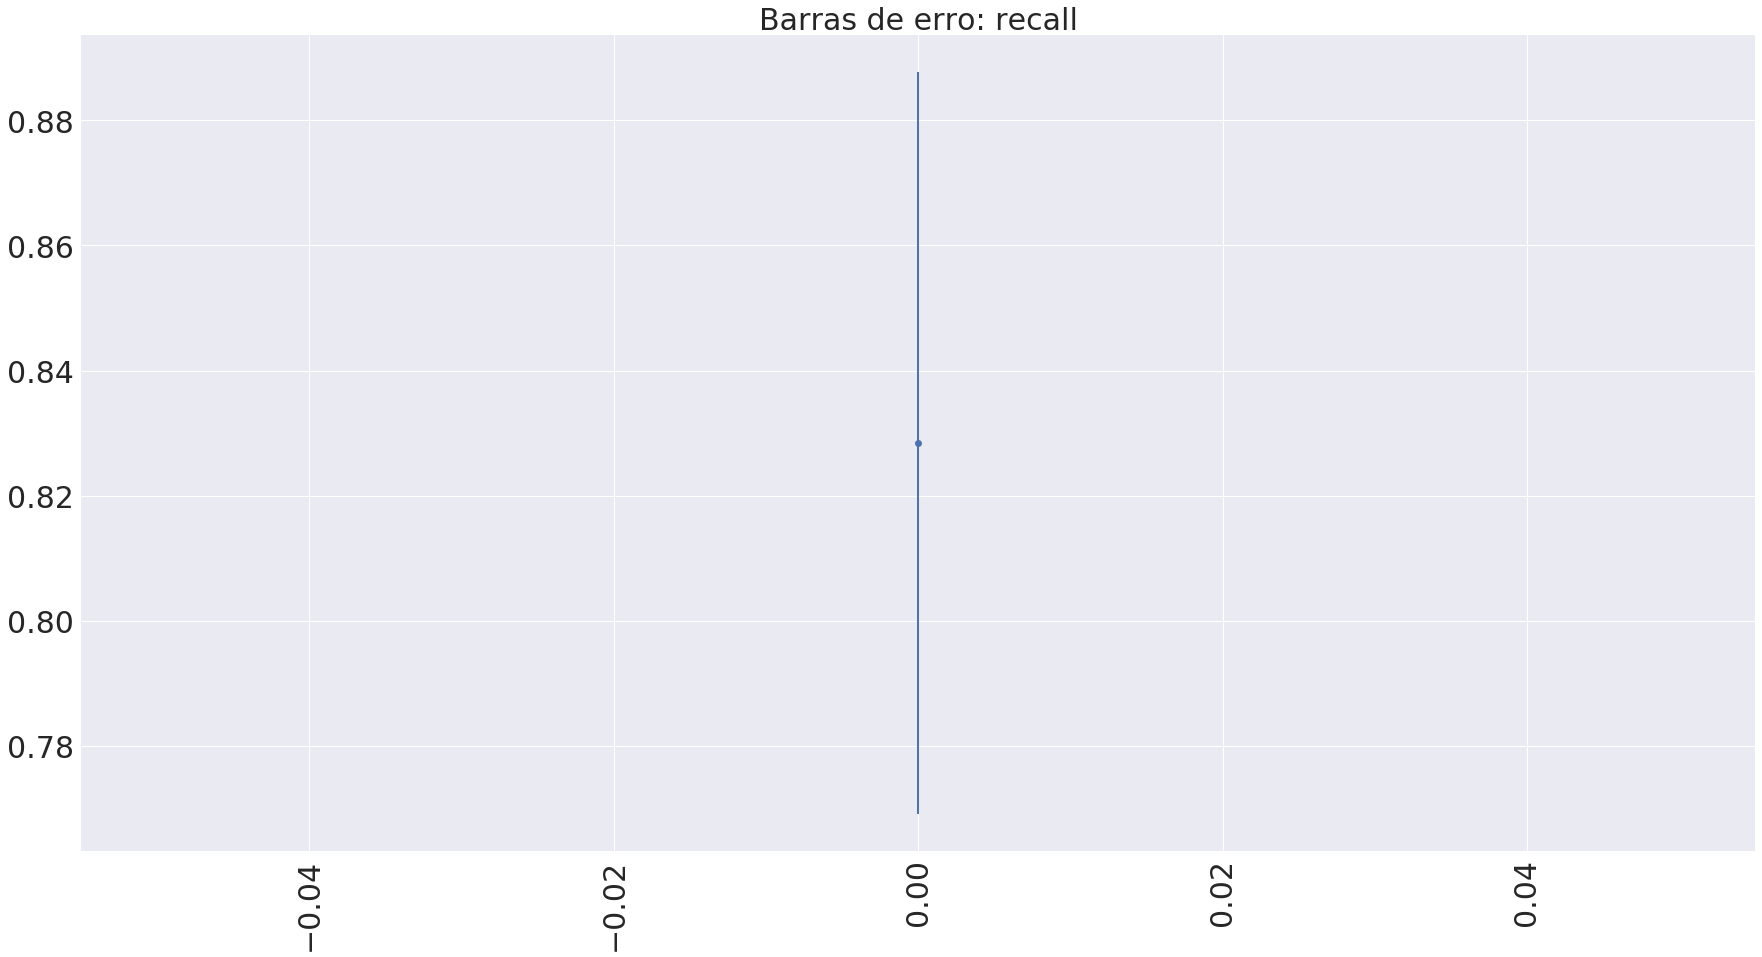

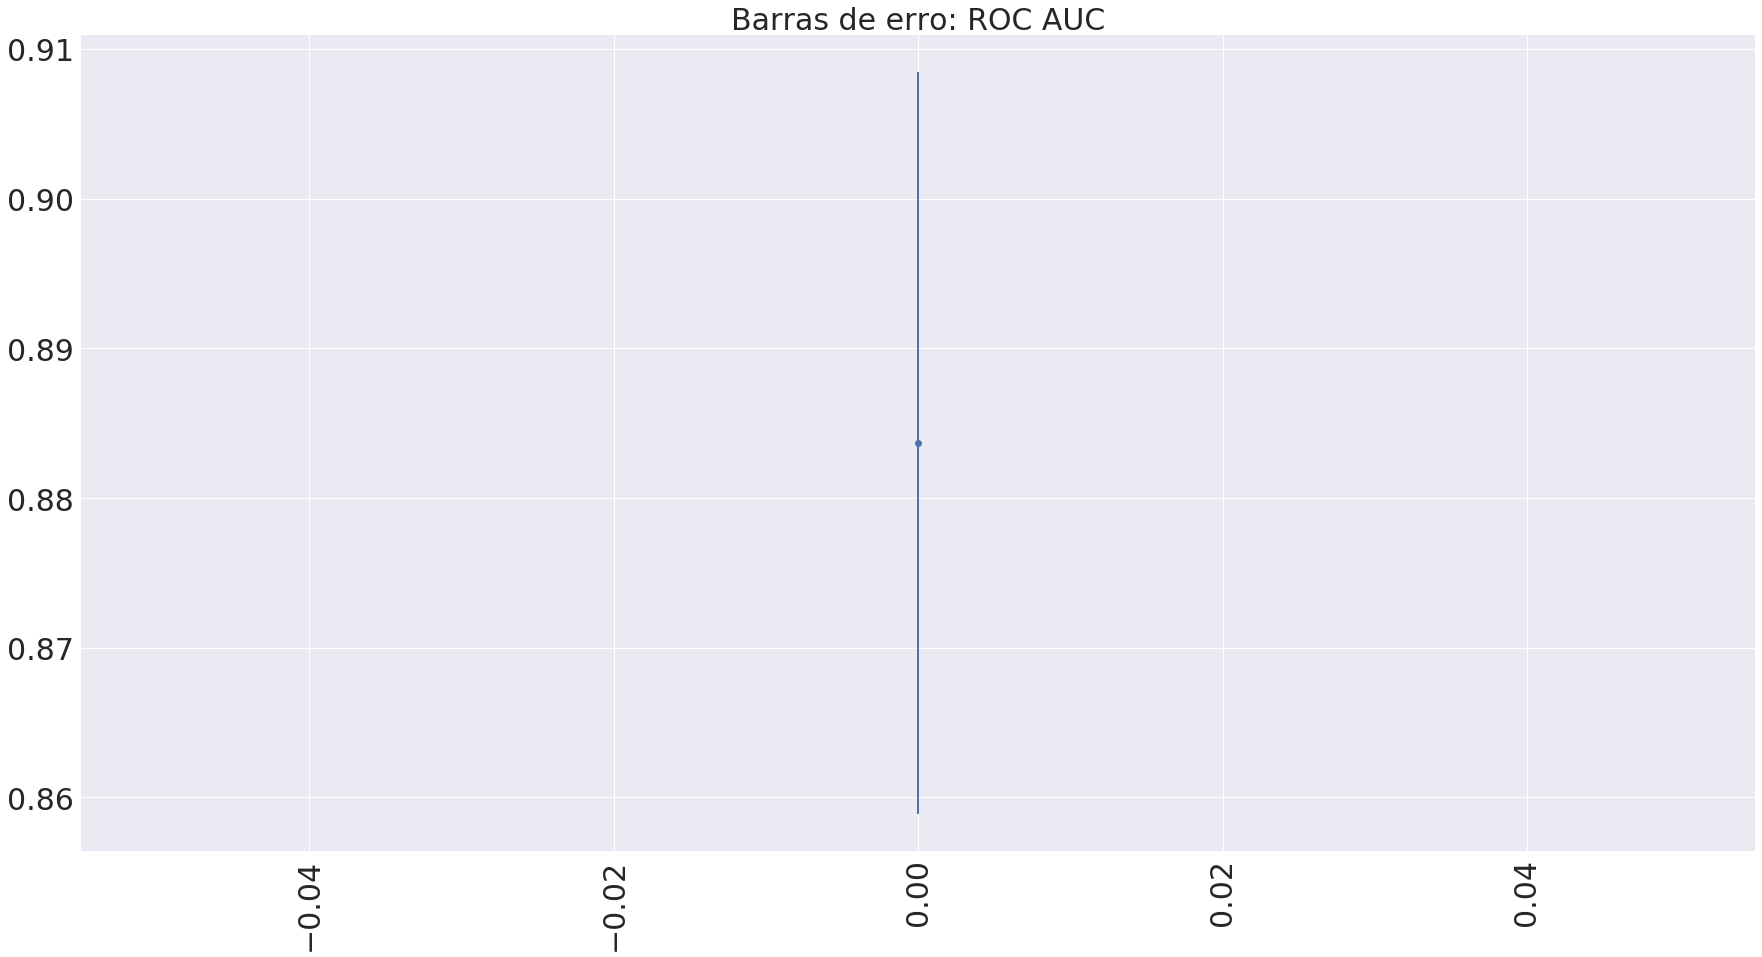

In [6]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_desbalanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_desbalanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


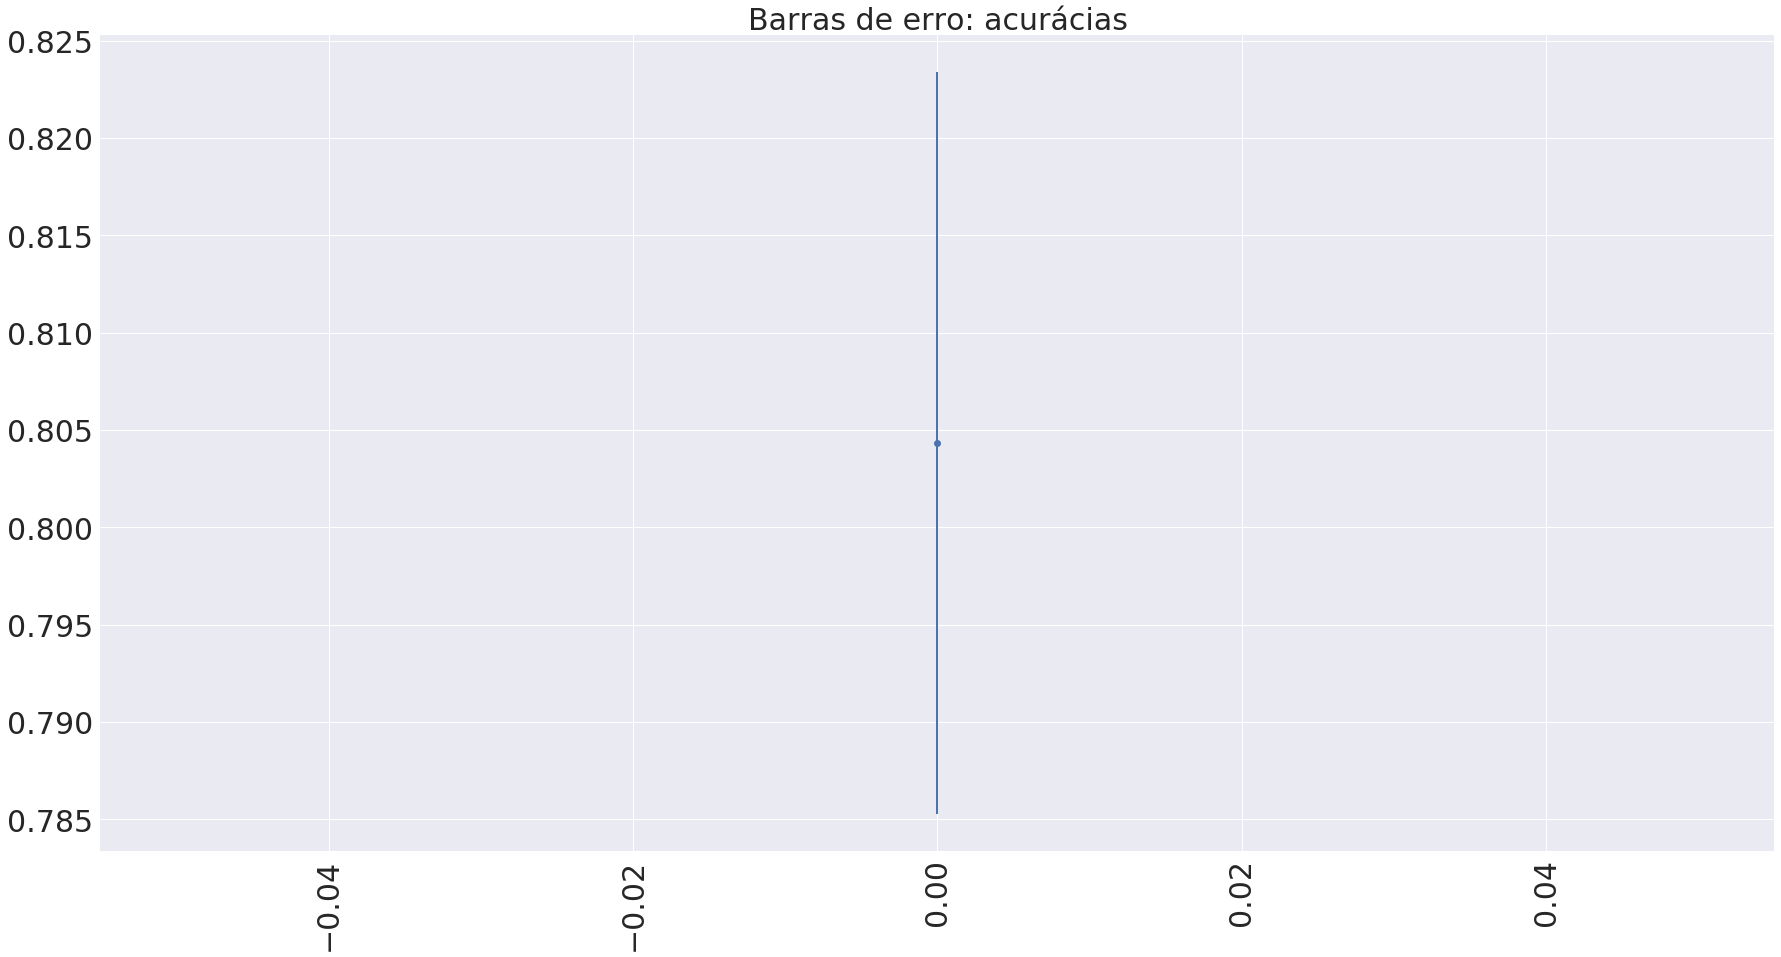

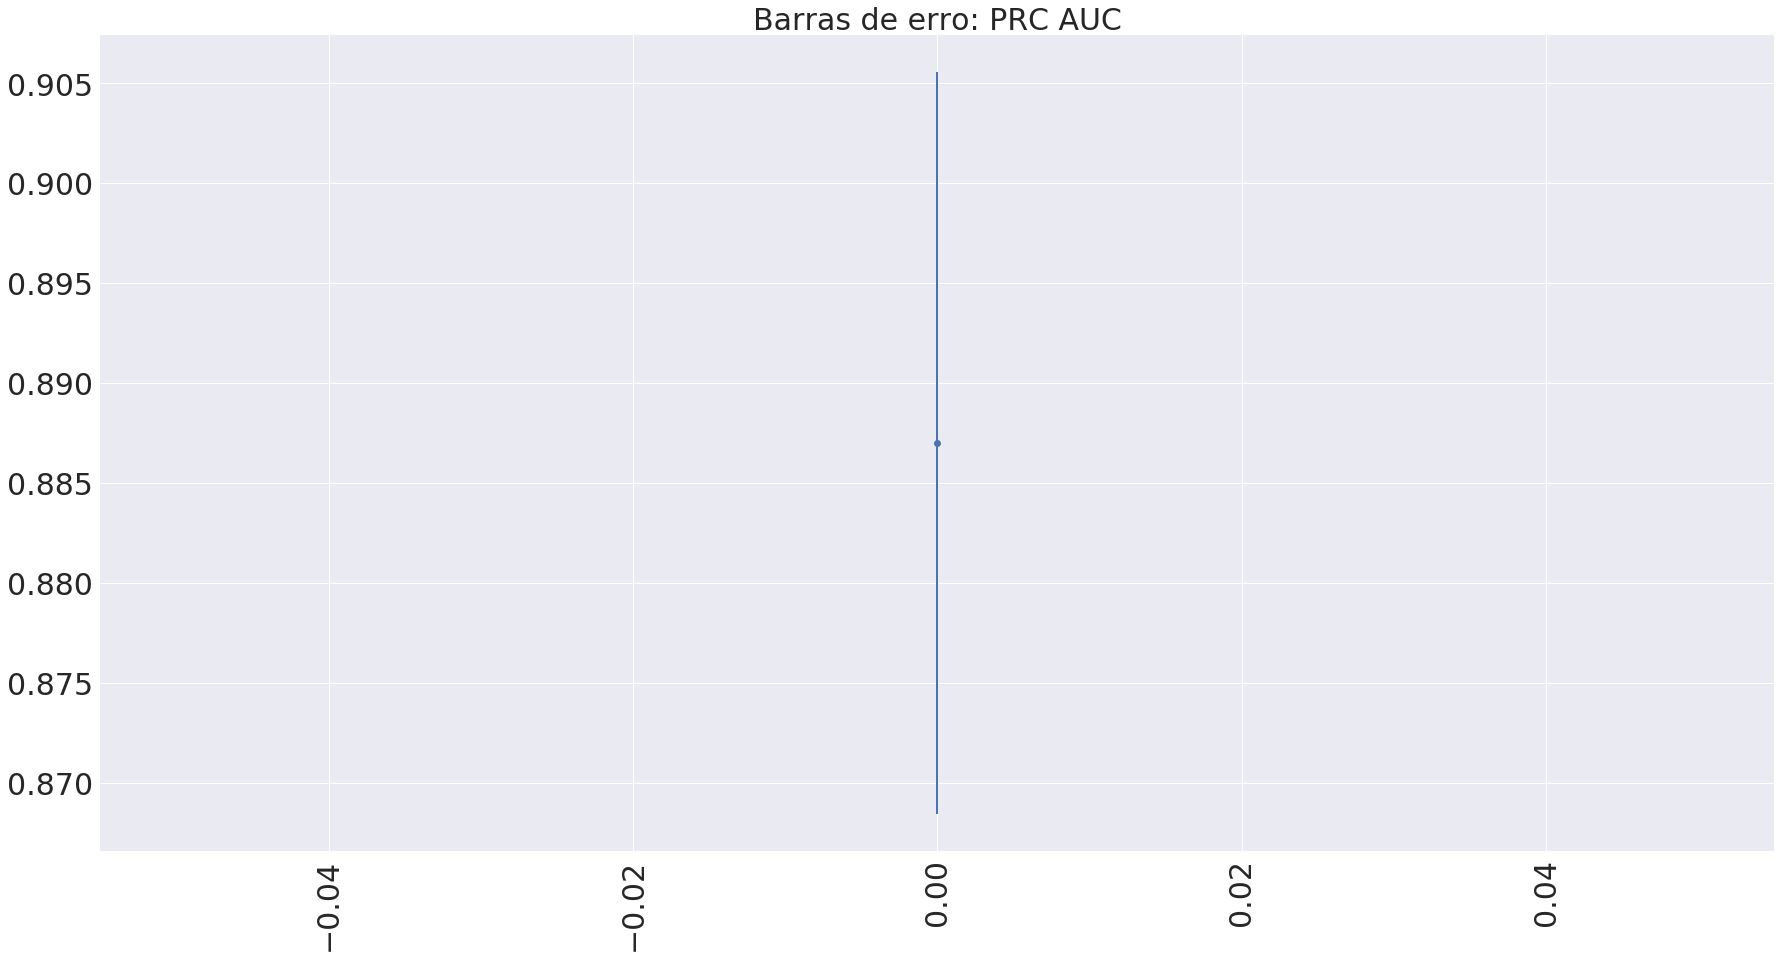

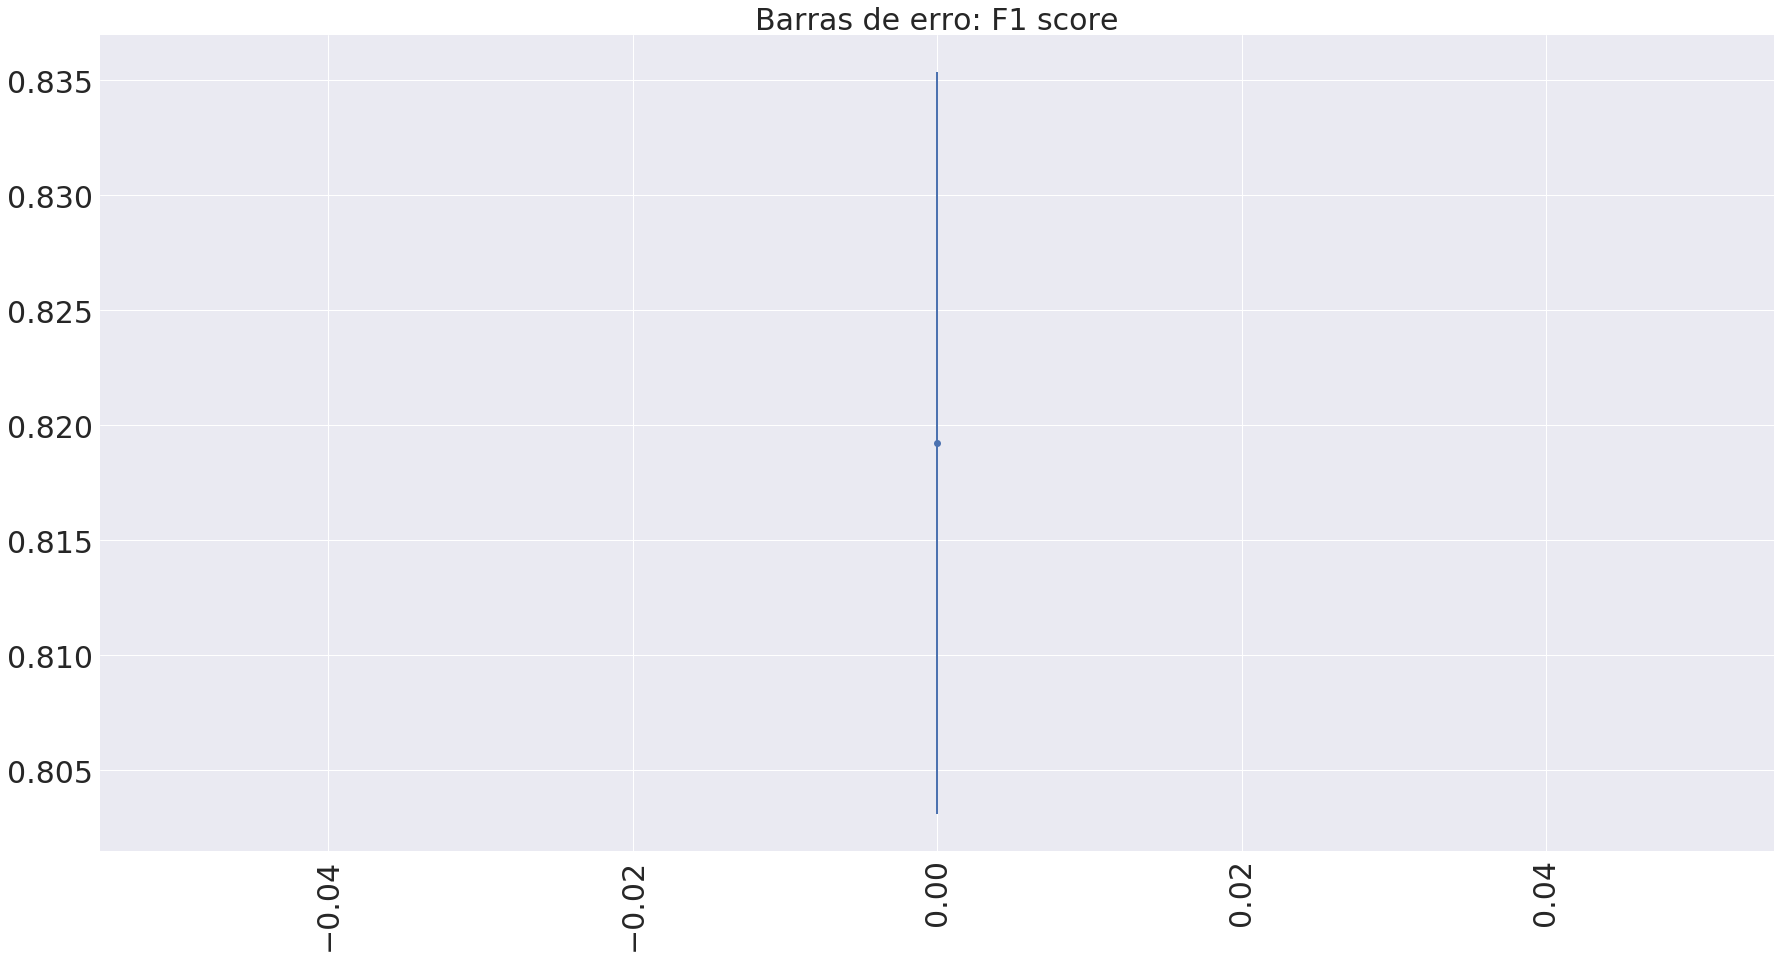

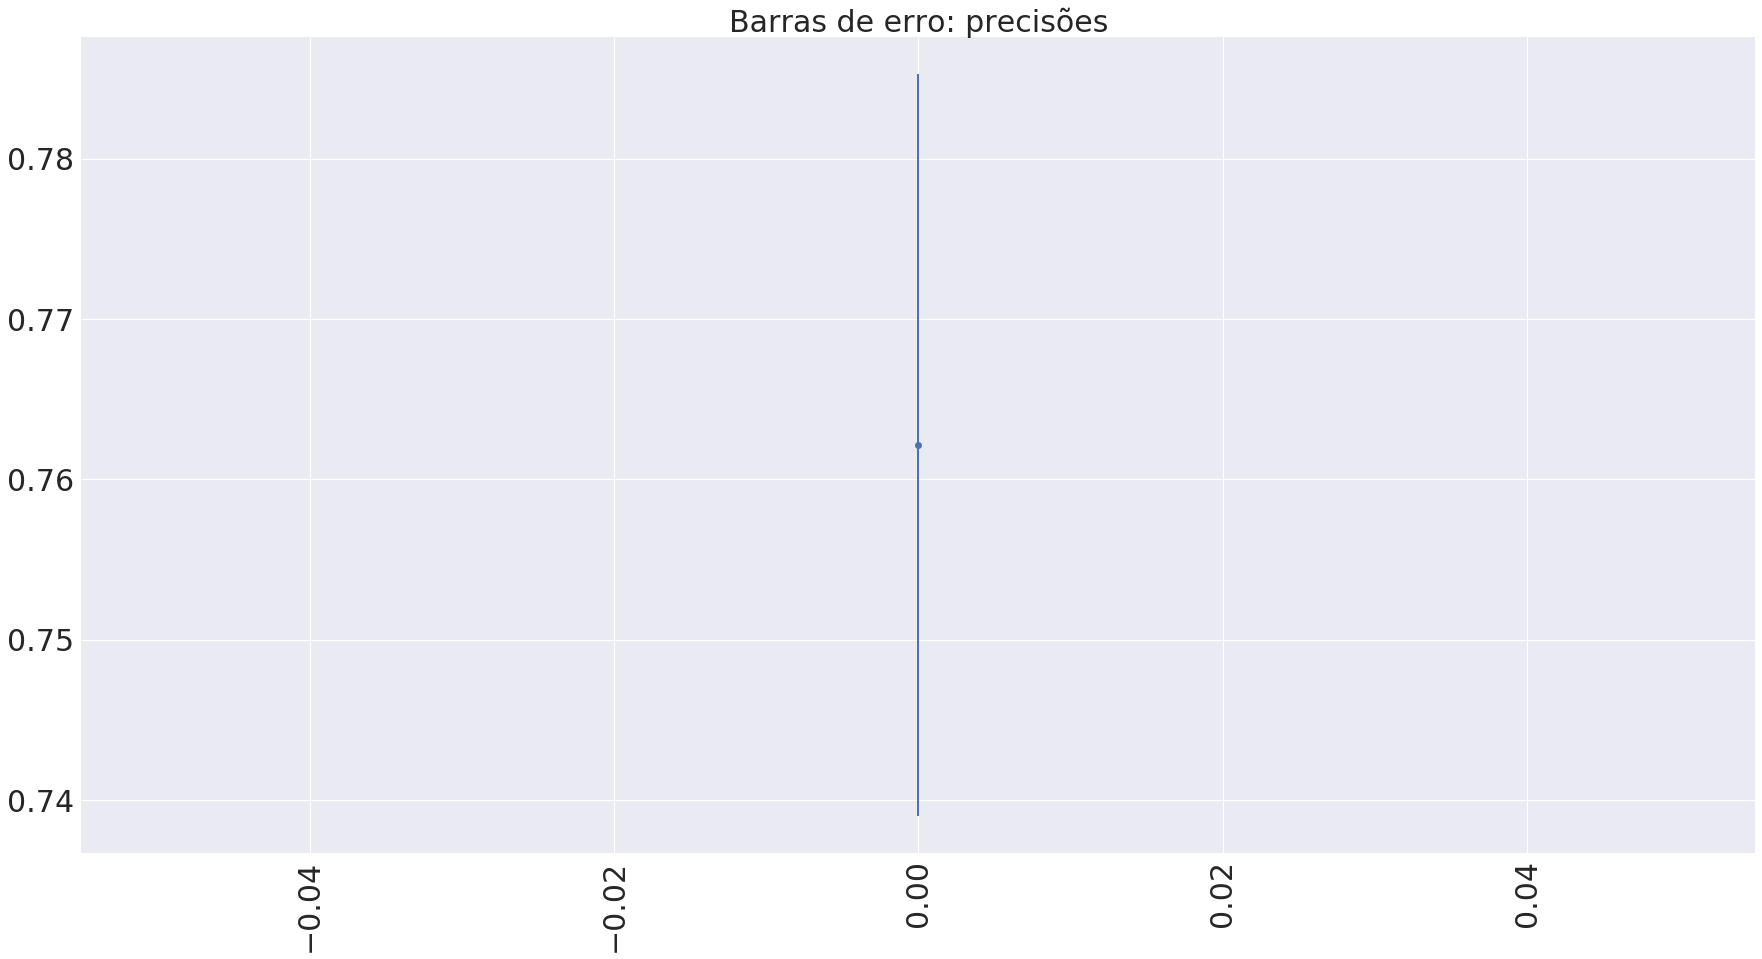

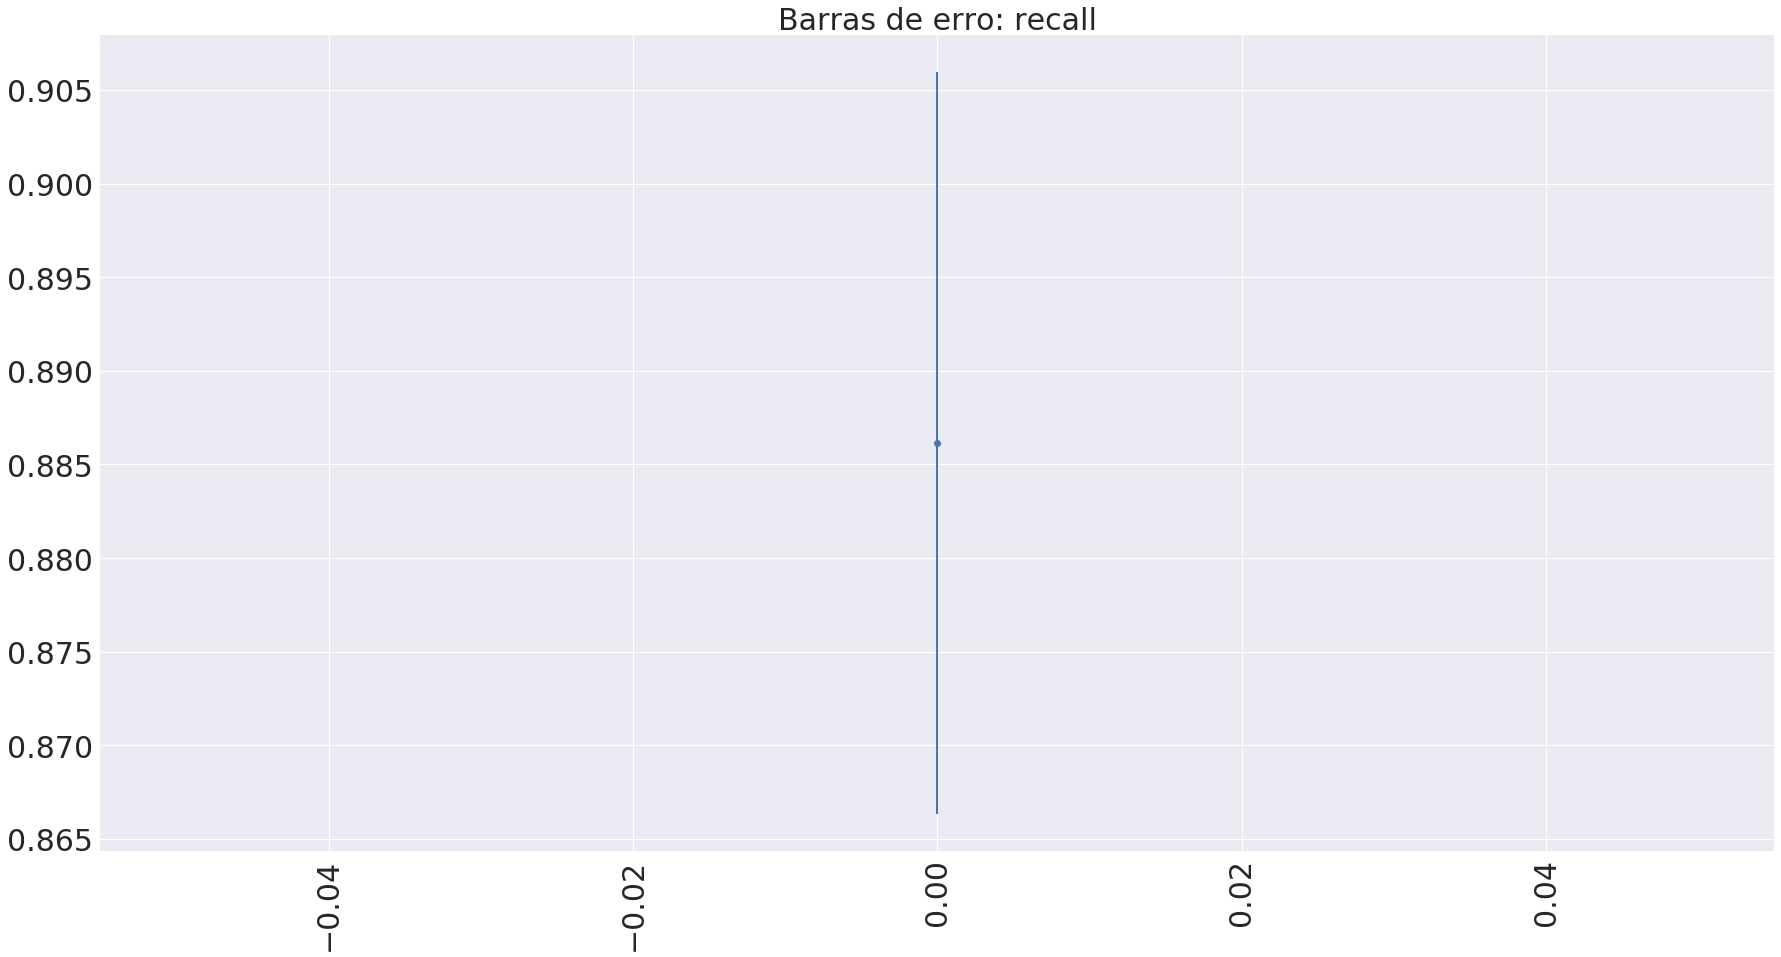

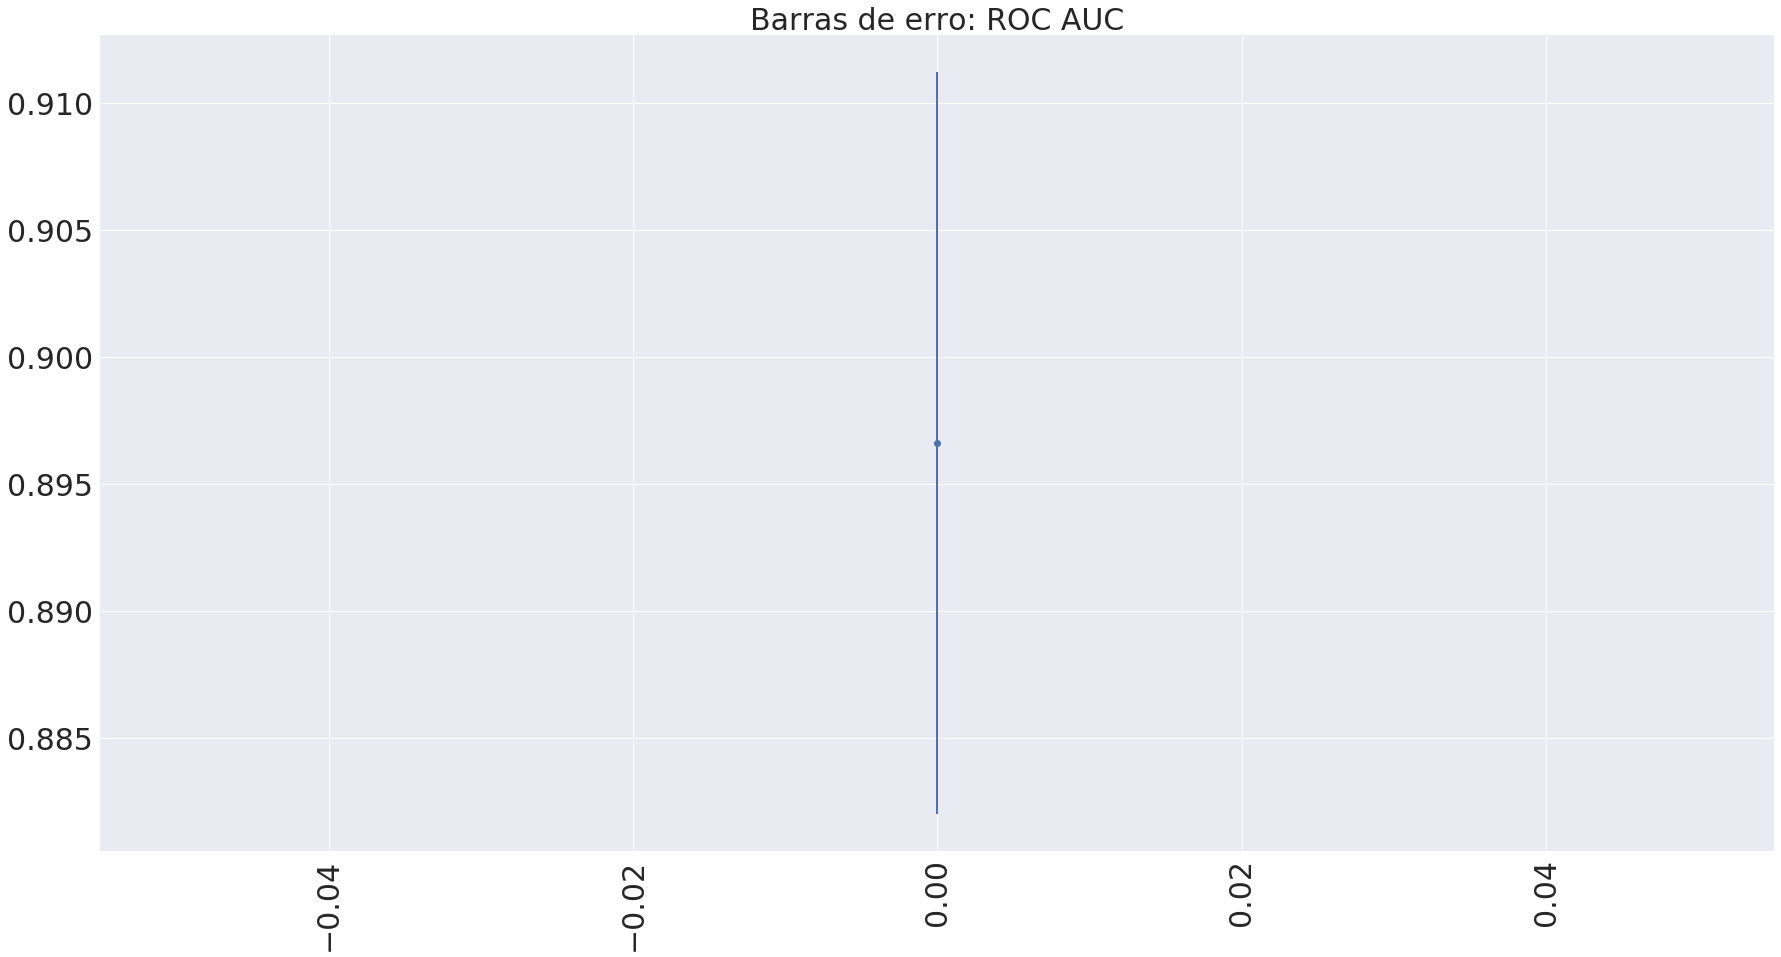

In [7]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_balanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_balanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [8]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_final = BernoulliNB(alpha=1, binarize=None, fit_prior=True, class_prior=None)

clf_bnb_final.fit(pd.get_dummies(train_data_1), train_target_1)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb_final.fit(pd.get_dummies(train_data_b_1), train_target_b_1)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-final-abordagem-1-balanceado-dataset-10pct.pkl']

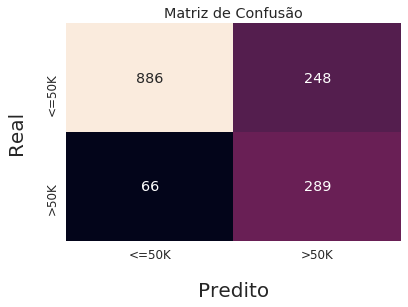

Acurácia: 78.912 %
Precisão: 53.818 %
Recall: 81.408 %
ROC AUC: 79.769 %
PRC AUC: 48.245 %


In [9]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_desbalanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-1-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_desbalanceado, 
                         test_data=pd.get_dummies(test_data_1), 
                         test_target=test_target_1, 
                         id_abordagem=1, 
                         str_balanceamento='desbalanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

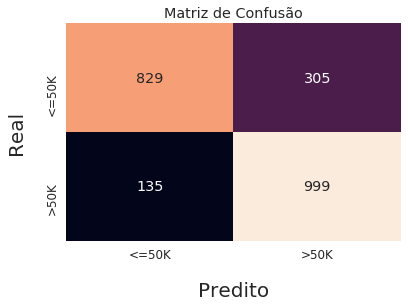

Acurácia: 80.600 %
Precisão: 76.610 %
Recall: 88.095 %
ROC AUC: 80.600 %
PRC AUC: 73.443 %


In [10]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_balanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-1-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_balanceado, 
                         test_data=pd.get_dummies(test_data_b_1), 
                         test_target=test_target_b_1, 
                         id_abordagem=1, 
                         str_balanceamento='balanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

In [11]:
# Abordagem 2: Imputar valores faltantes e manter outliers

clf_bnb.fit(pd.get_dummies(train_data_2), train_target_2)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb.fit(pd.get_dummies(train_data_b_2), train_target_b_2)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-abordagem-2-balanceado-dataset-10pct.pkl']

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


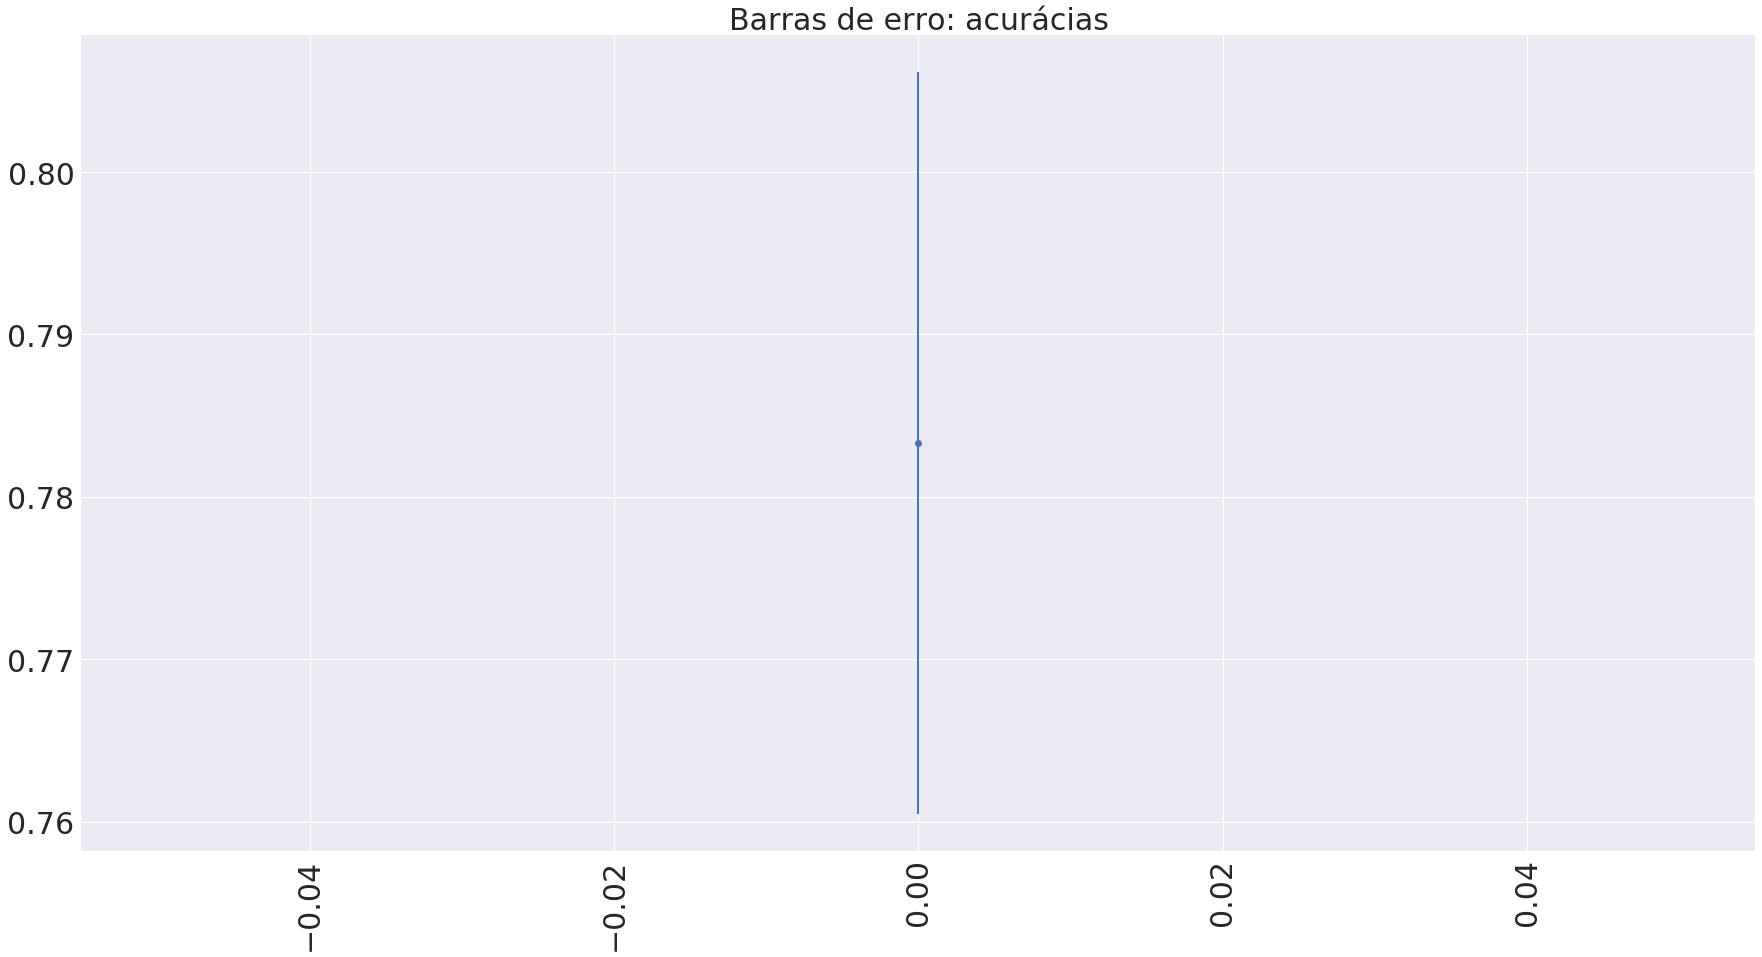

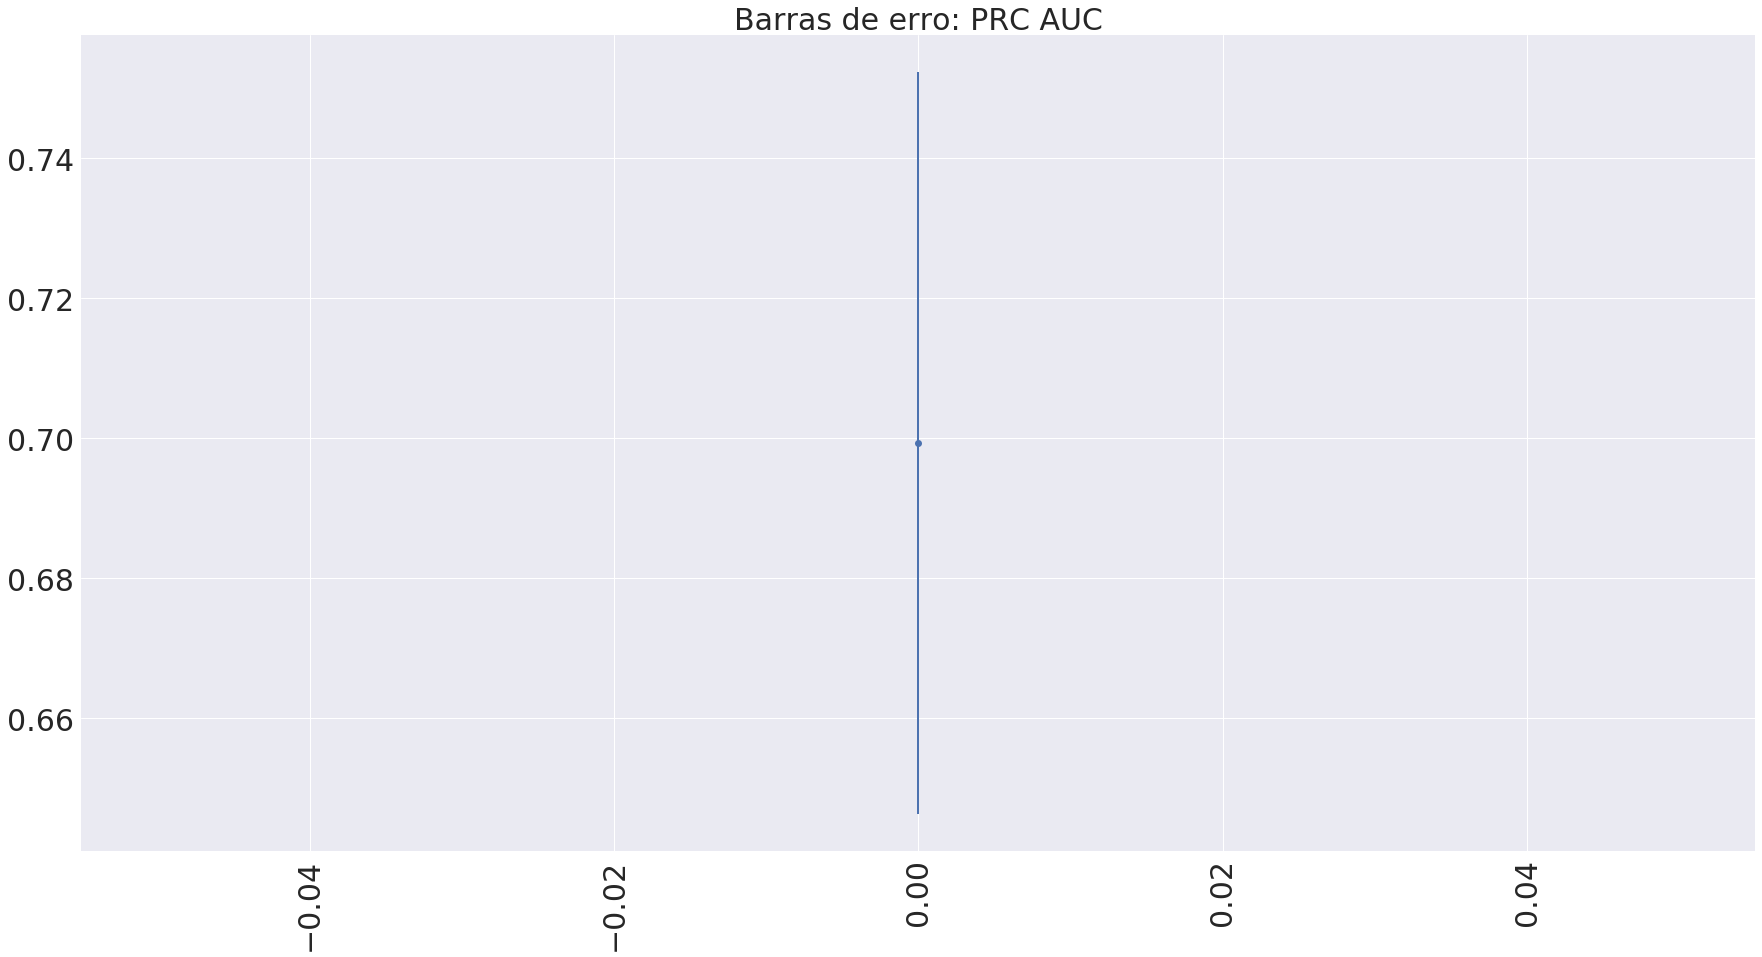

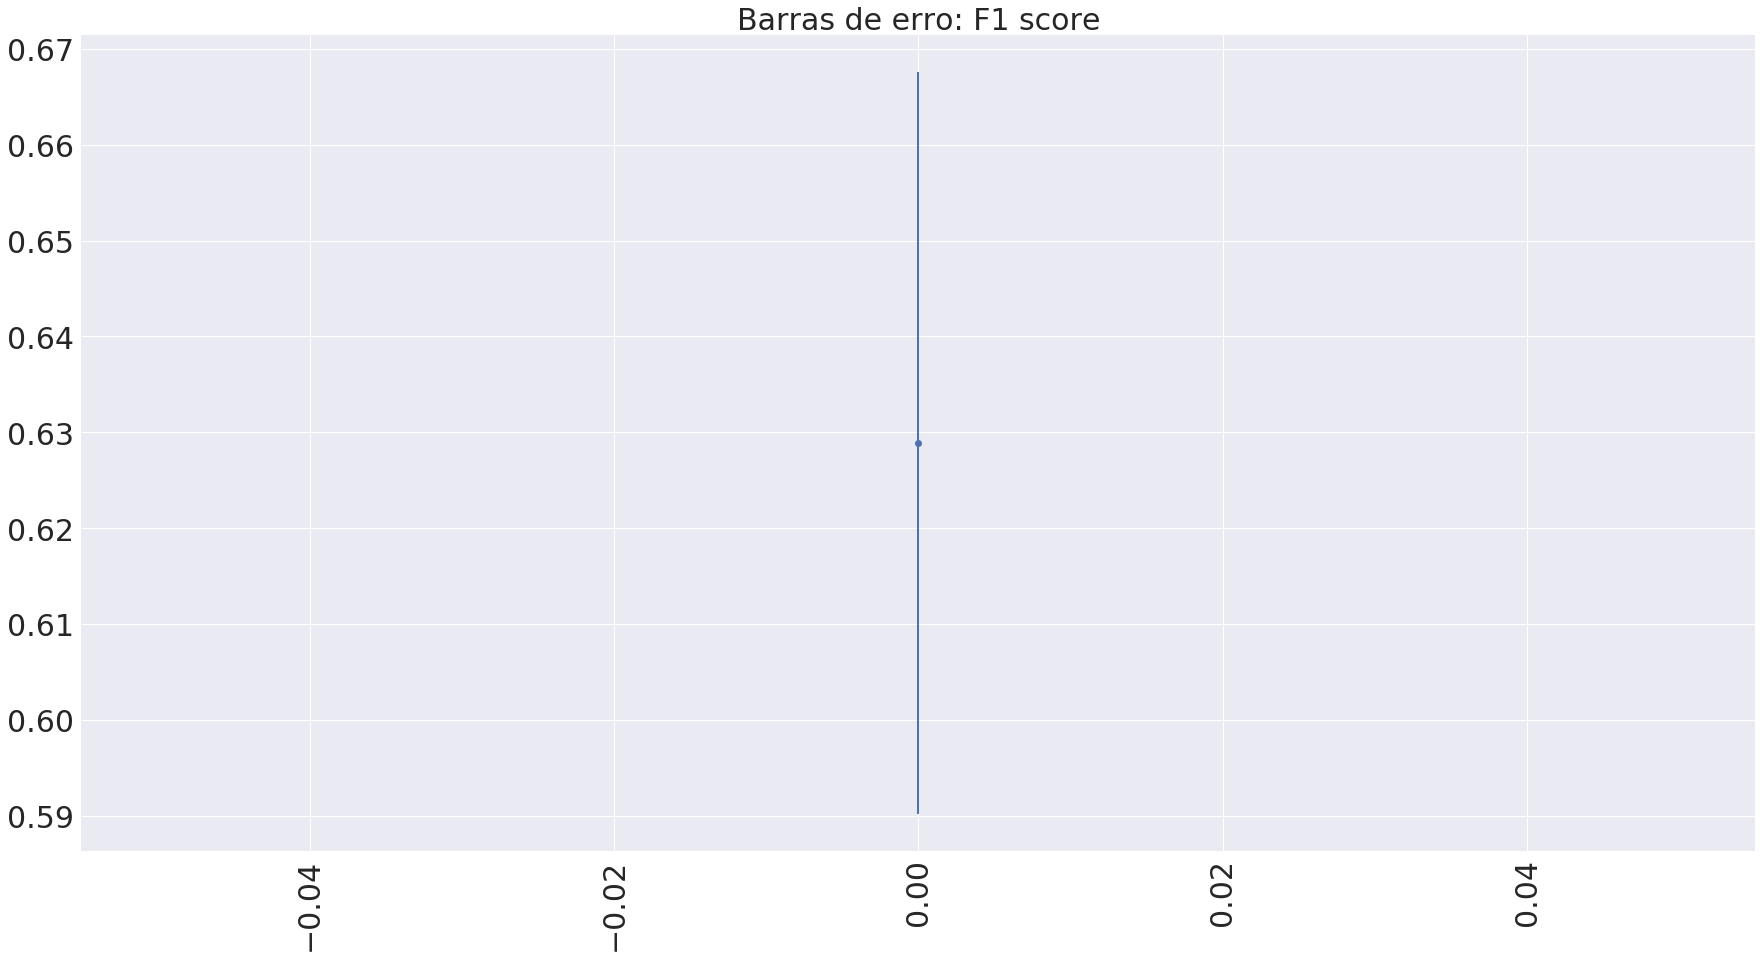

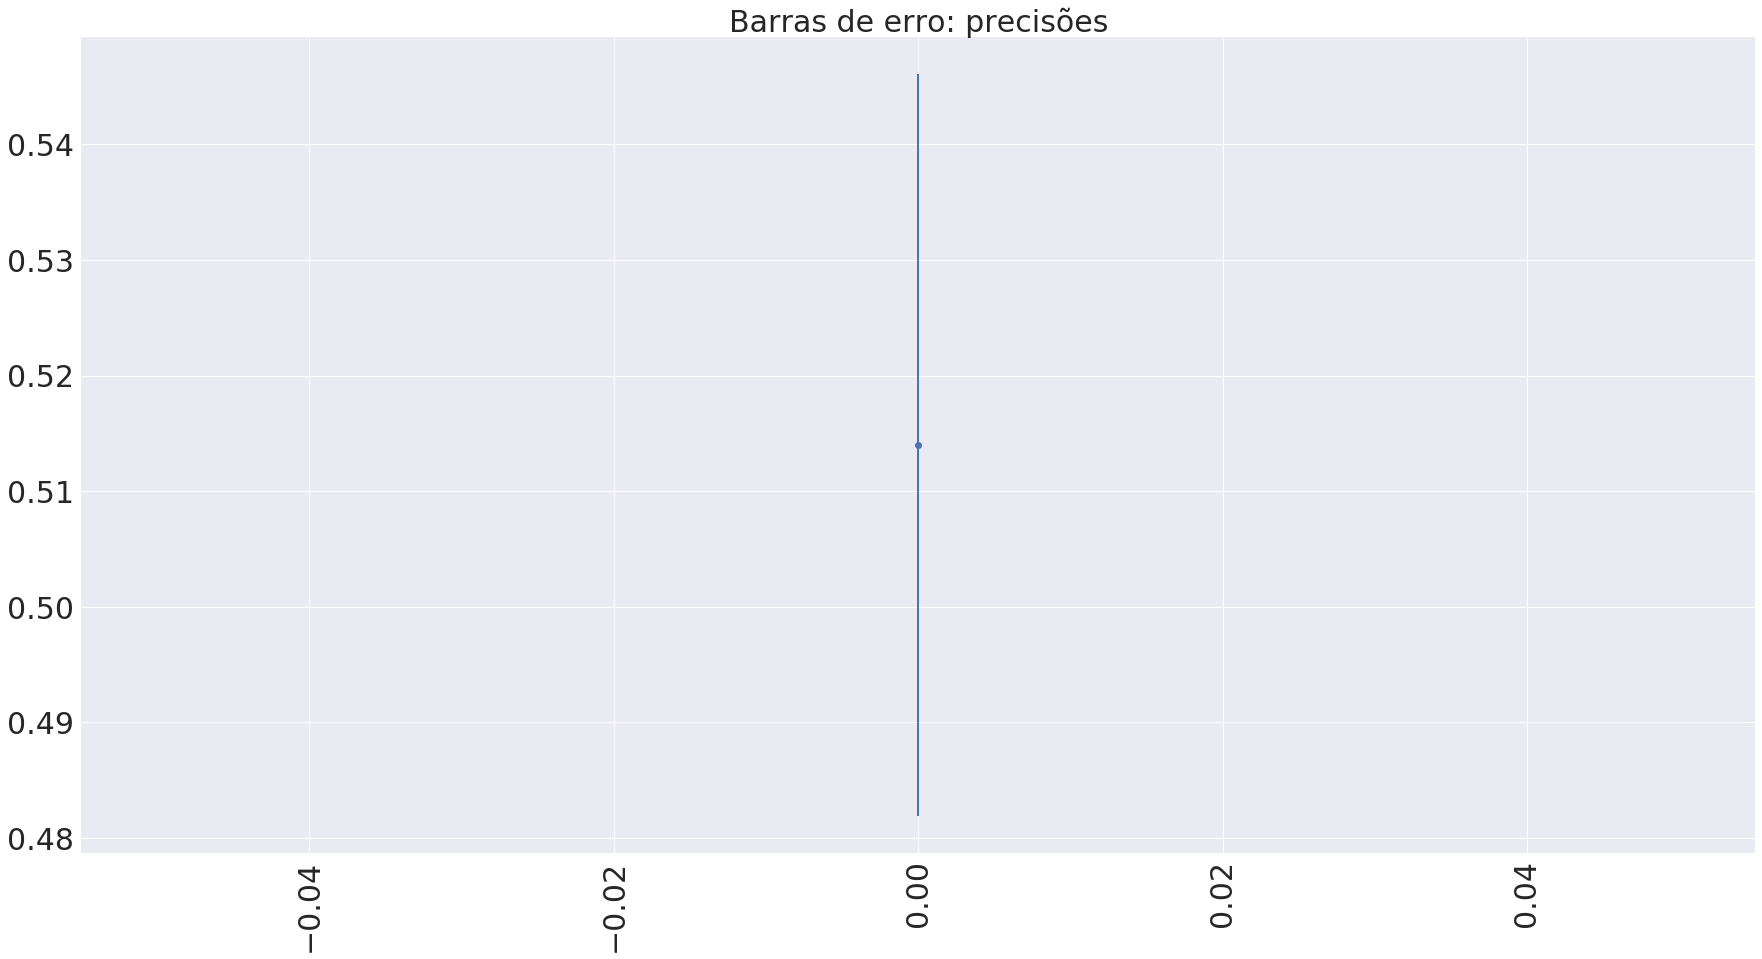

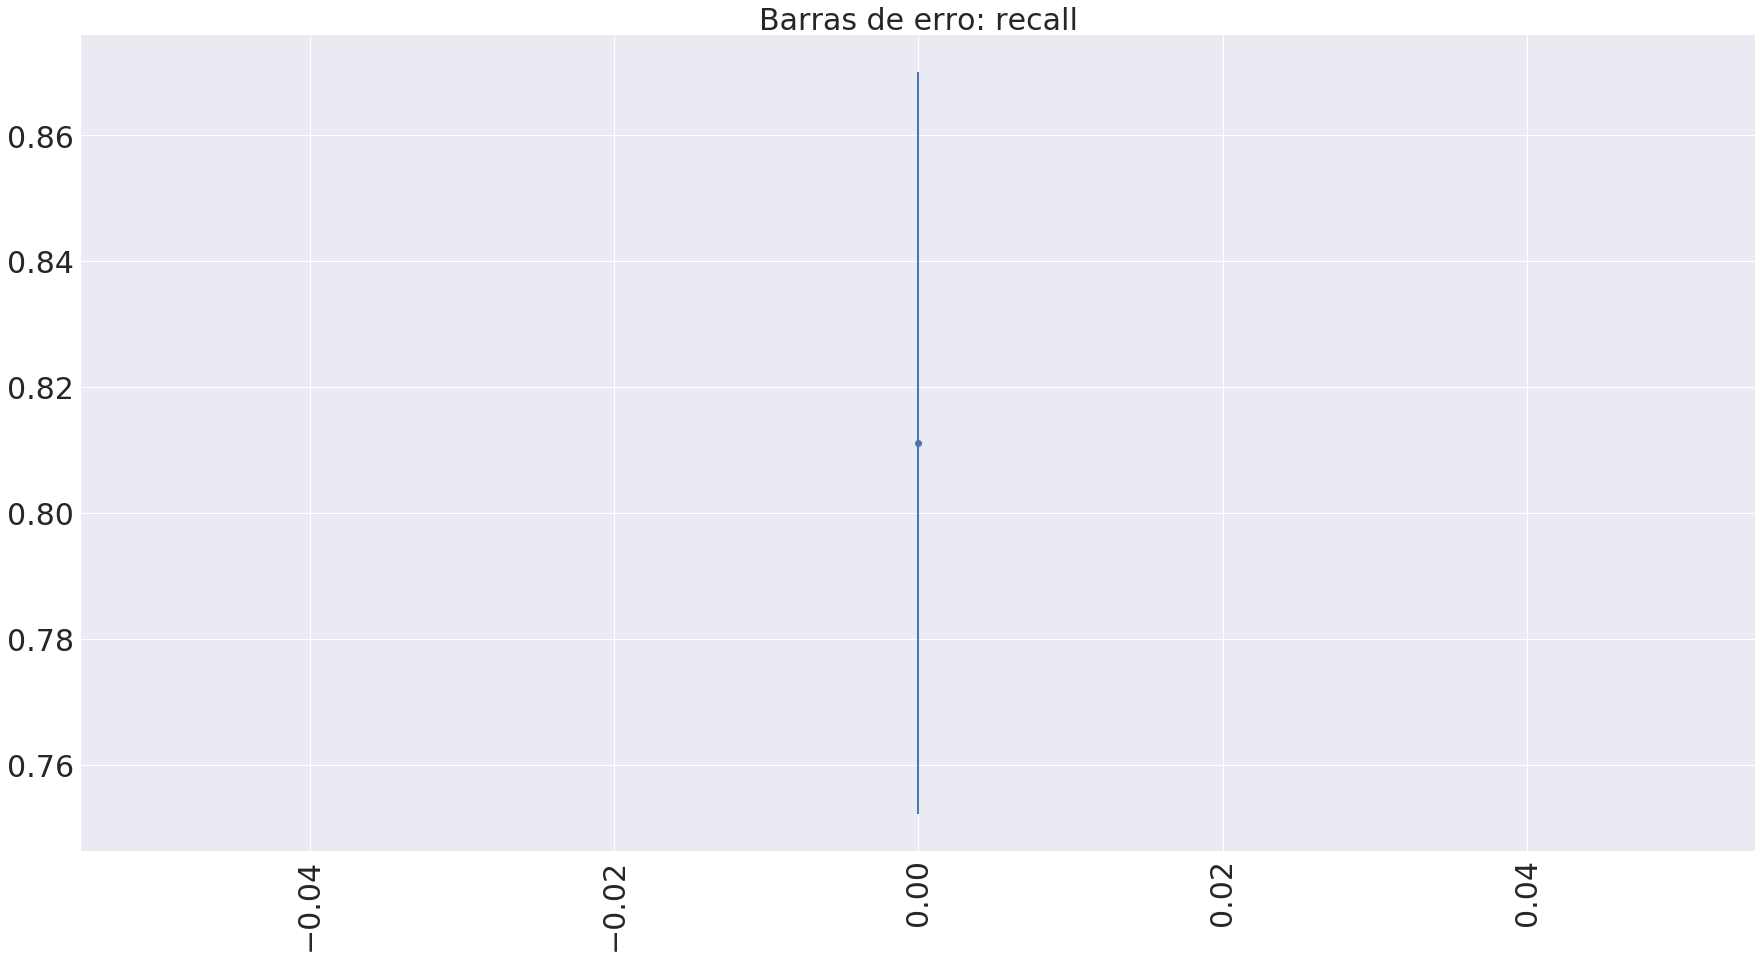

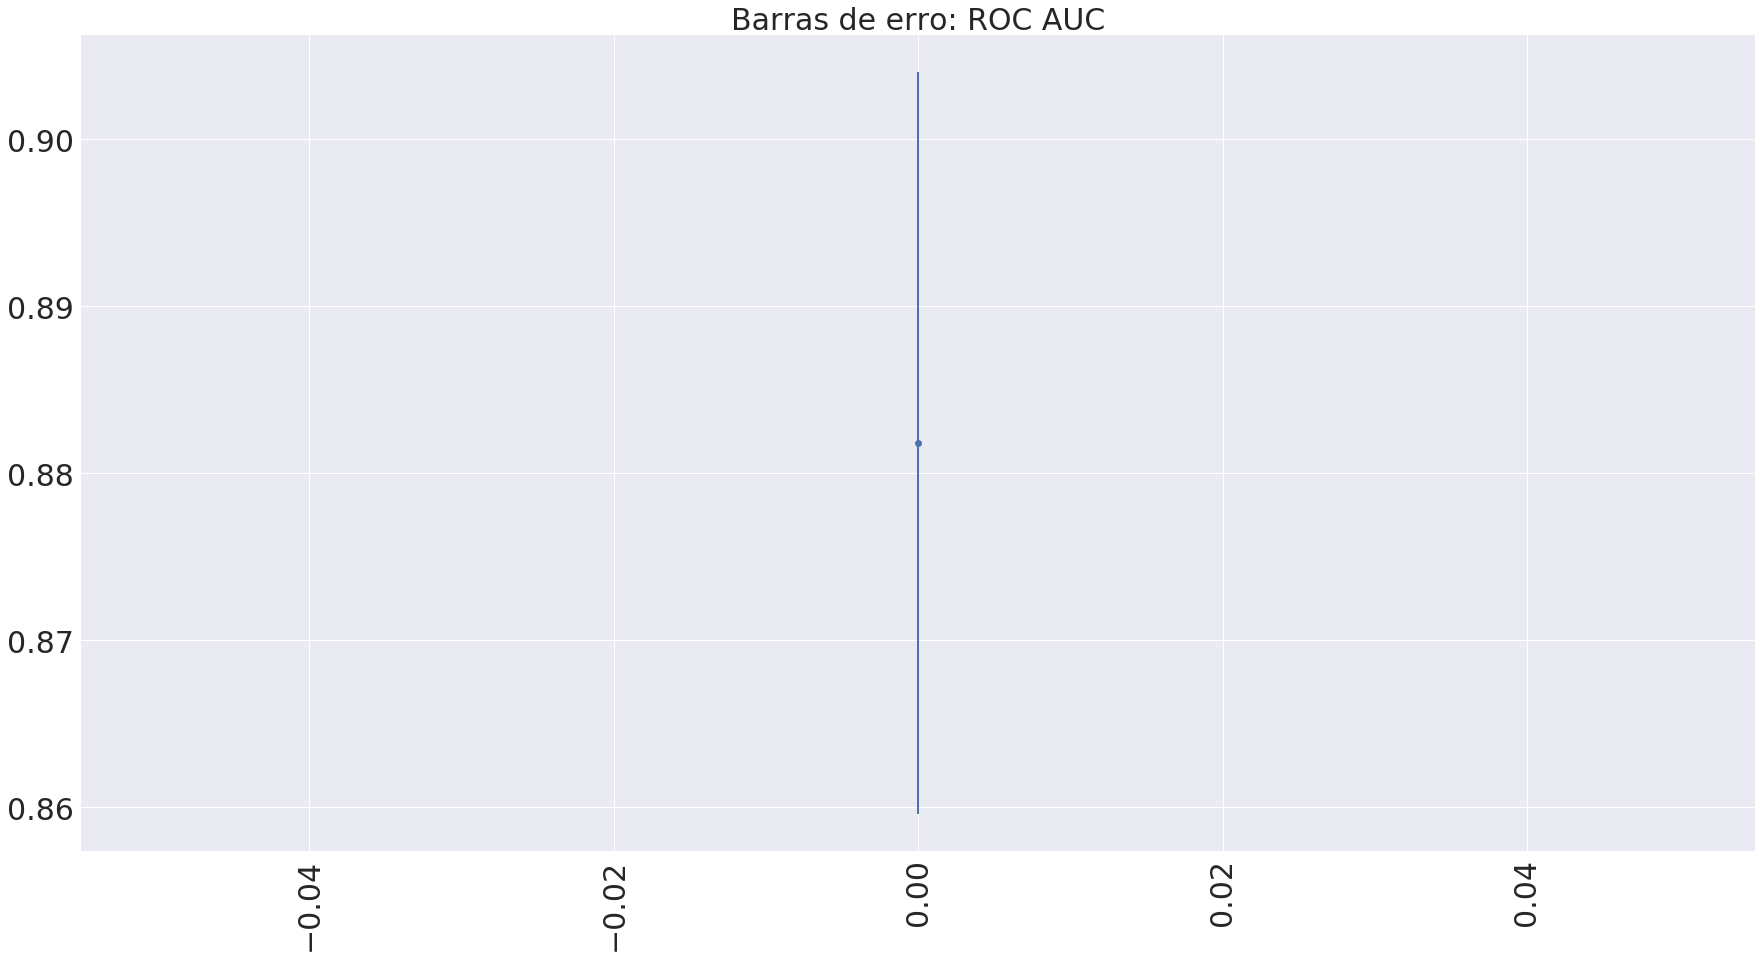

In [12]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_desbalanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_desbalanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


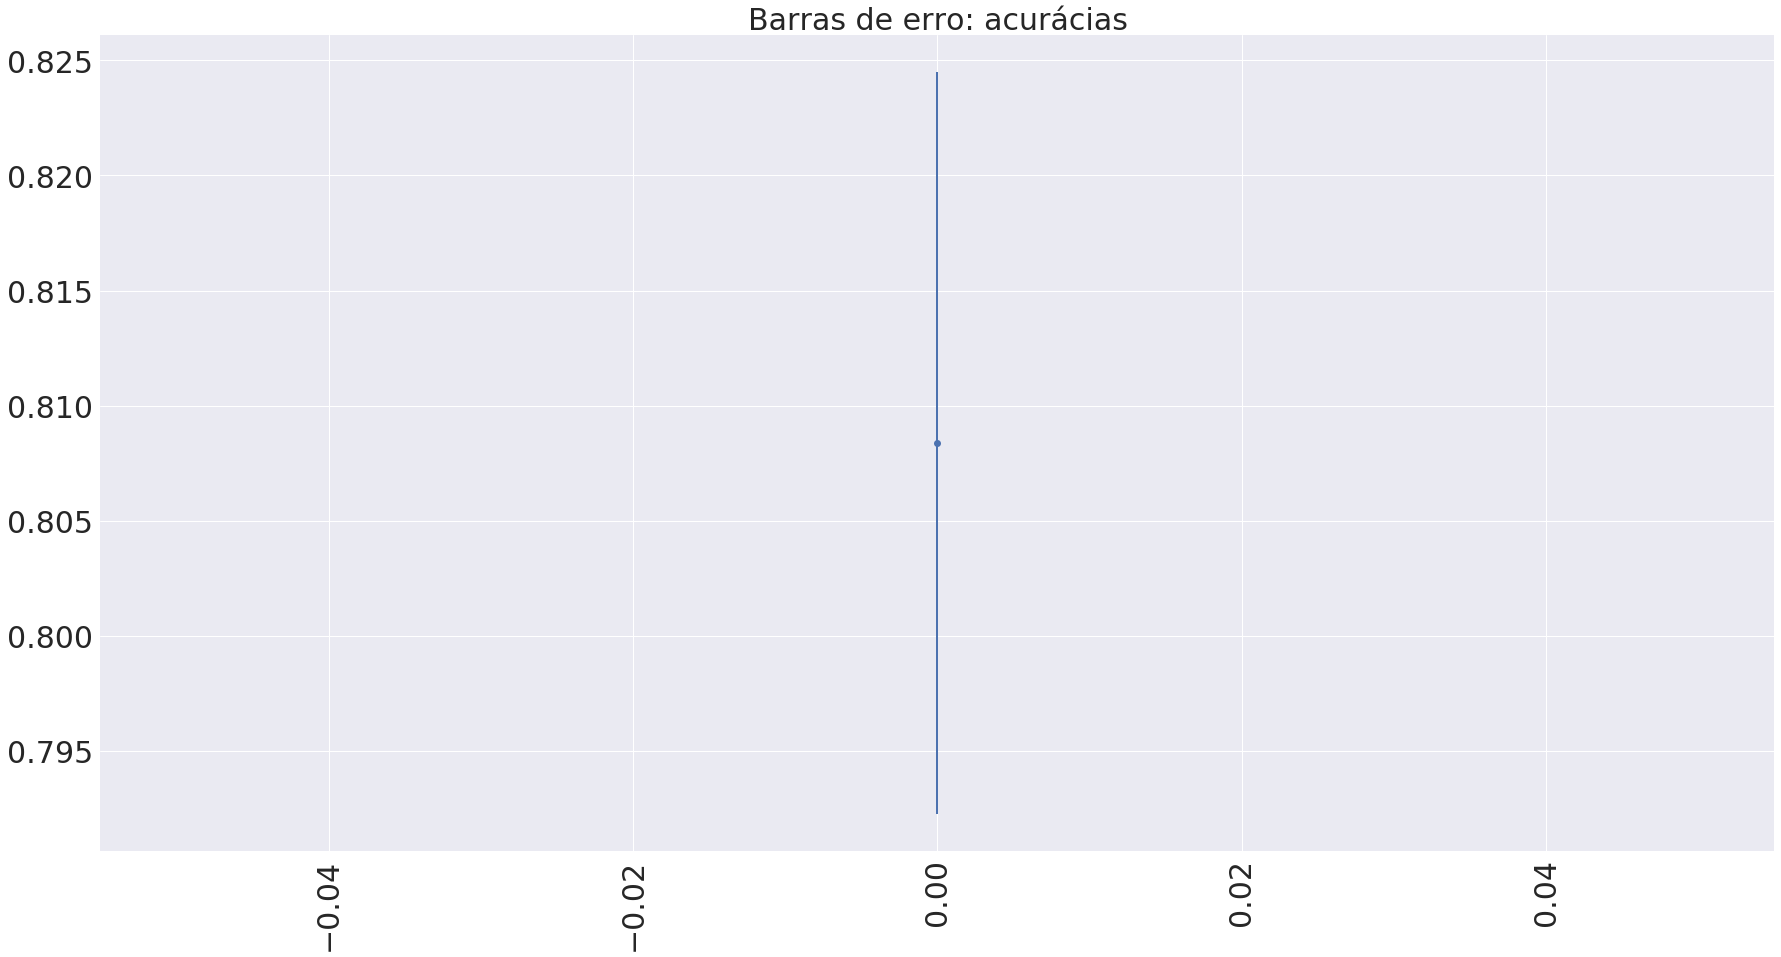

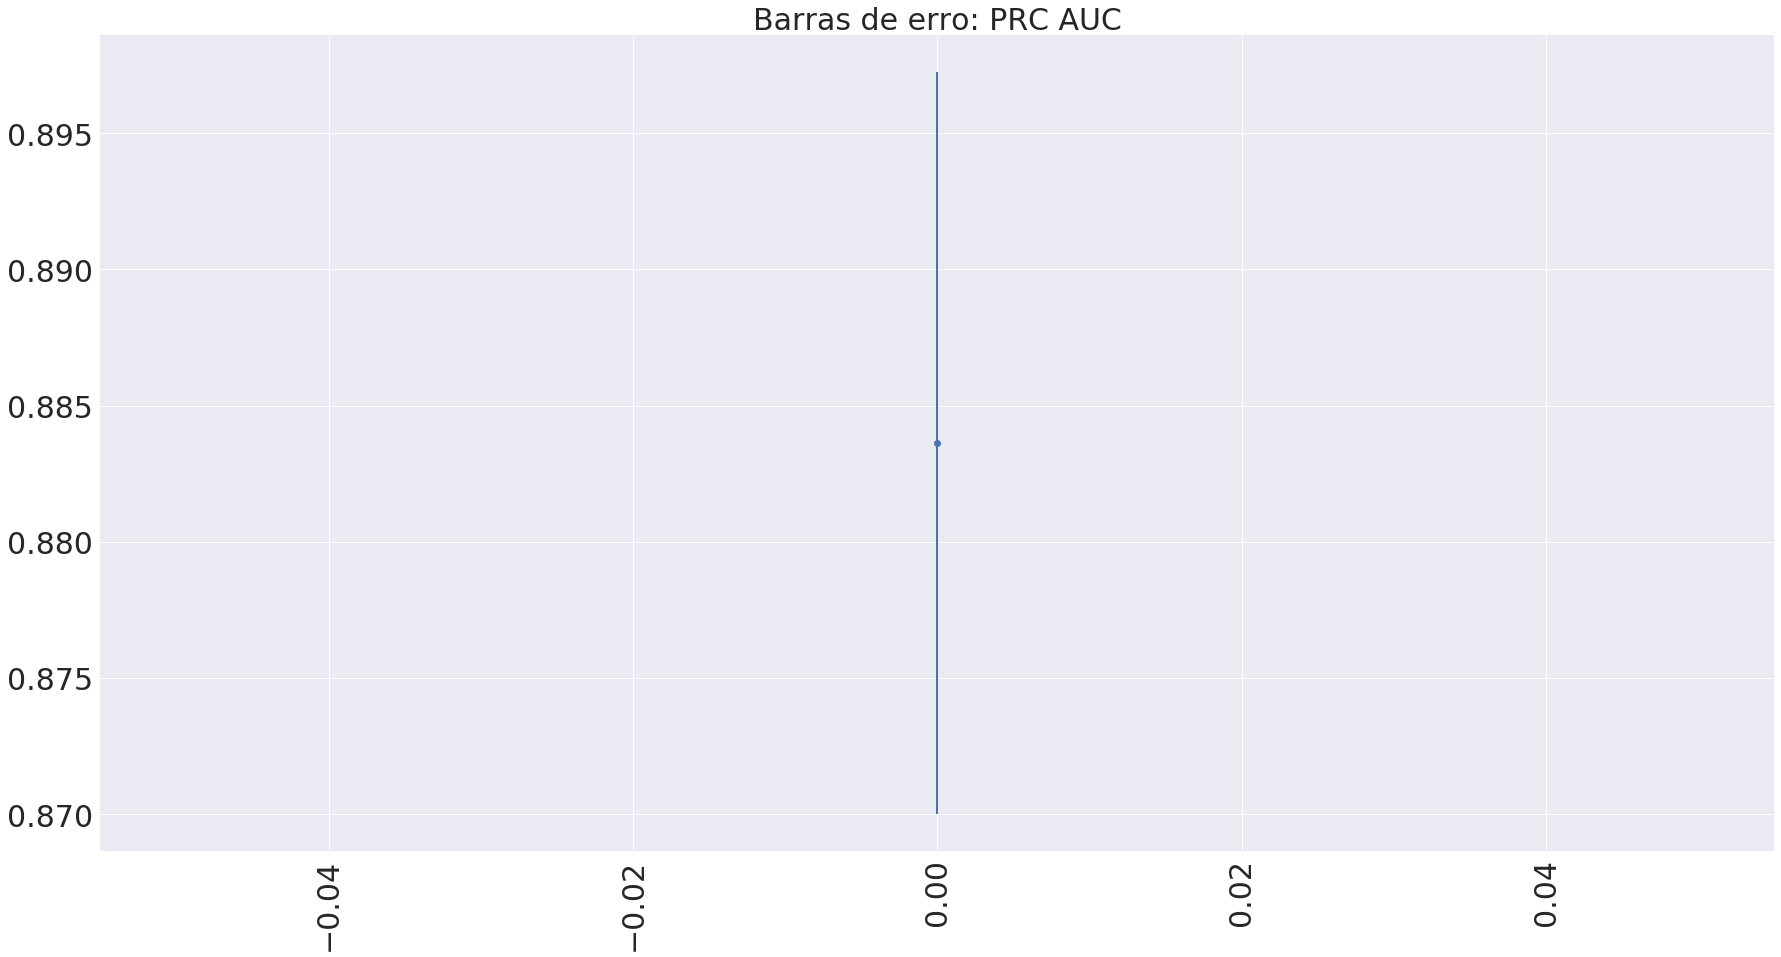

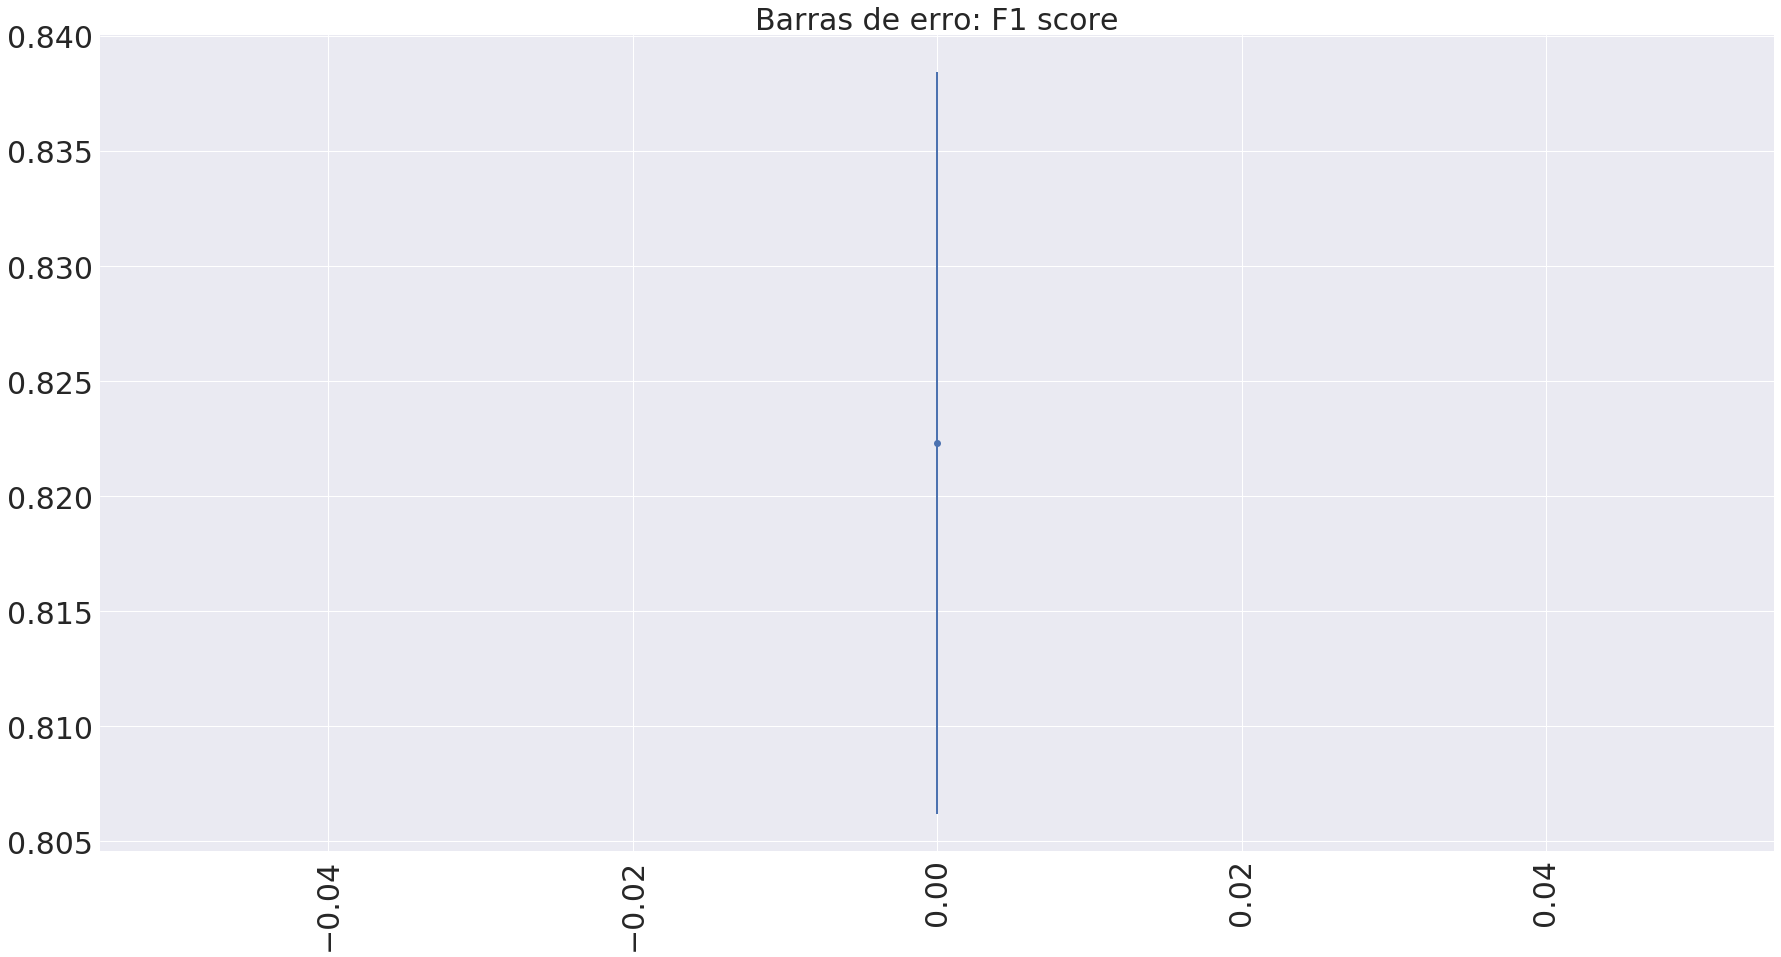

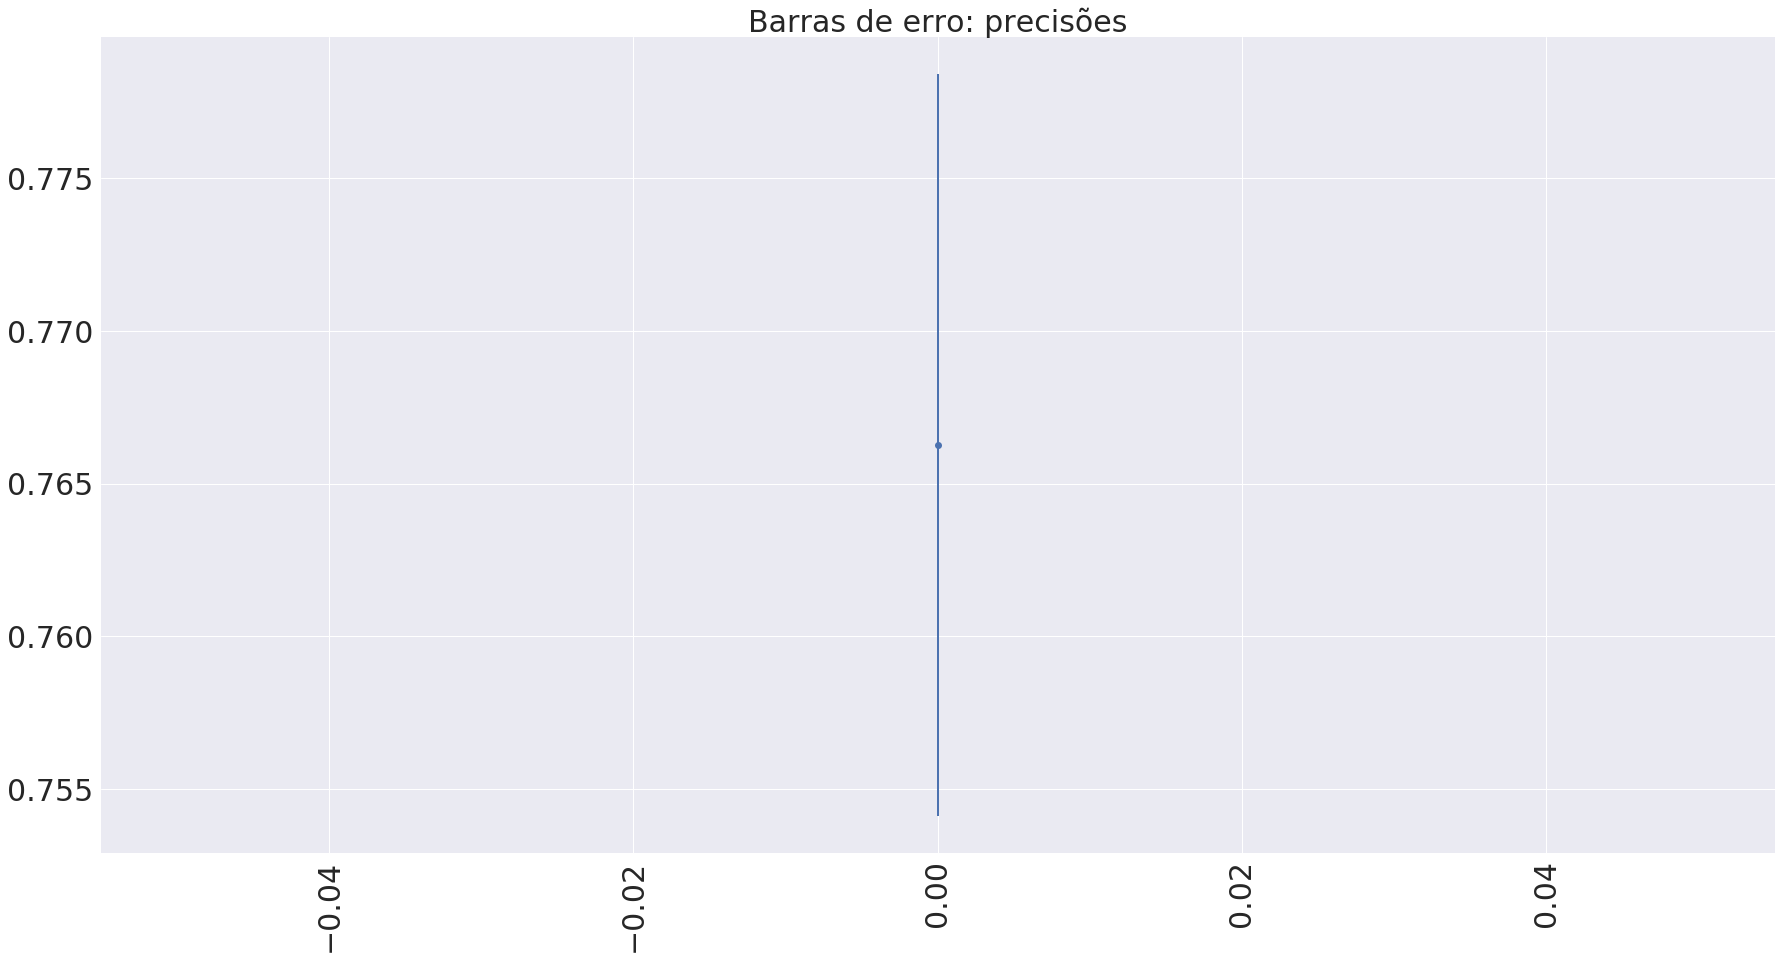

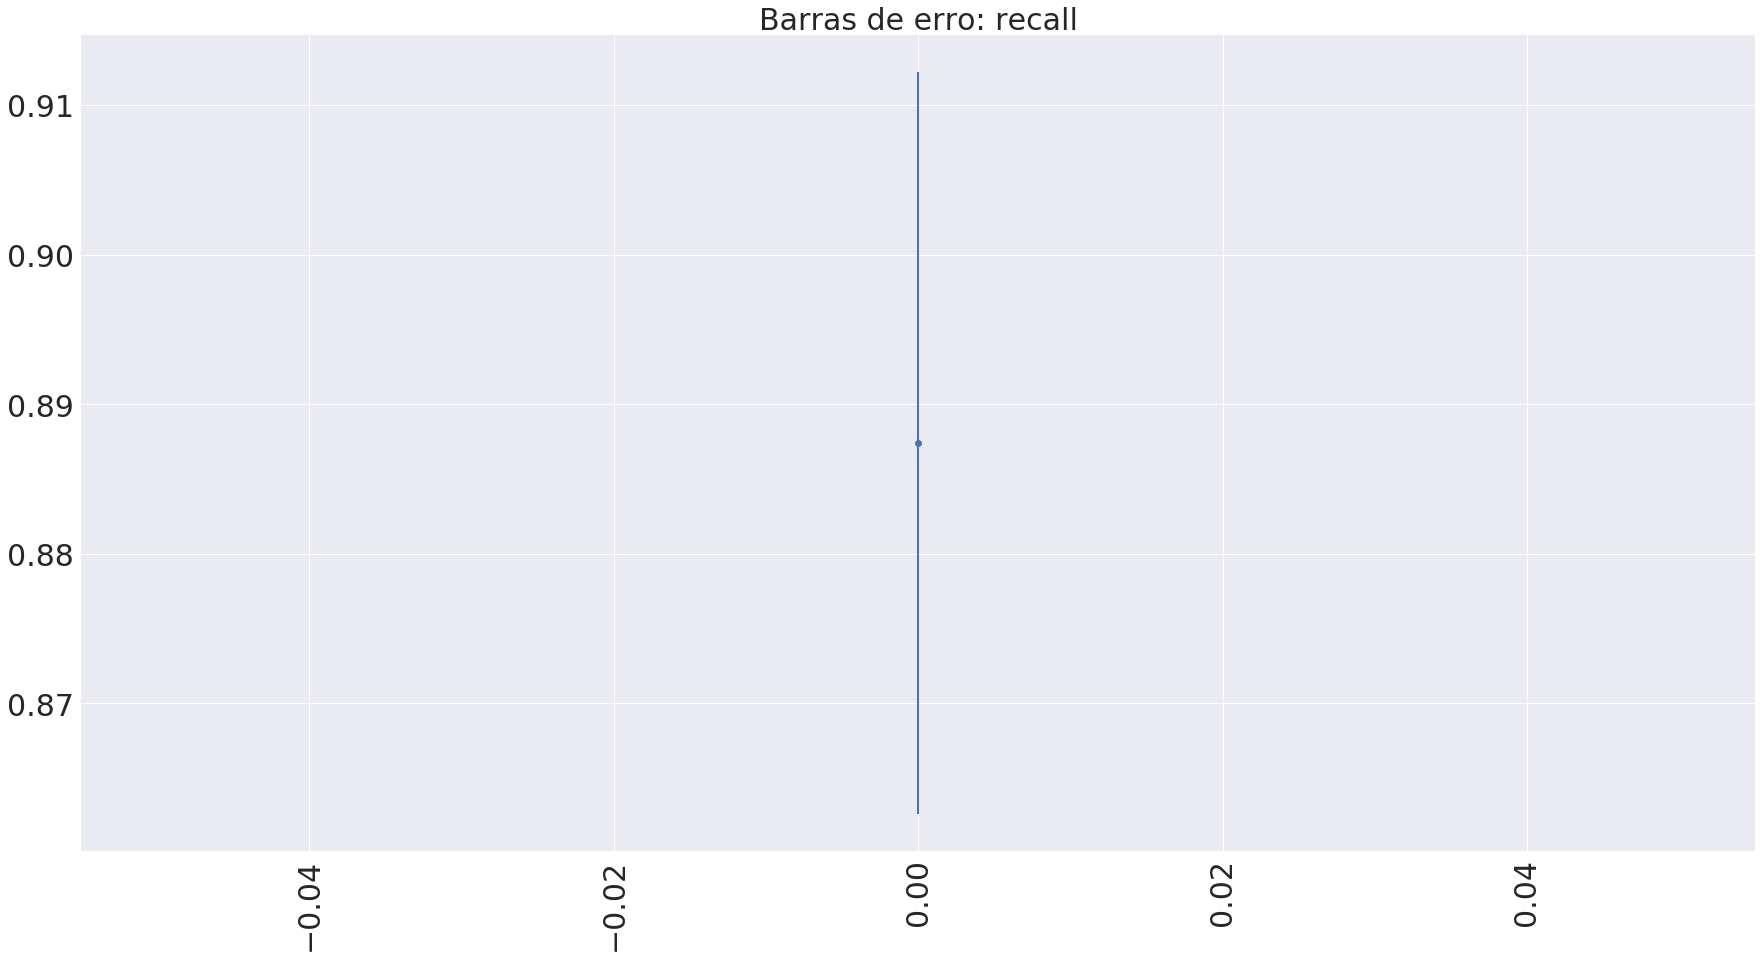

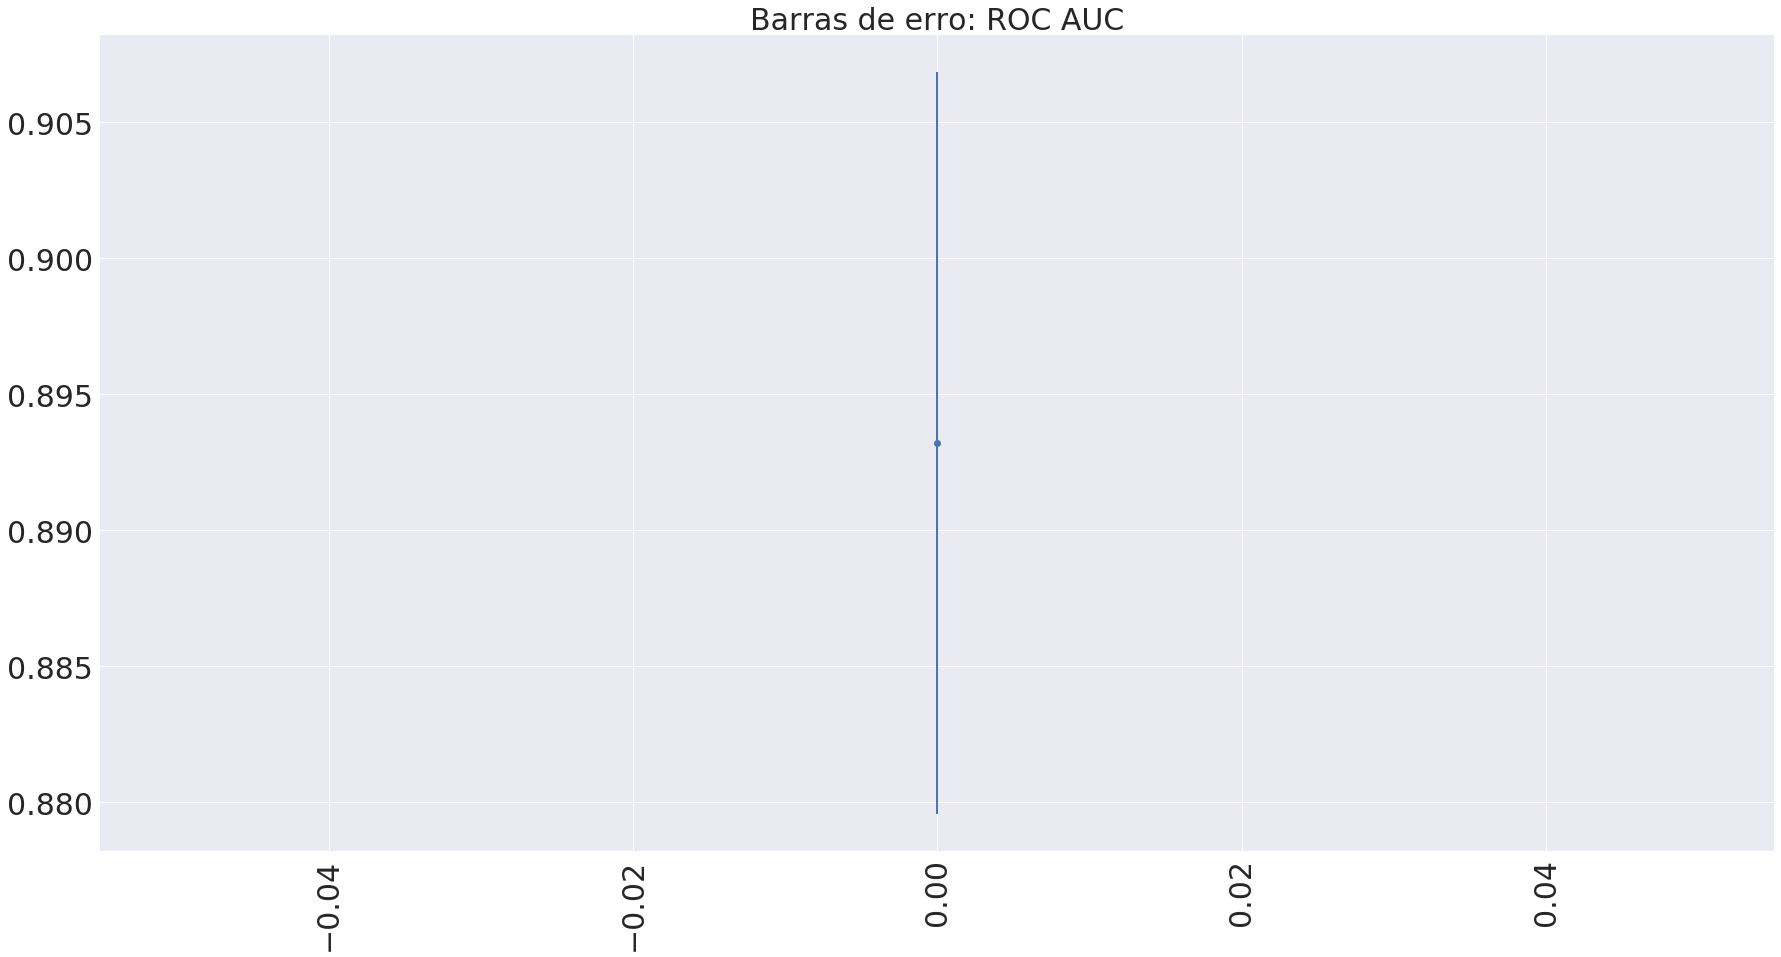

In [13]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_balanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_balanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [14]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_final = BernoulliNB(alpha=1, binarize=None, fit_prior=True, class_prior=None)

clf_bnb_final.fit(pd.get_dummies(train_data_2), train_target_2)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb_final.fit(pd.get_dummies(train_data_b_2), train_target_b_2)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-final-abordagem-2-balanceado-dataset-10pct.pkl']

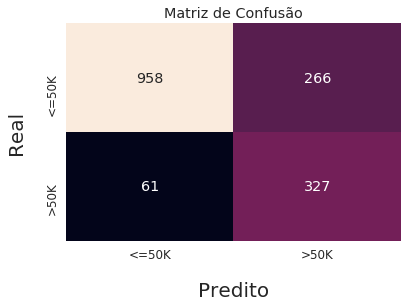

Acurácia: 79.715 %
Precisão: 55.143 %
Recall: 84.278 %
ROC AUC: 81.273 %
PRC AUC: 50.258 %


In [15]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_desbalanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_desbalanceado, 
                         test_data=pd.get_dummies(test_data_2), 
                         test_target=test_target_2, 
                         id_abordagem=2, 
                         str_balanceamento='desbalanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

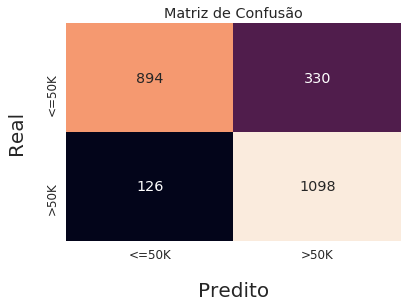

Acurácia: 81.373 %
Precisão: 76.891 %
Recall: 89.706 %
ROC AUC: 81.373 %
PRC AUC: 74.123 %


In [16]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_balanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_balanceado, 
                         test_data=pd.get_dummies(test_data_b_2), 
                         test_target=test_target_b_2, 
                         id_abordagem=2, 
                         str_balanceamento='balanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

In [17]:
# Abordagem 3: Imputar valores faltantes e retirar outliers

clf_bnb.fit(pd.get_dummies(train_data_3), train_target_3)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb.fit(pd.get_dummies(train_data_b_3), train_target_b_3)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-abordagem-3-balanceado-dataset-10pct.pkl']

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


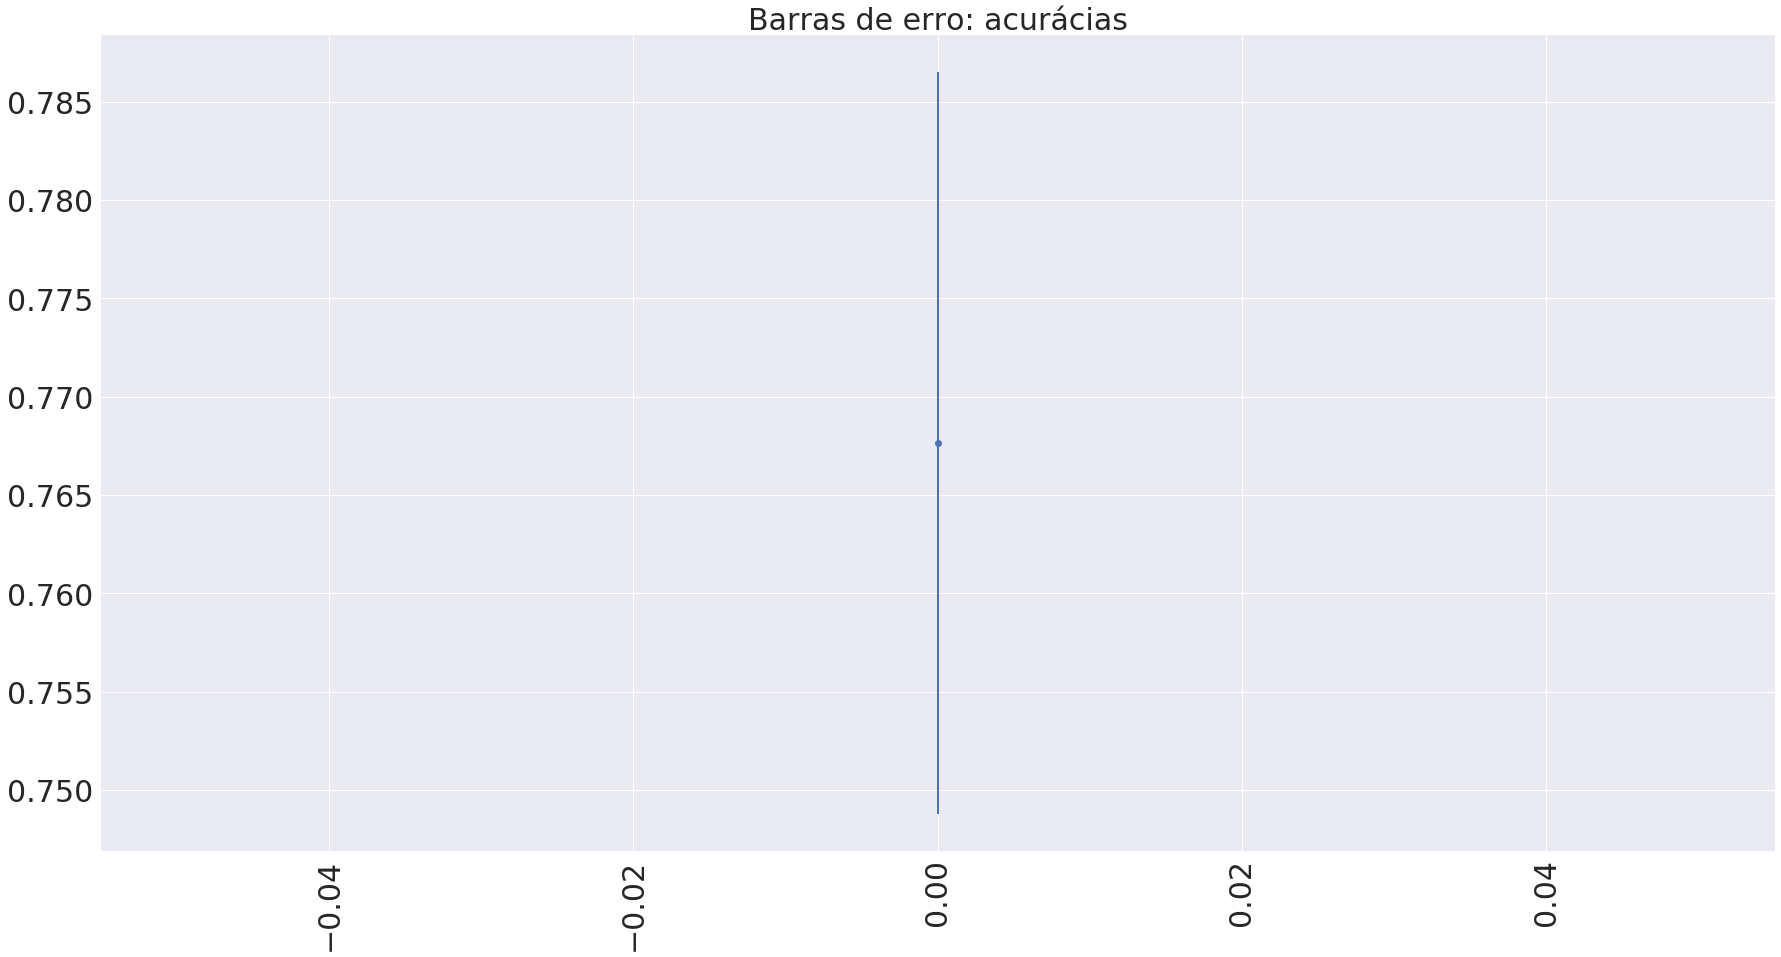

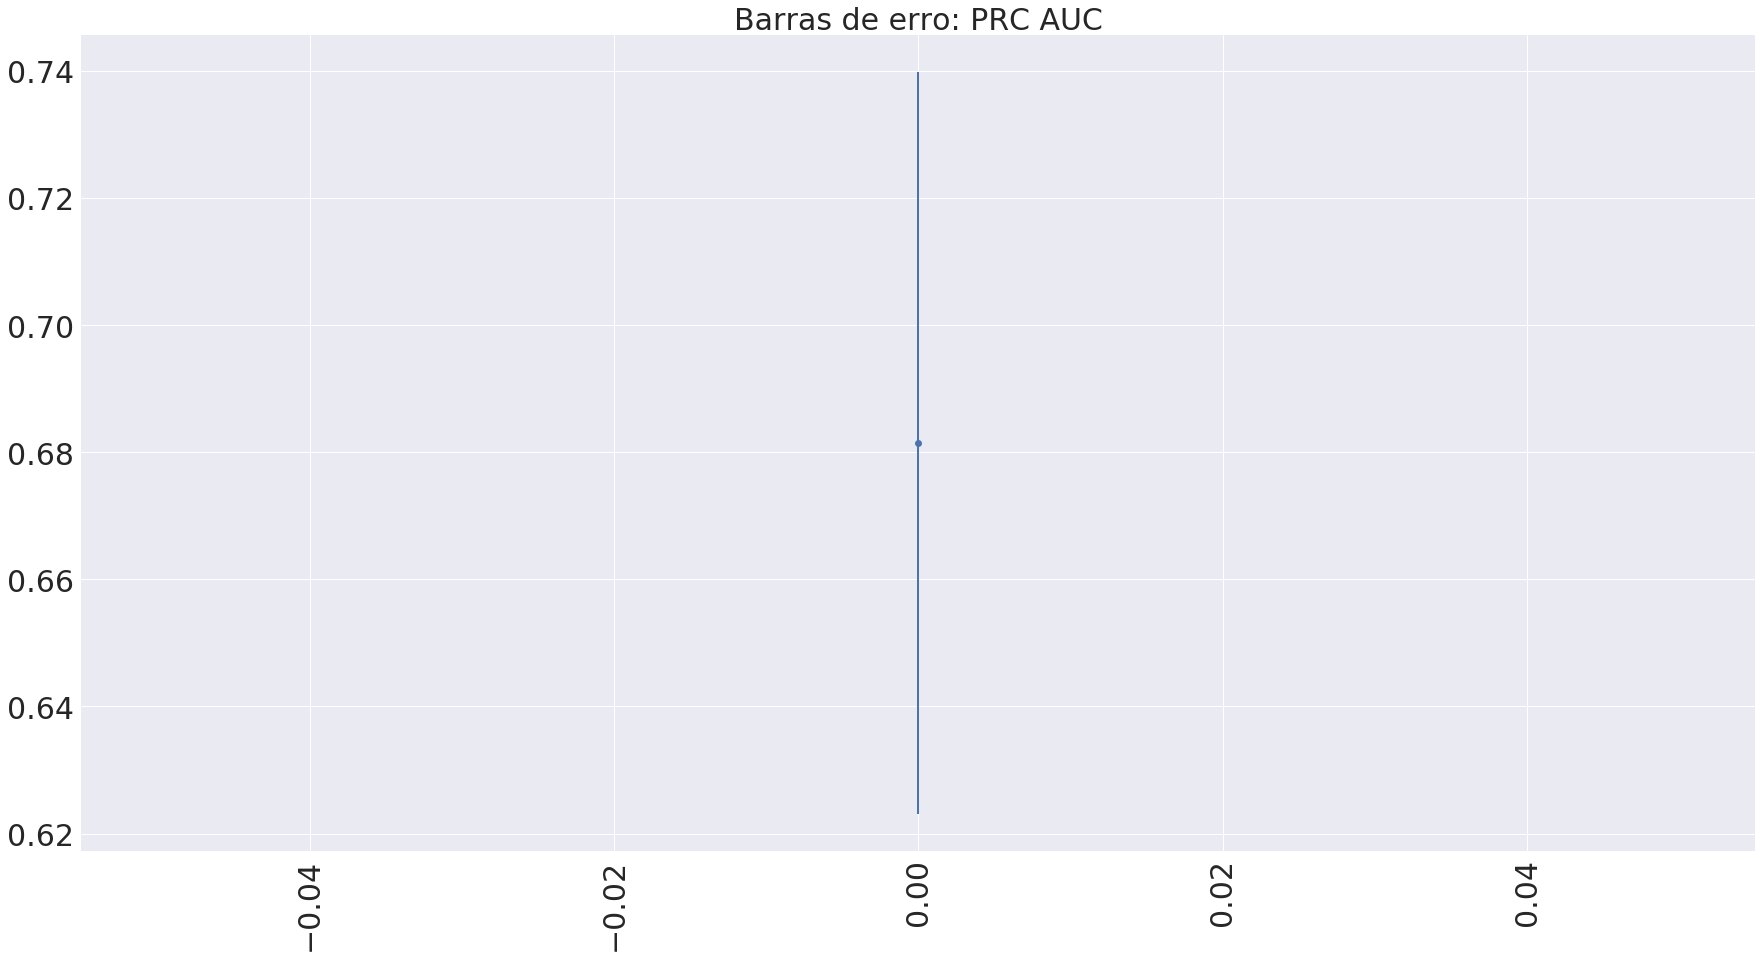

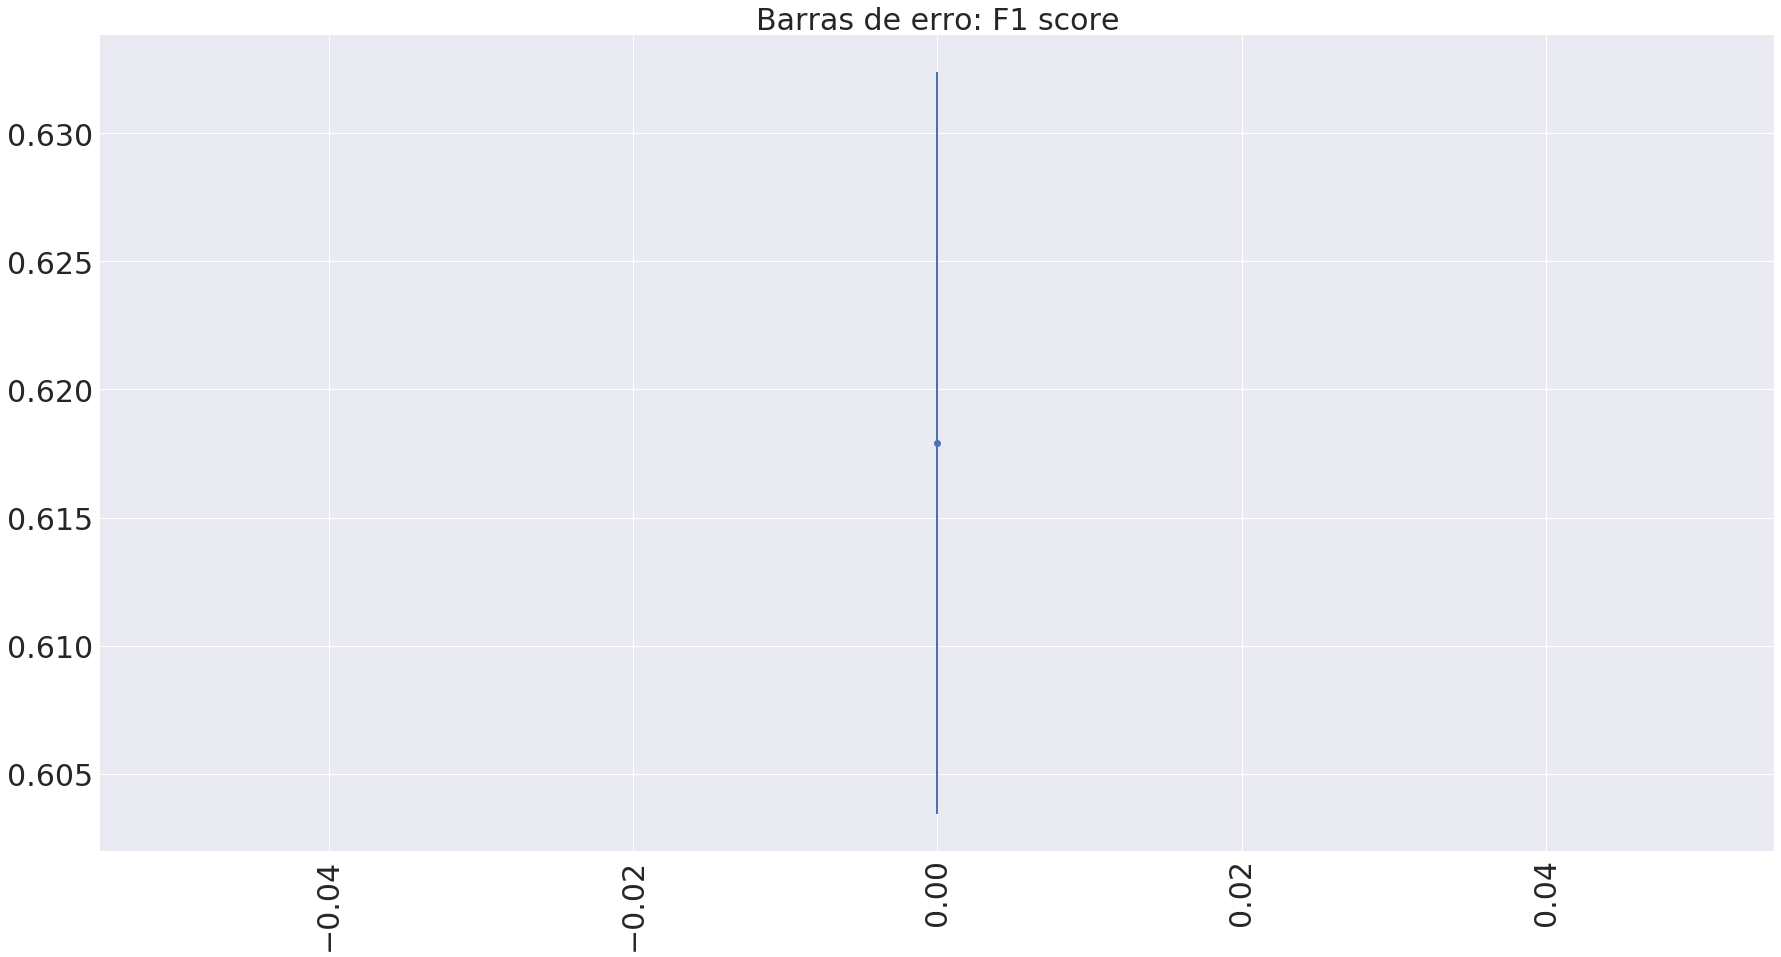

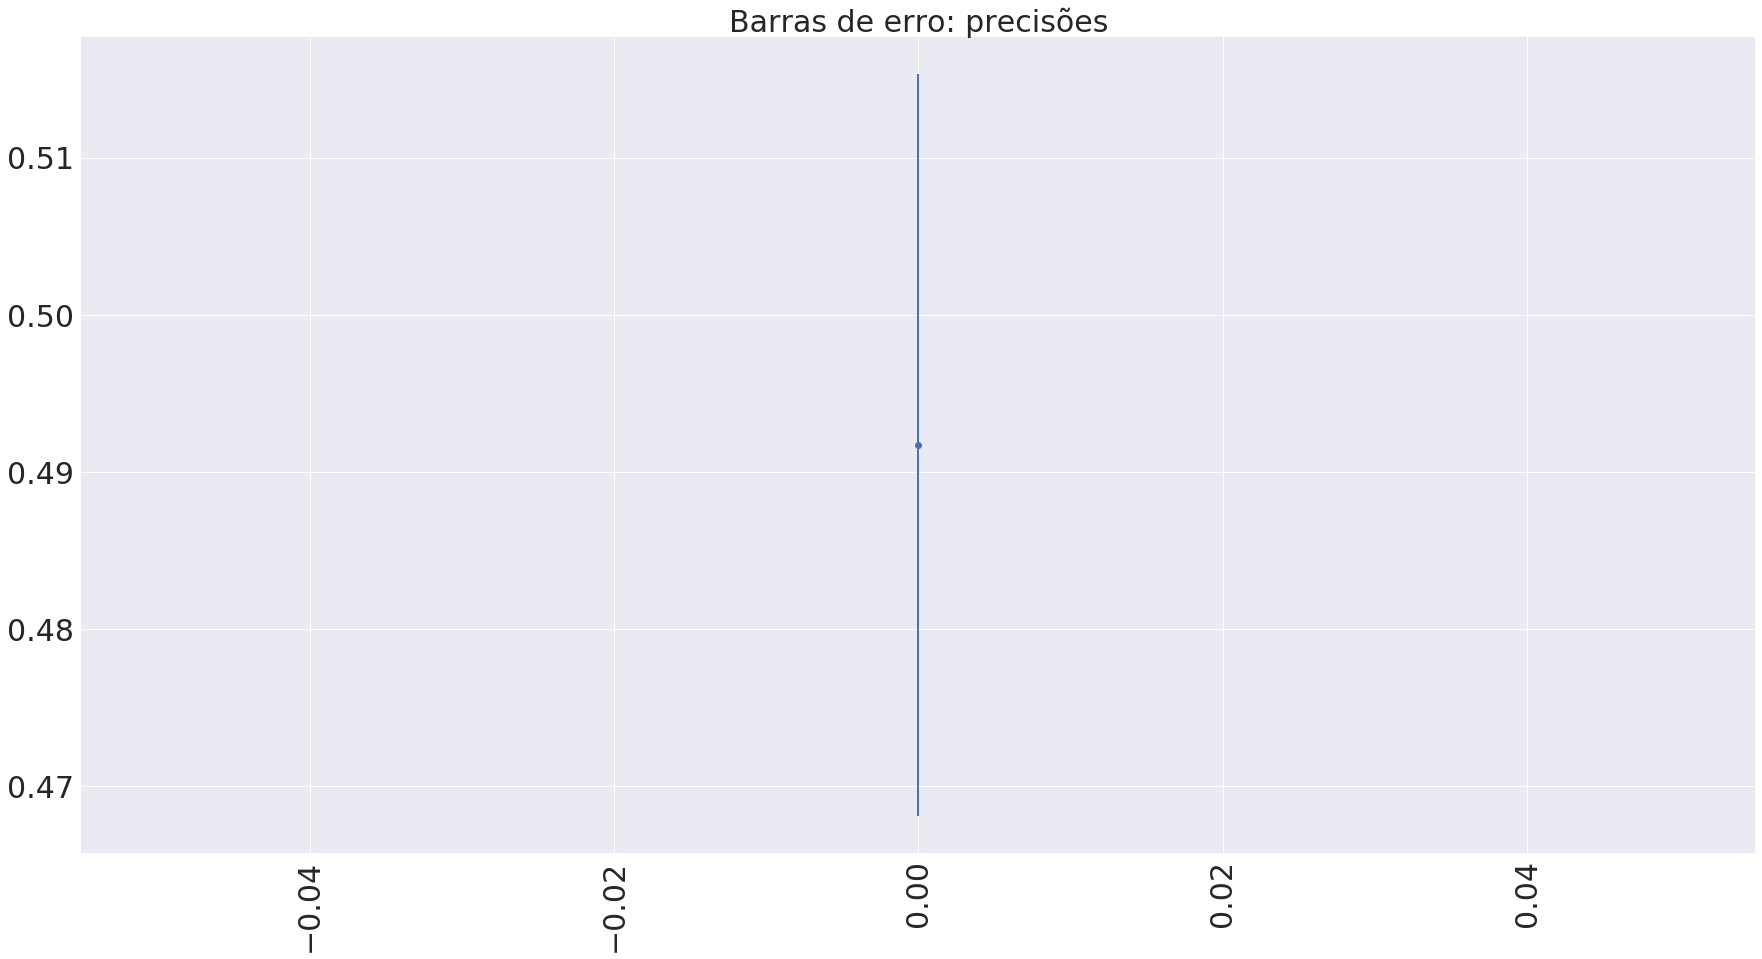

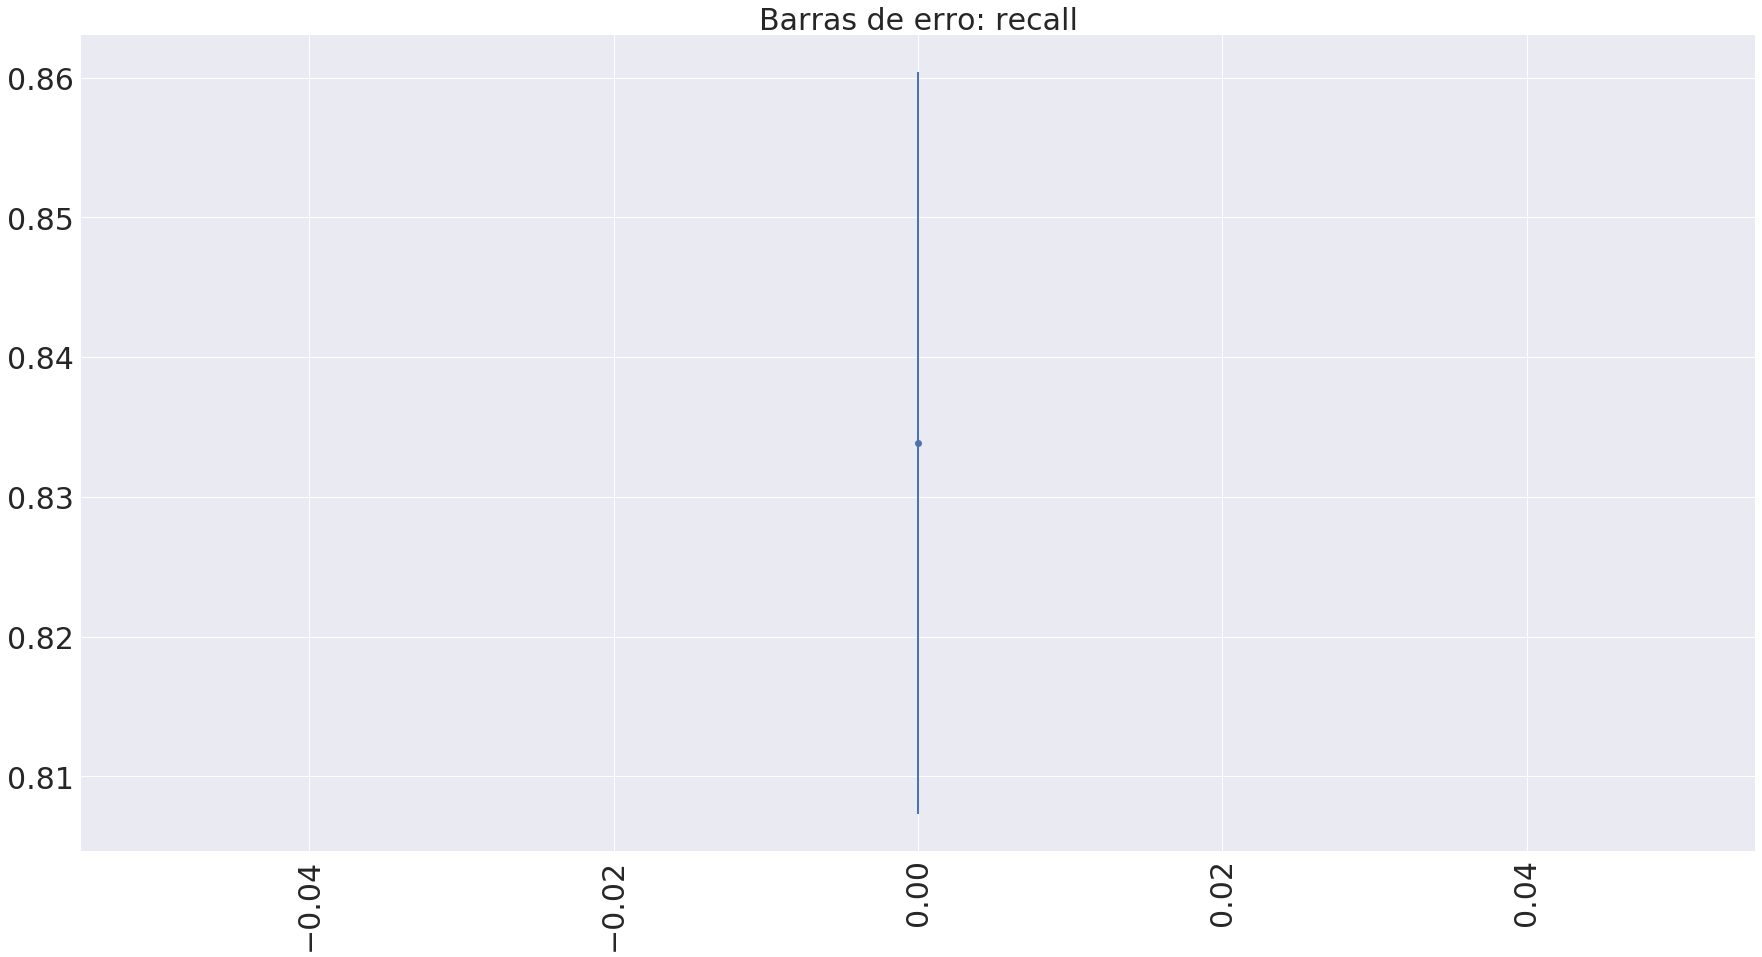

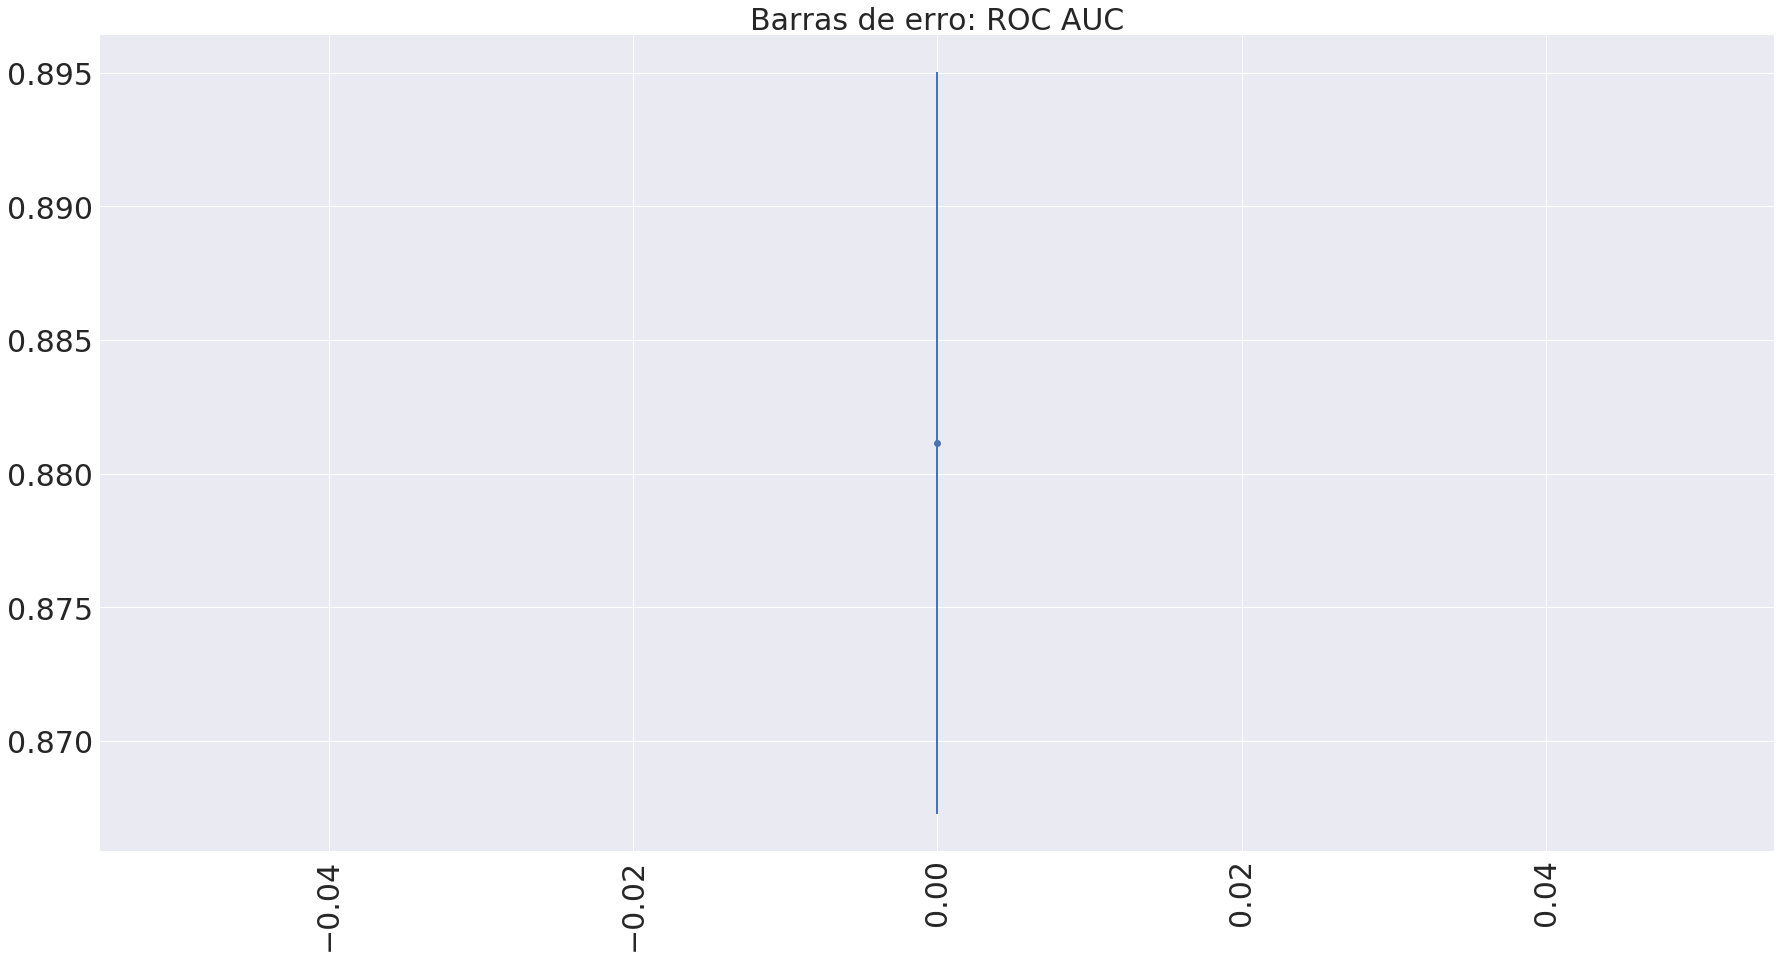

In [18]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_desbalanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_desbalanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


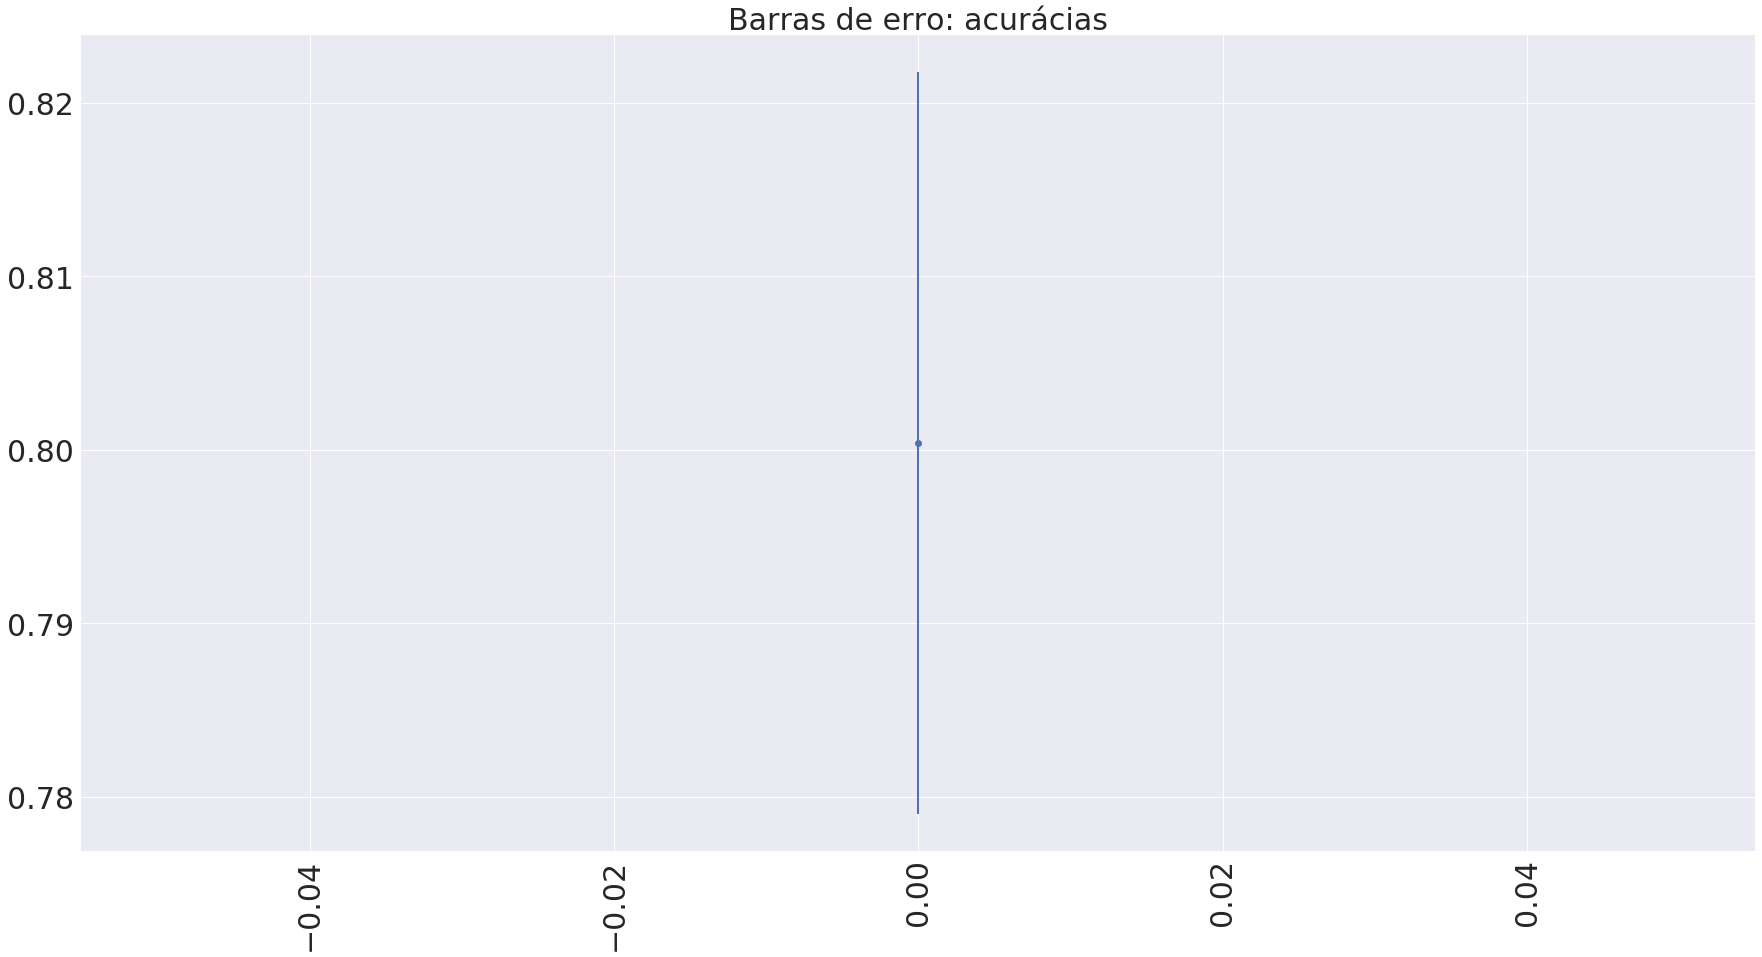

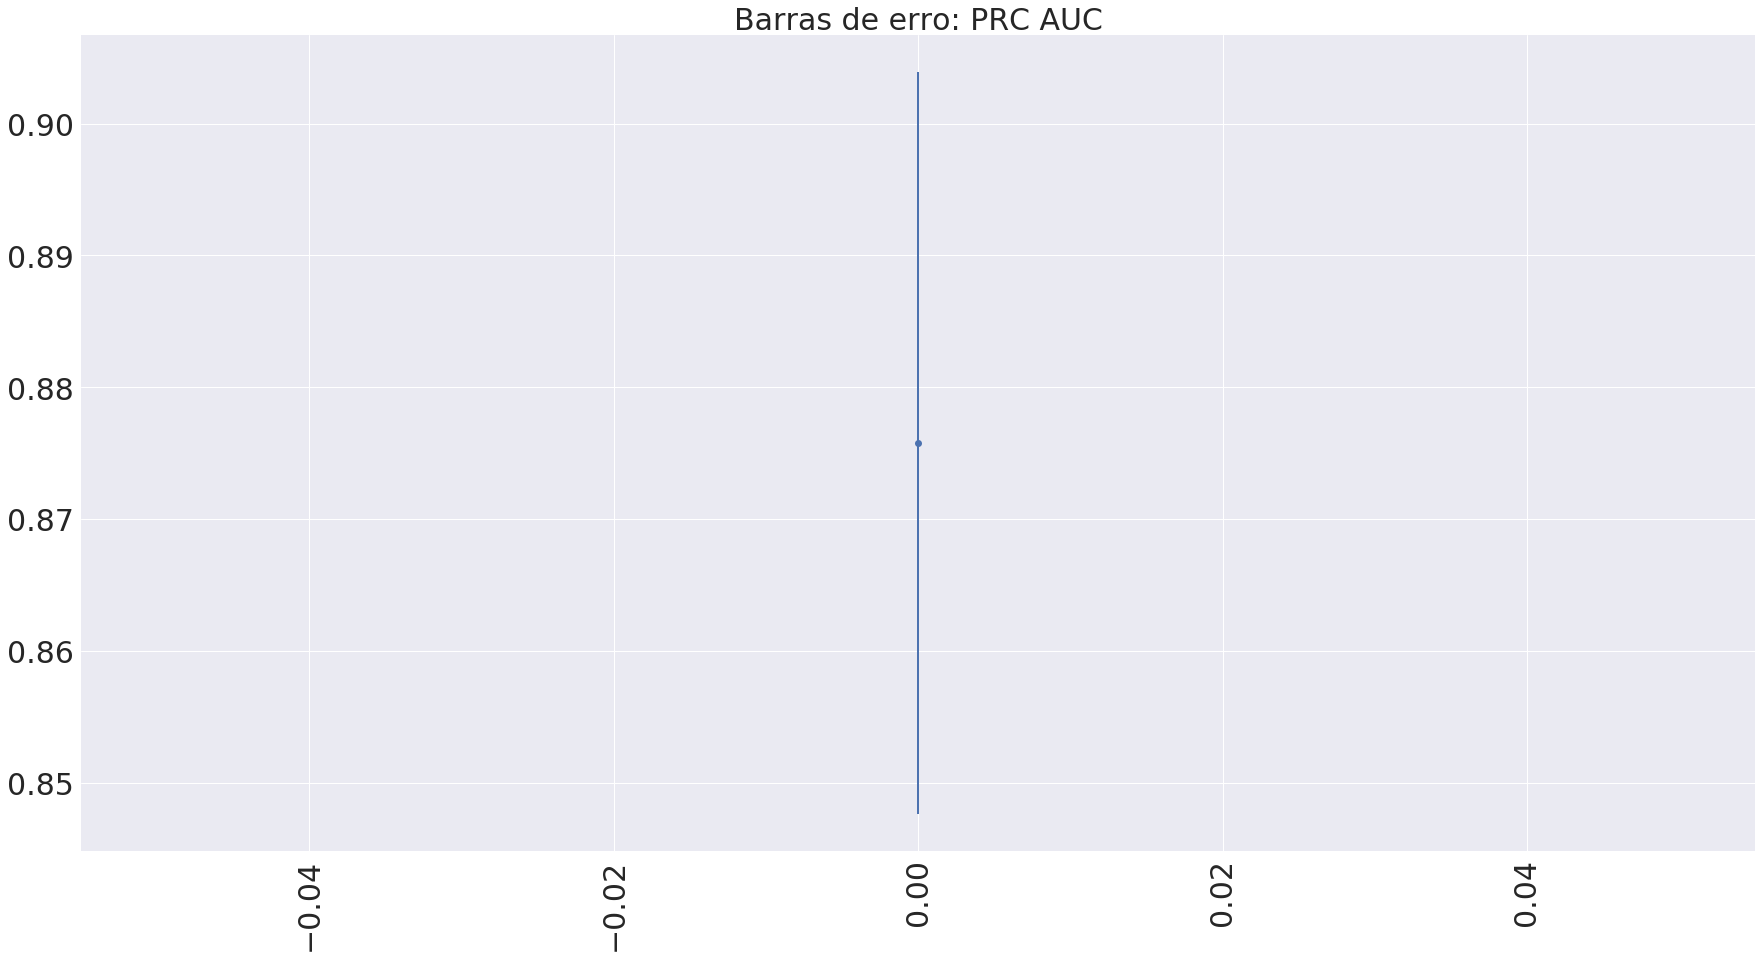

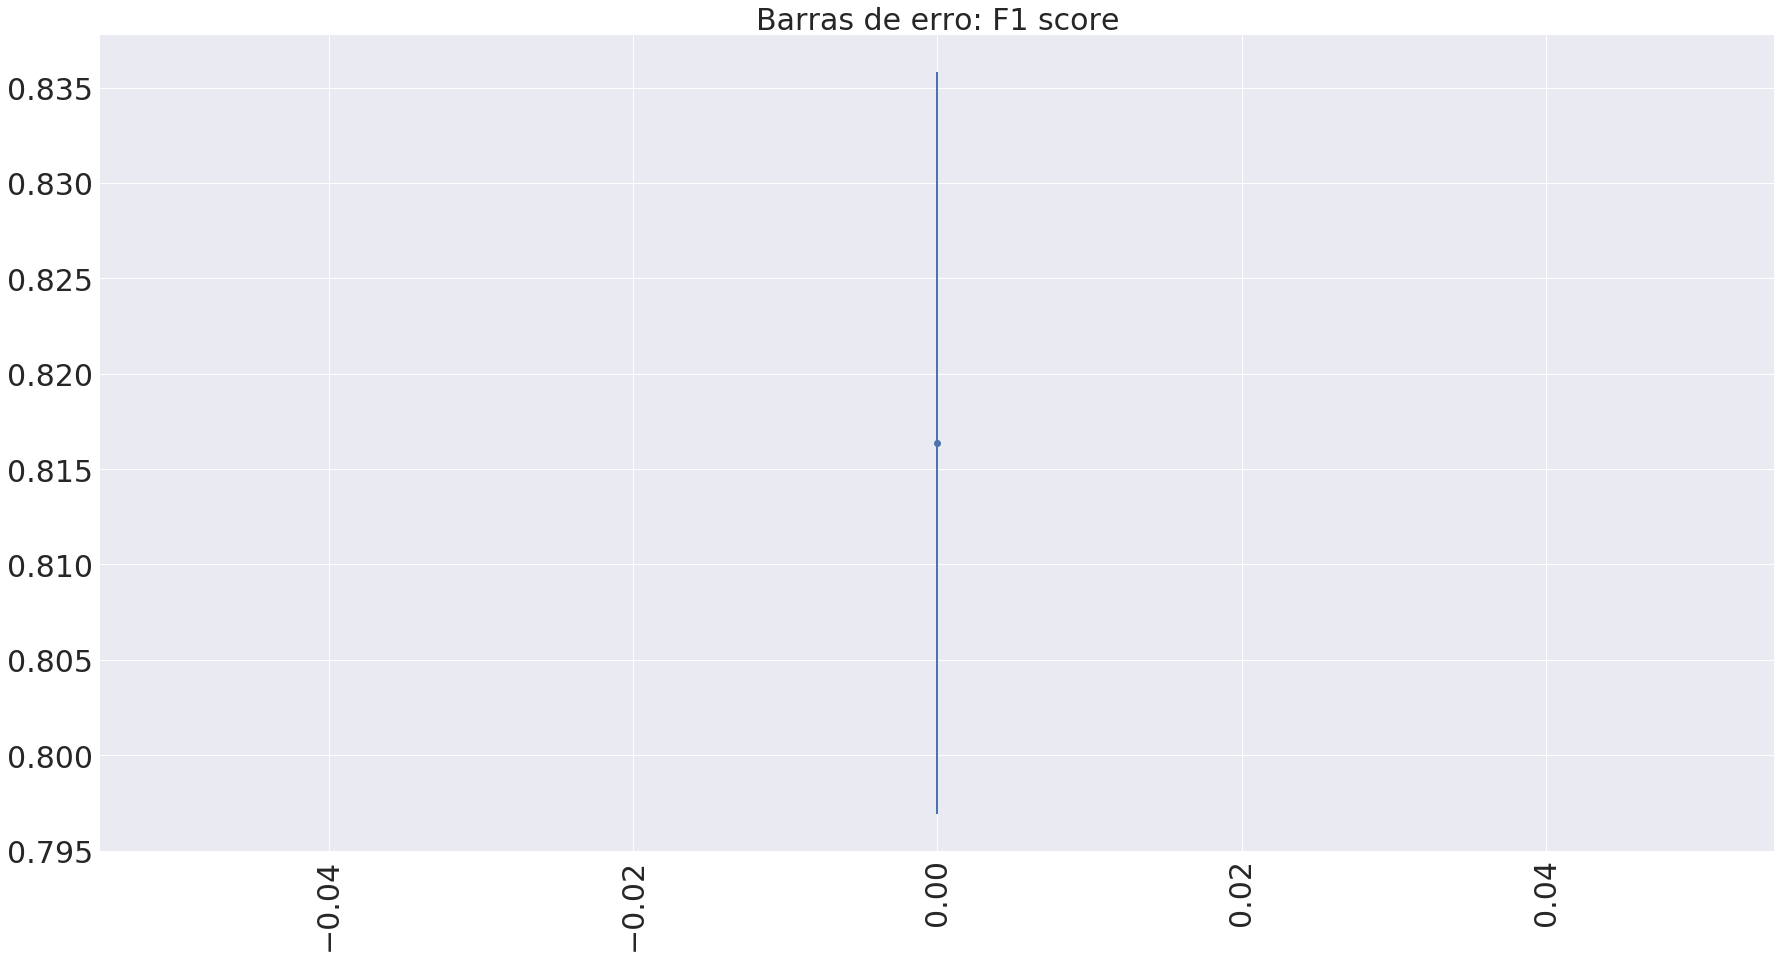

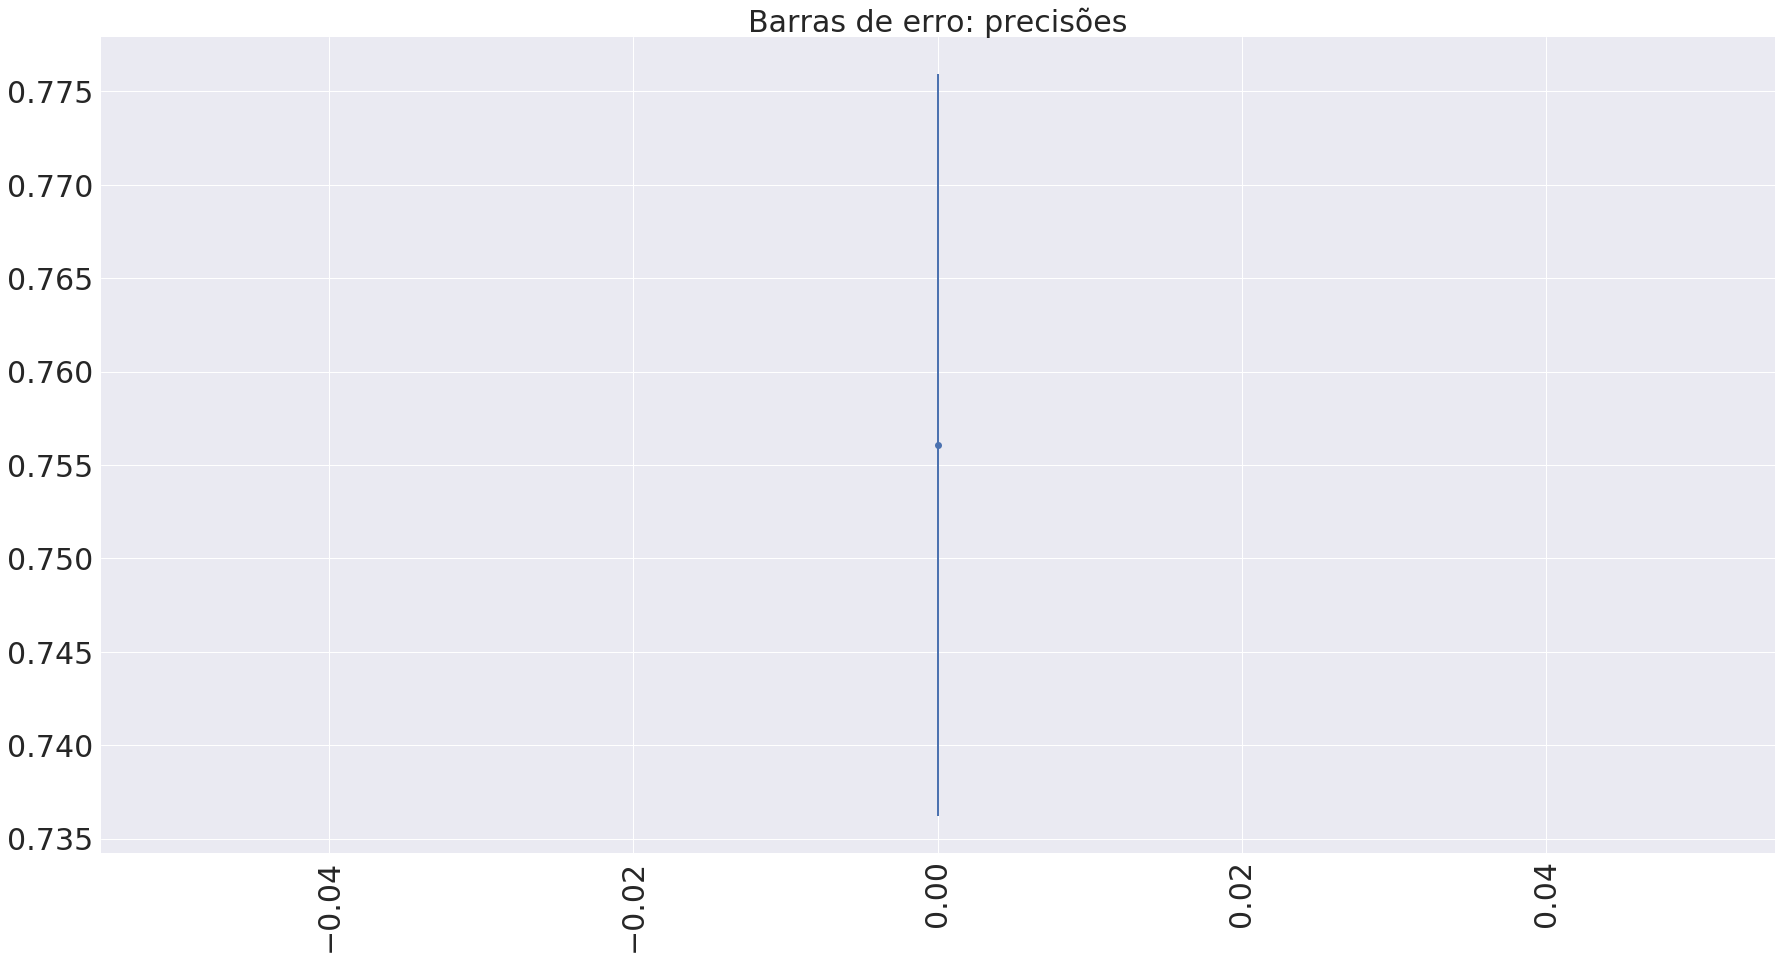

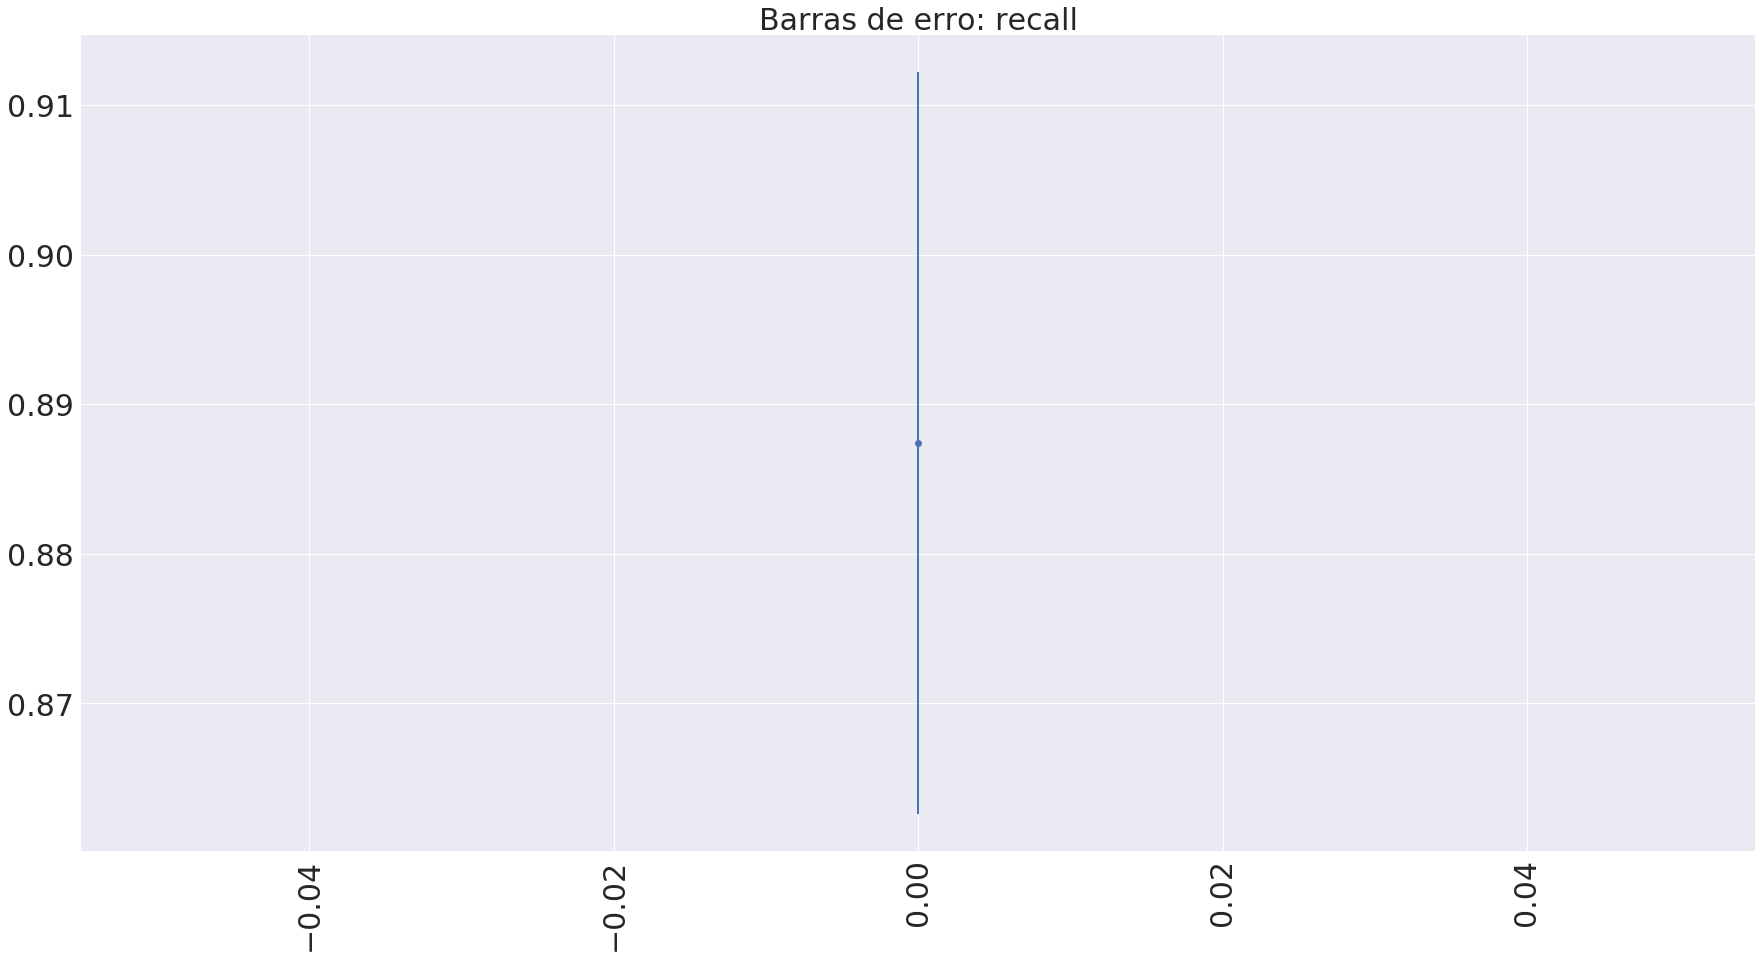

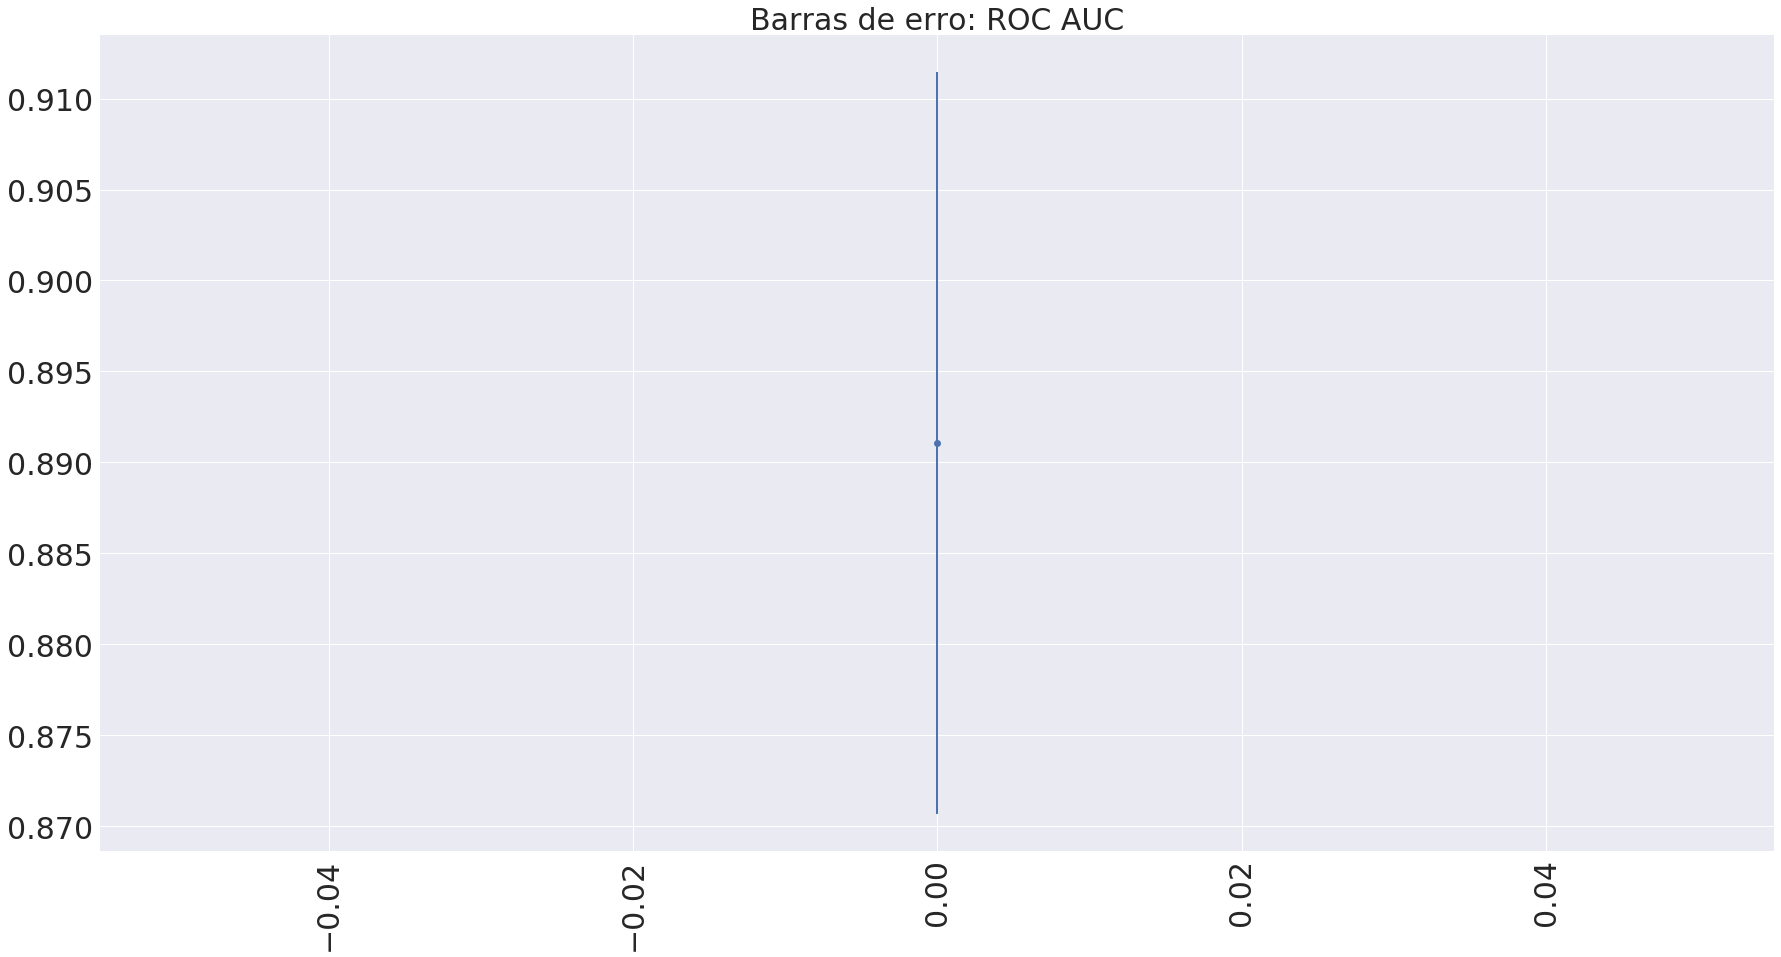

In [19]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_balanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_balanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [20]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_final = BernoulliNB(alpha=1, binarize=None, fit_prior=True, class_prior=None)

clf_bnb_final.fit(pd.get_dummies(train_data_3), train_target_3)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb_final.fit(pd.get_dummies(train_data_b_3), train_target_b_3)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-final-abordagem-3-balanceado-dataset-10pct.pkl']

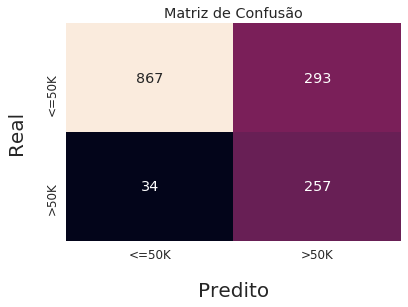

Acurácia: 77.464 %
Precisão: 46.727 %
Recall: 88.316 %
ROC AUC: 81.529 %
PRC AUC: 43.611 %


In [21]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_desbalanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-3-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_desbalanceado, 
                         test_data=pd.get_dummies(test_data_3), 
                         test_target=test_target_3, 
                         id_abordagem=3, 
                         str_balanceamento='desbalanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

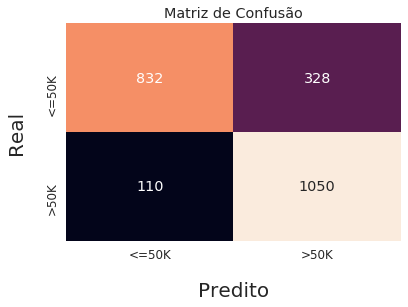

Acurácia: 81.121 %
Precisão: 76.197 %
Recall: 90.517 %
ROC AUC: 81.121 %
PRC AUC: 73.713 %


In [22]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_balanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-3-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_balanceado, 
                         test_data=pd.get_dummies(test_data_b_3), 
                         test_target=test_target_b_3, 
                         id_abordagem=3, 
                         str_balanceamento='balanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

In [23]:
# Abordagem 3: Retirar valores faltantes e retirar outliers

clf_bnb.fit(pd.get_dummies(train_data_4), train_target_4)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb.fit(pd.get_dummies(train_data_b_4), train_target_b_4)
joblib.dump(clf_bnb, 
            path_arquivos+'naive-bayes-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-abordagem-4-balanceado-dataset-10pct.pkl']

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


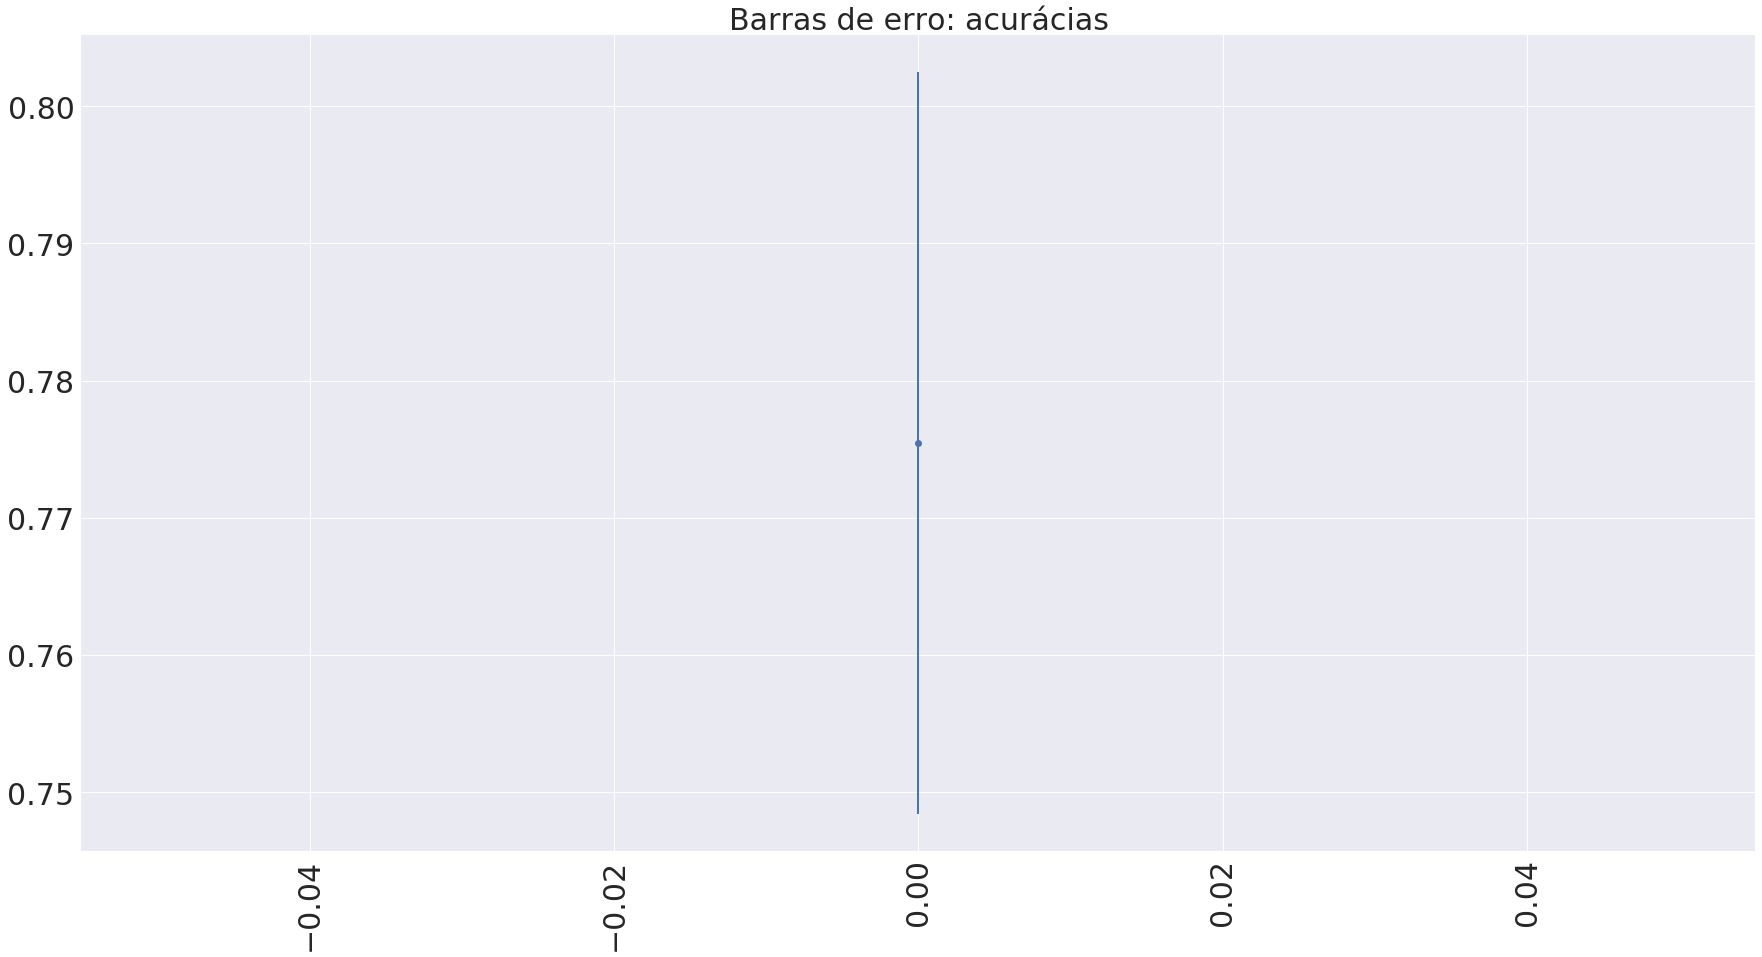

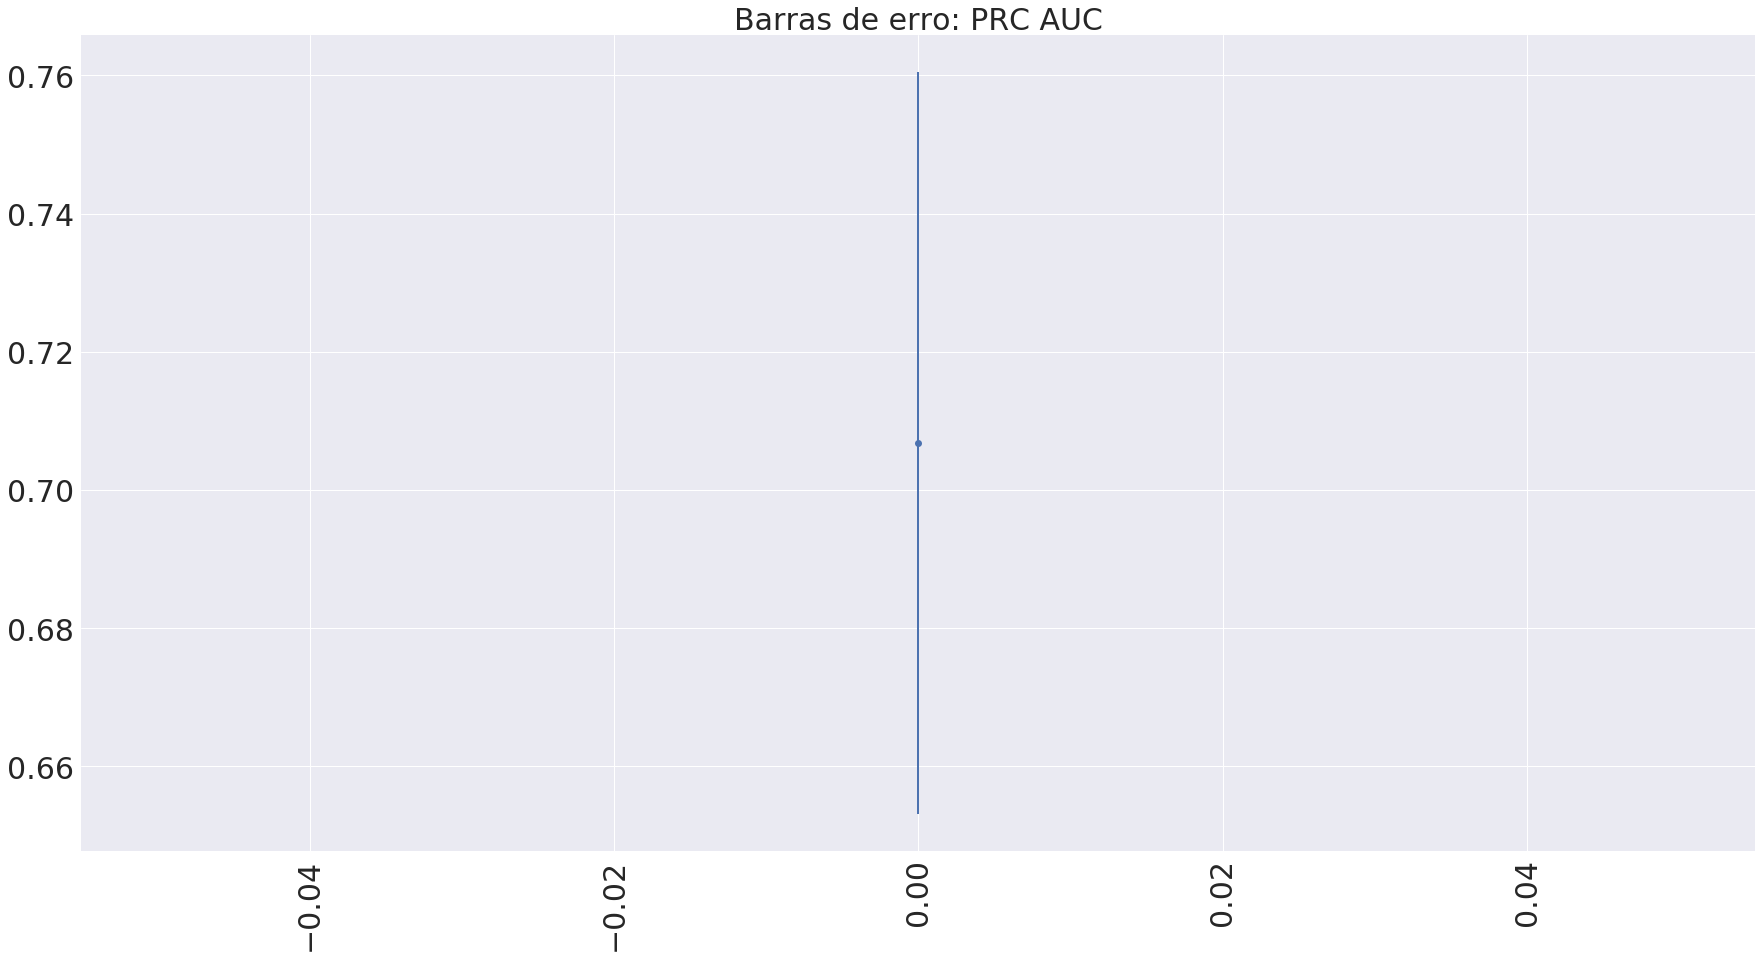

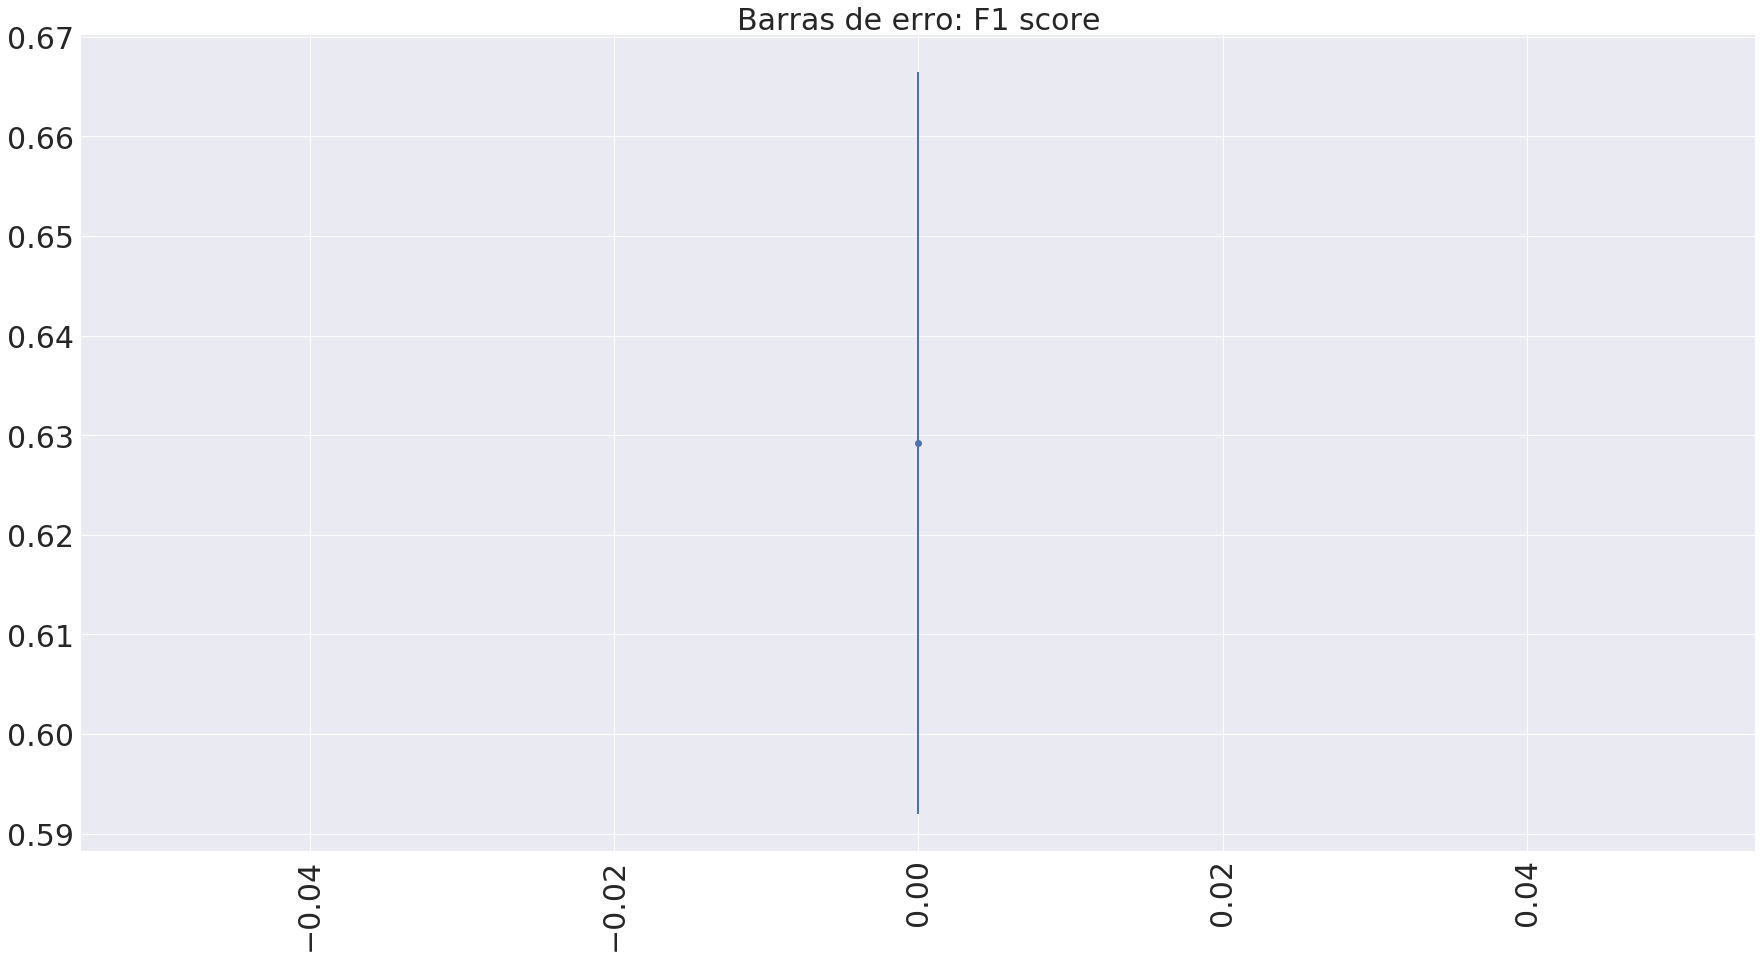

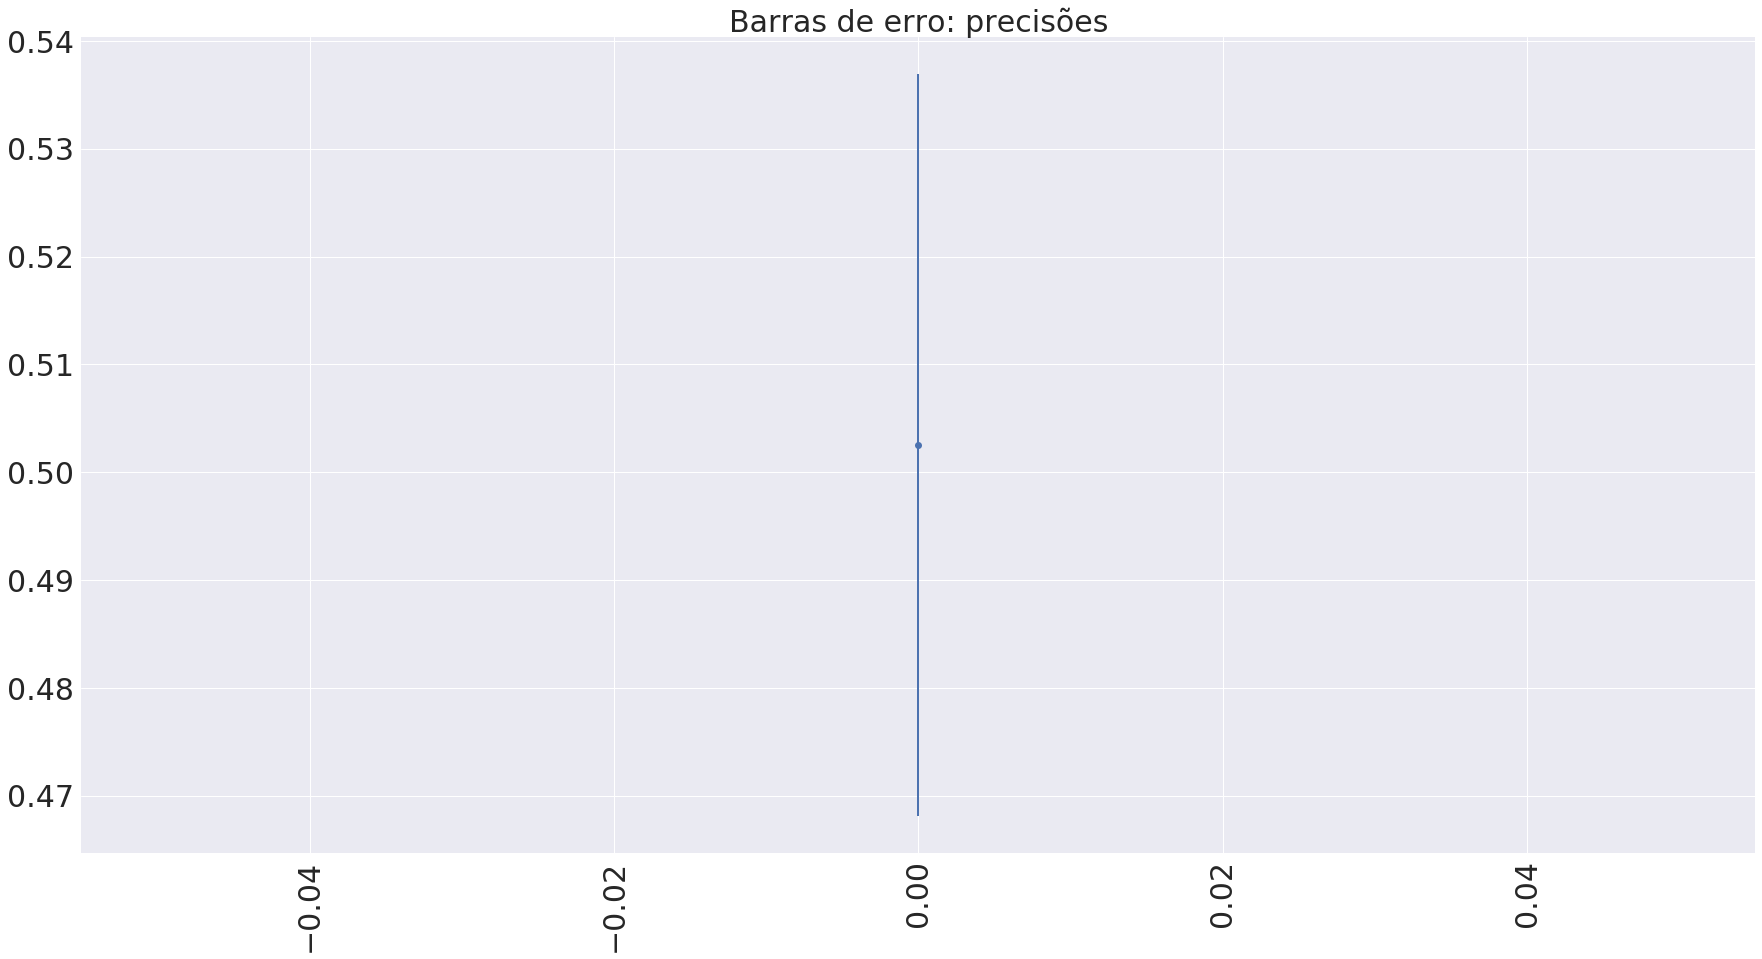

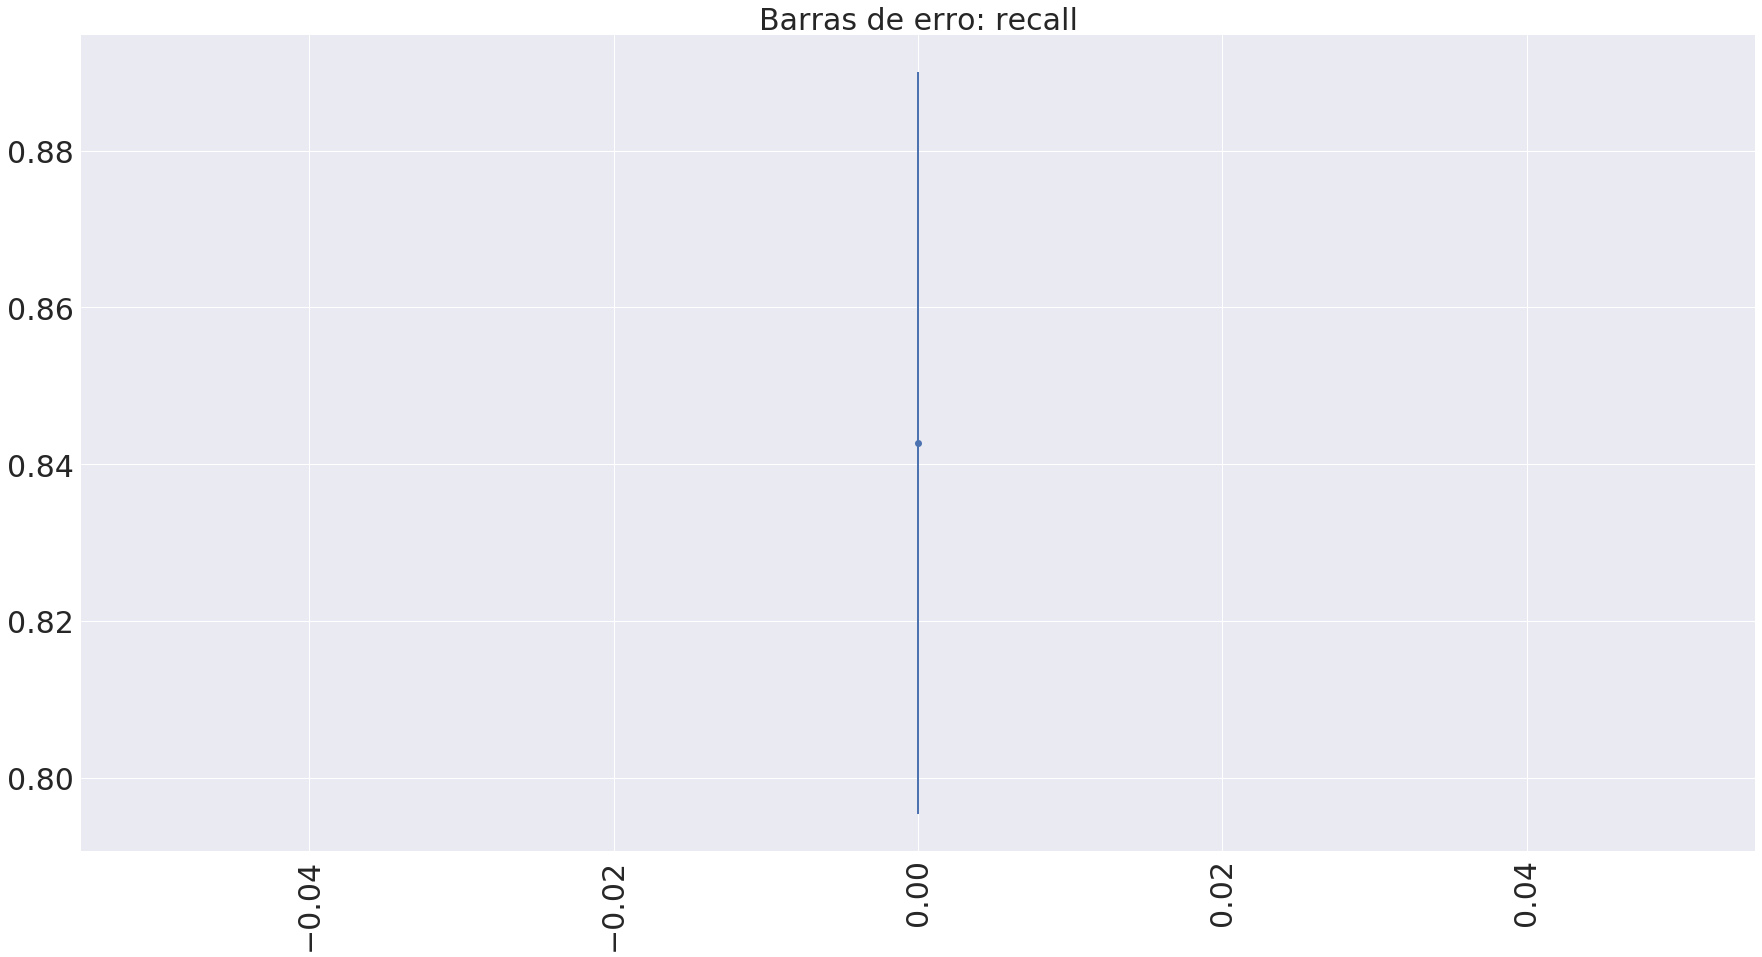

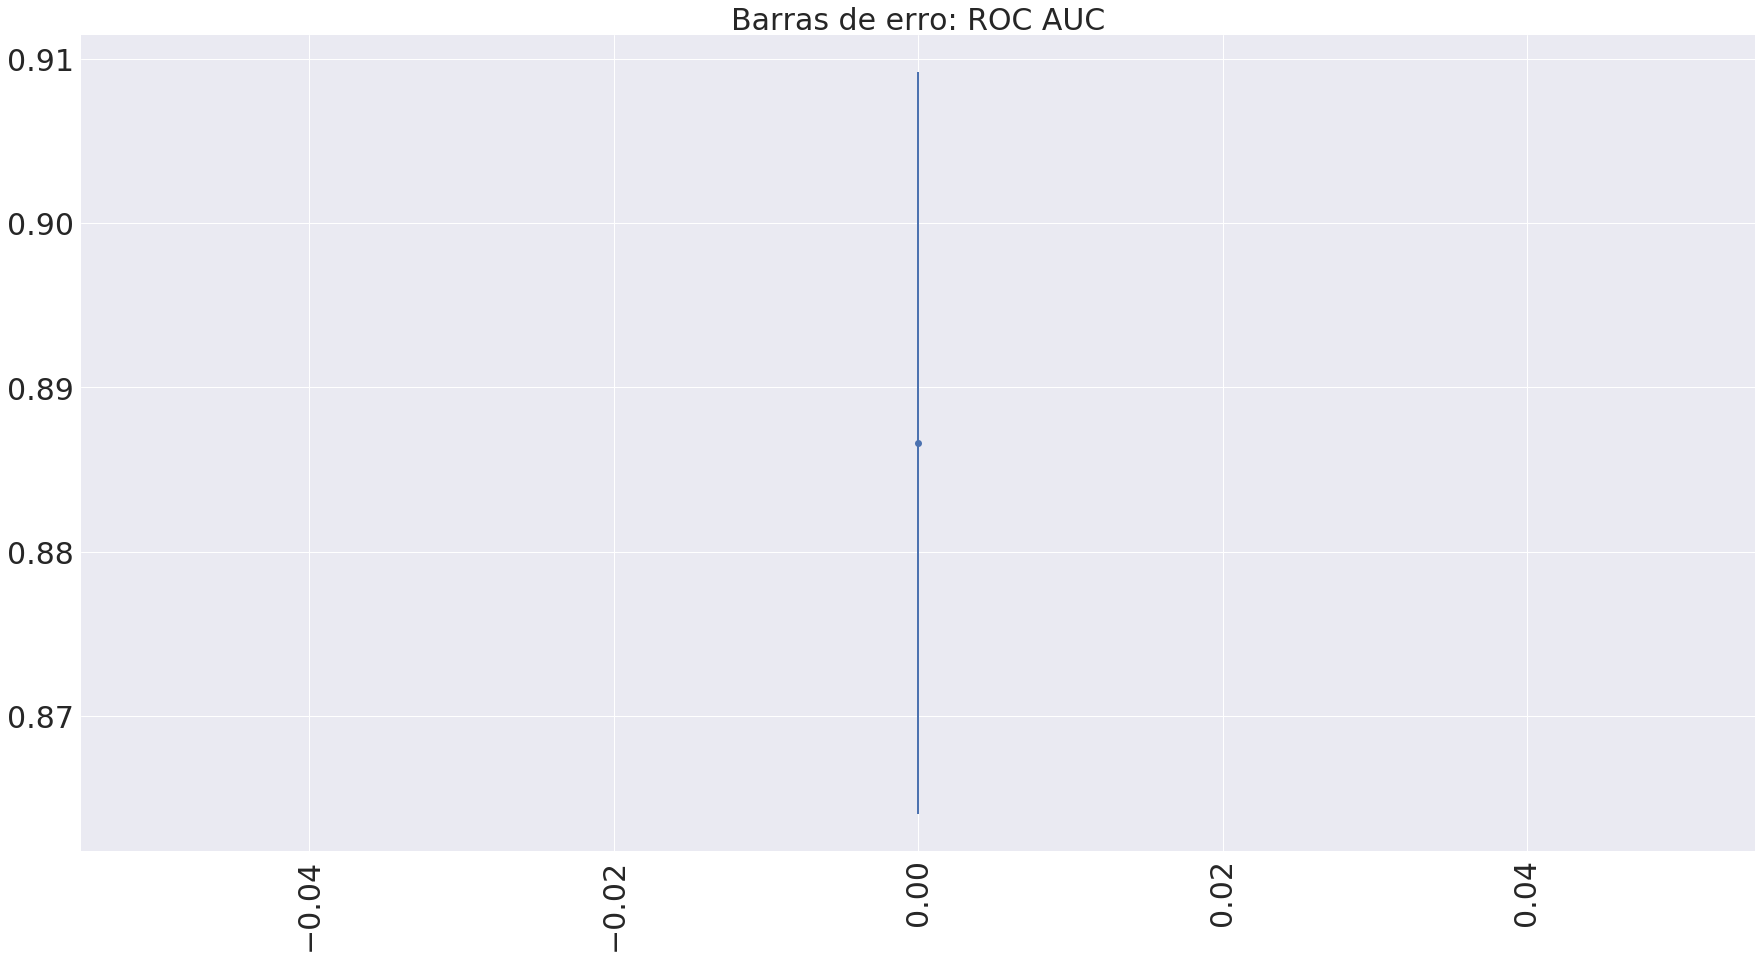

In [24]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_desbalanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_desbalanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

/home/netware/users/gustavomn/.conda/envs/data-mining-coc800/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


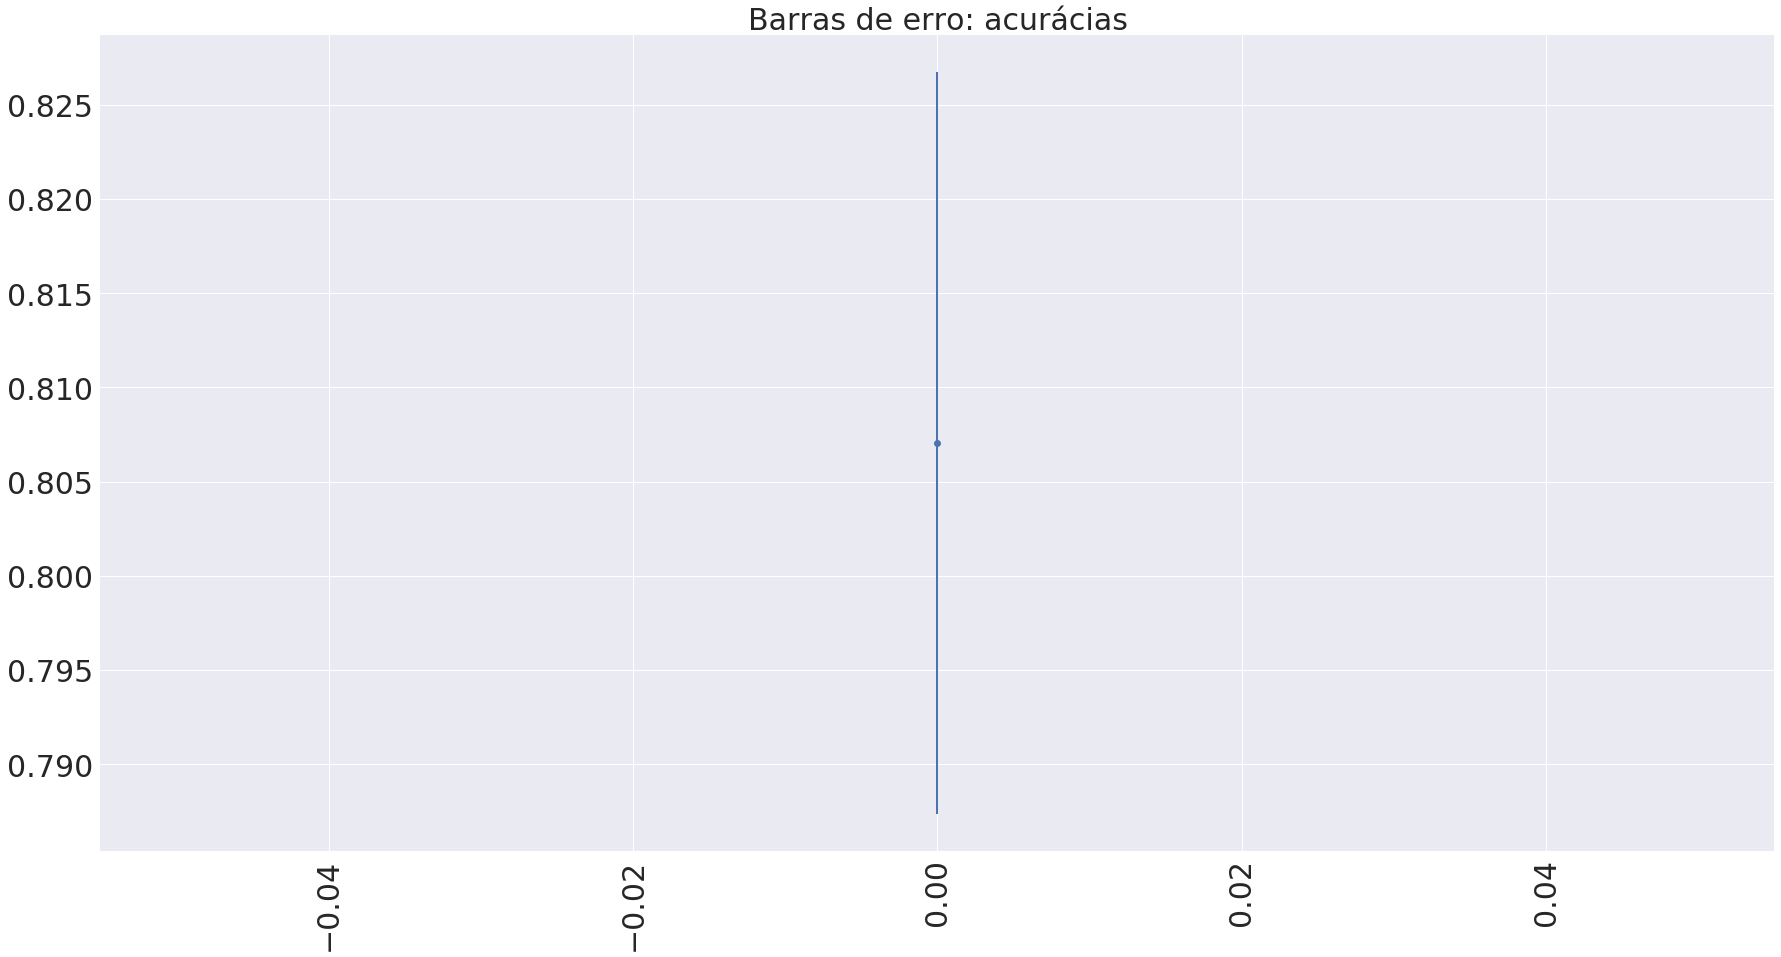

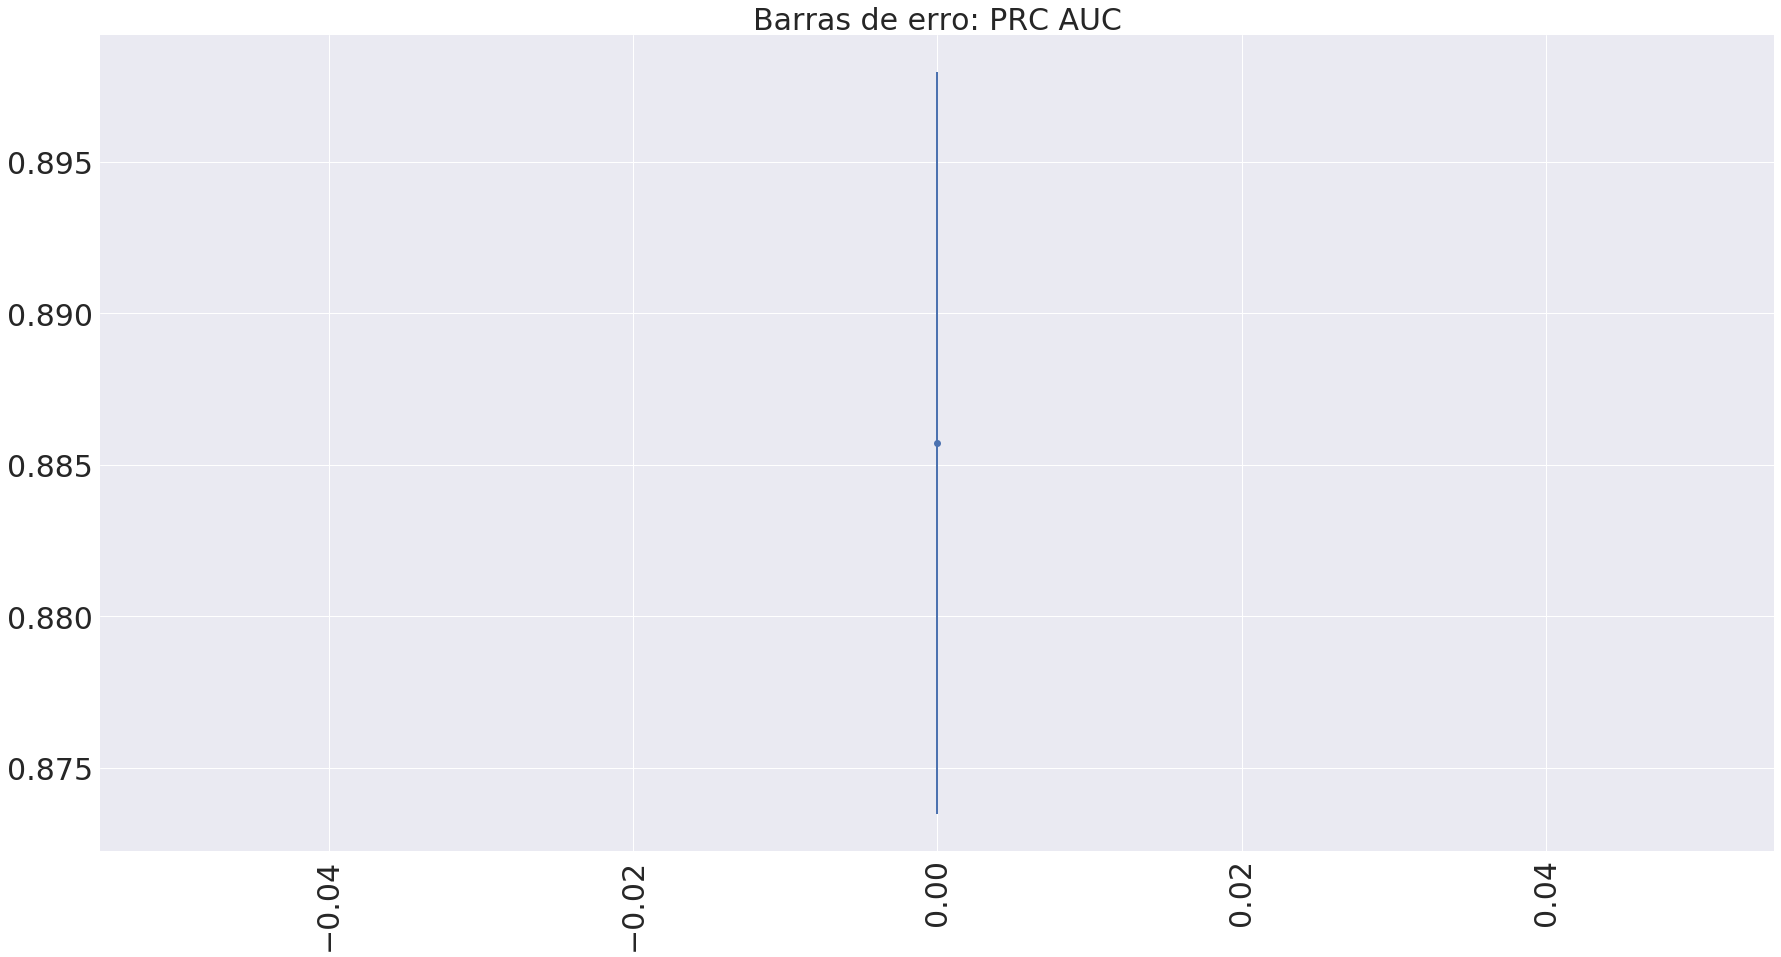

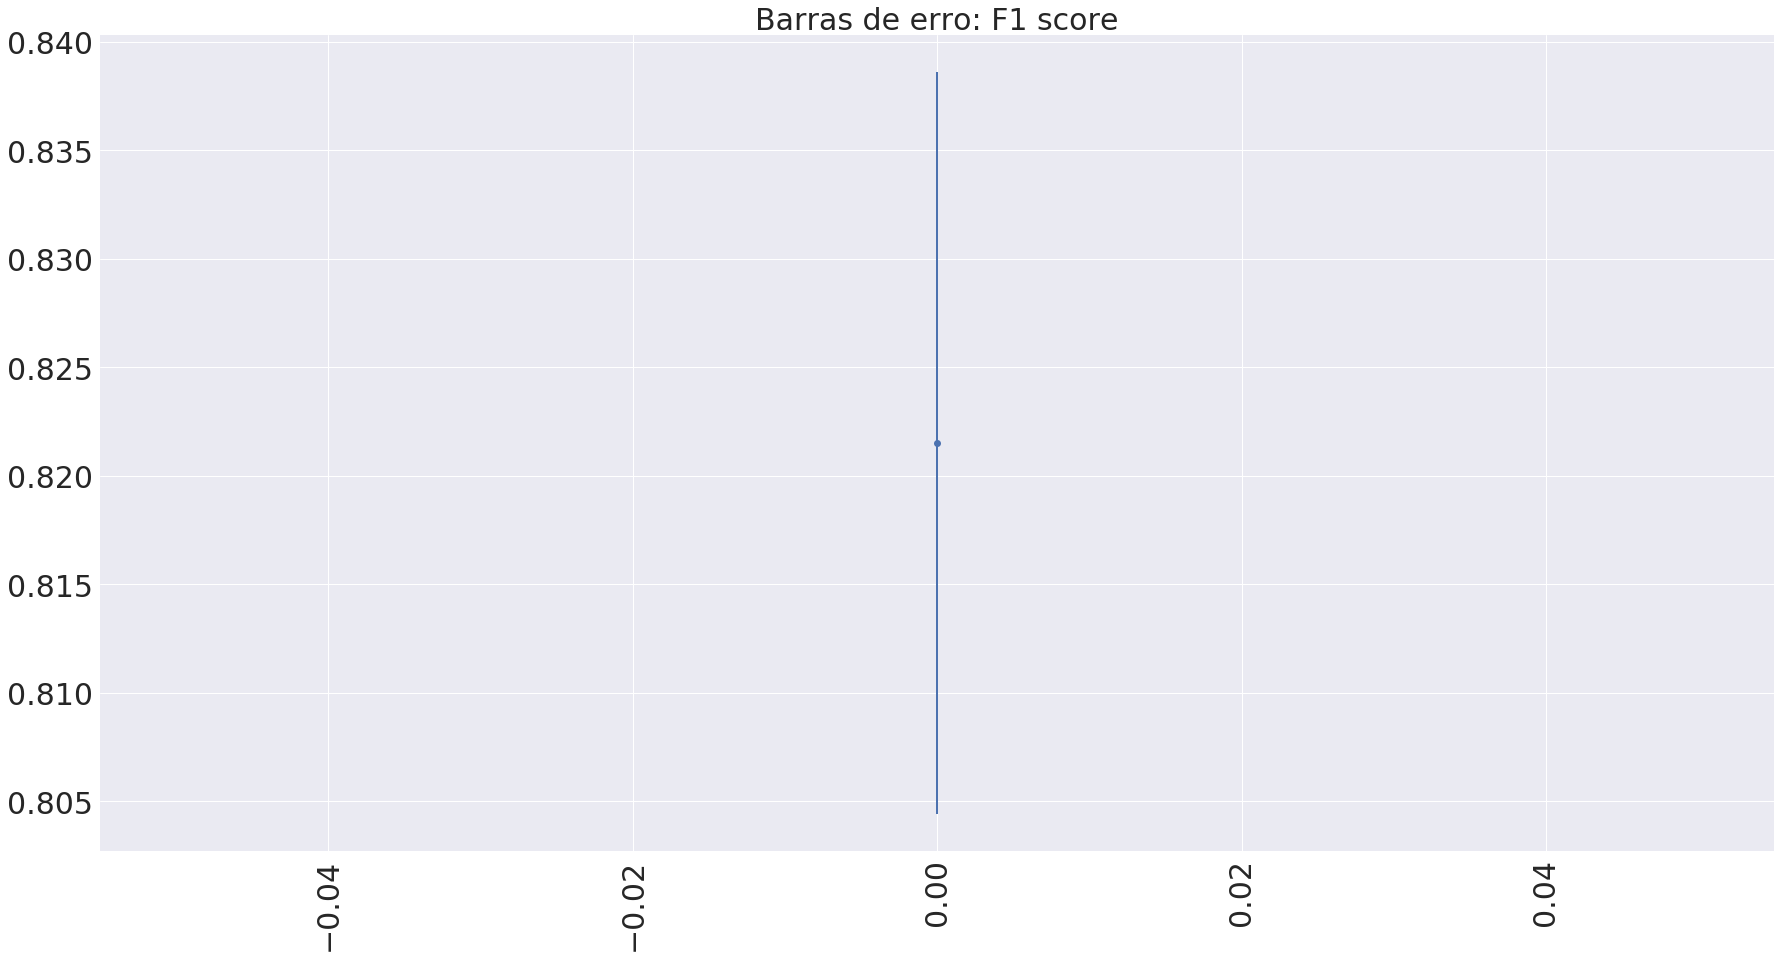

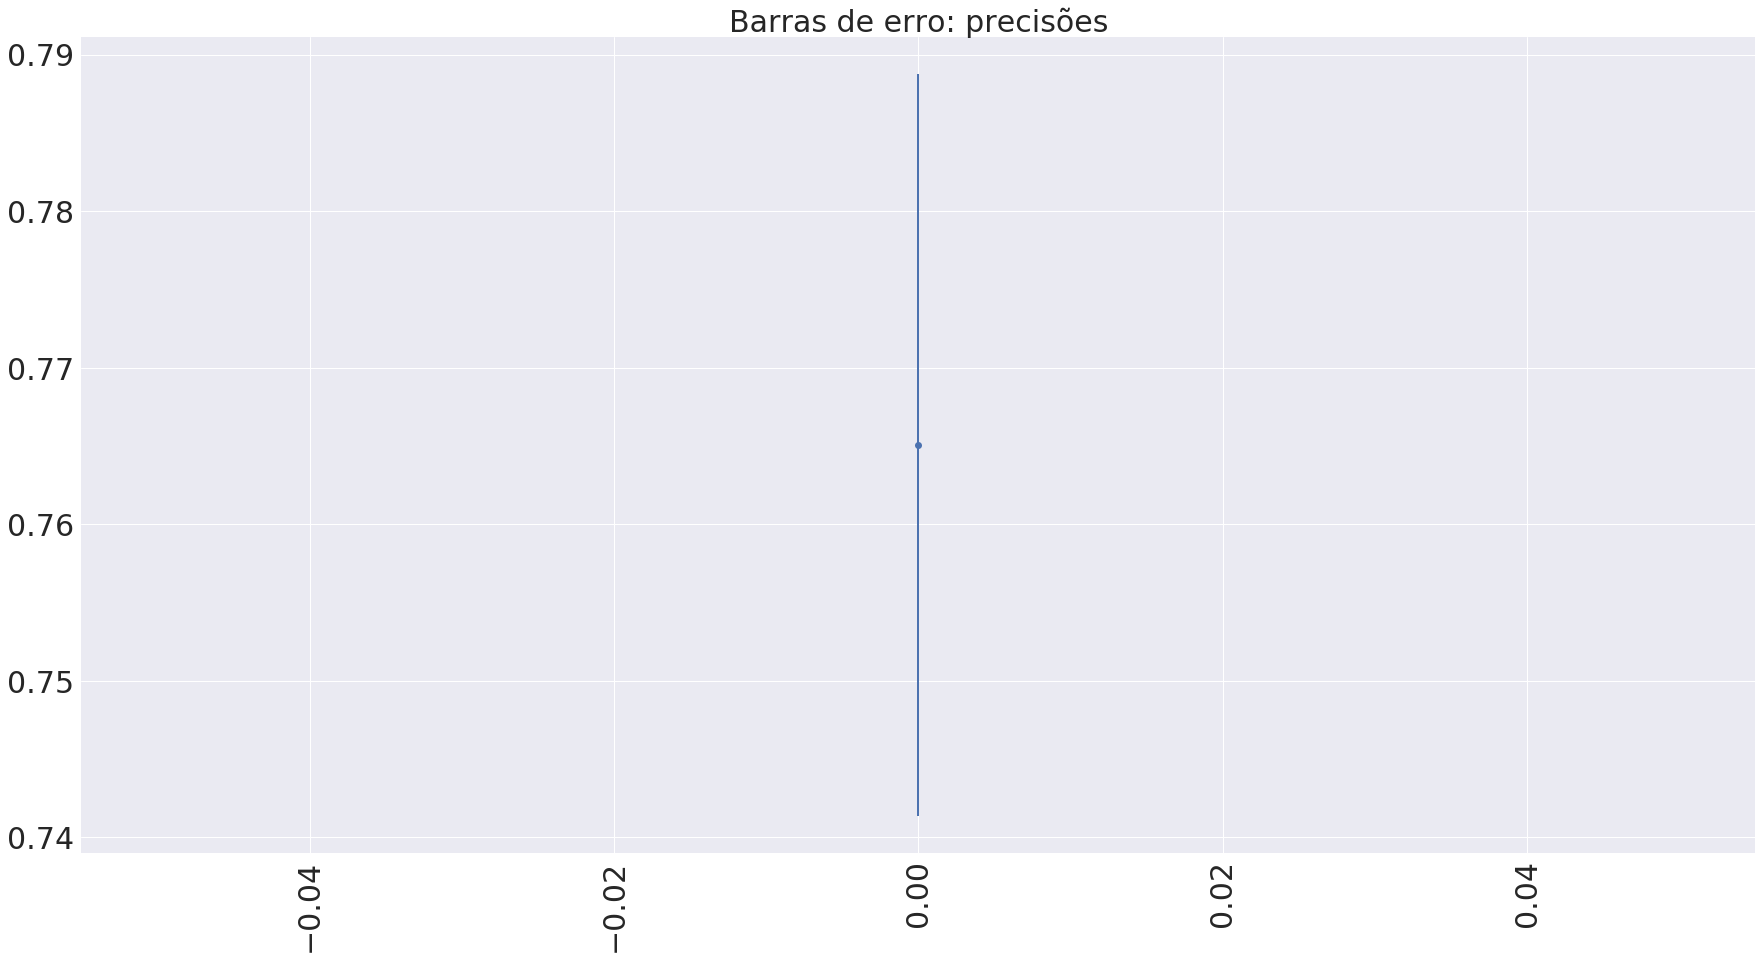

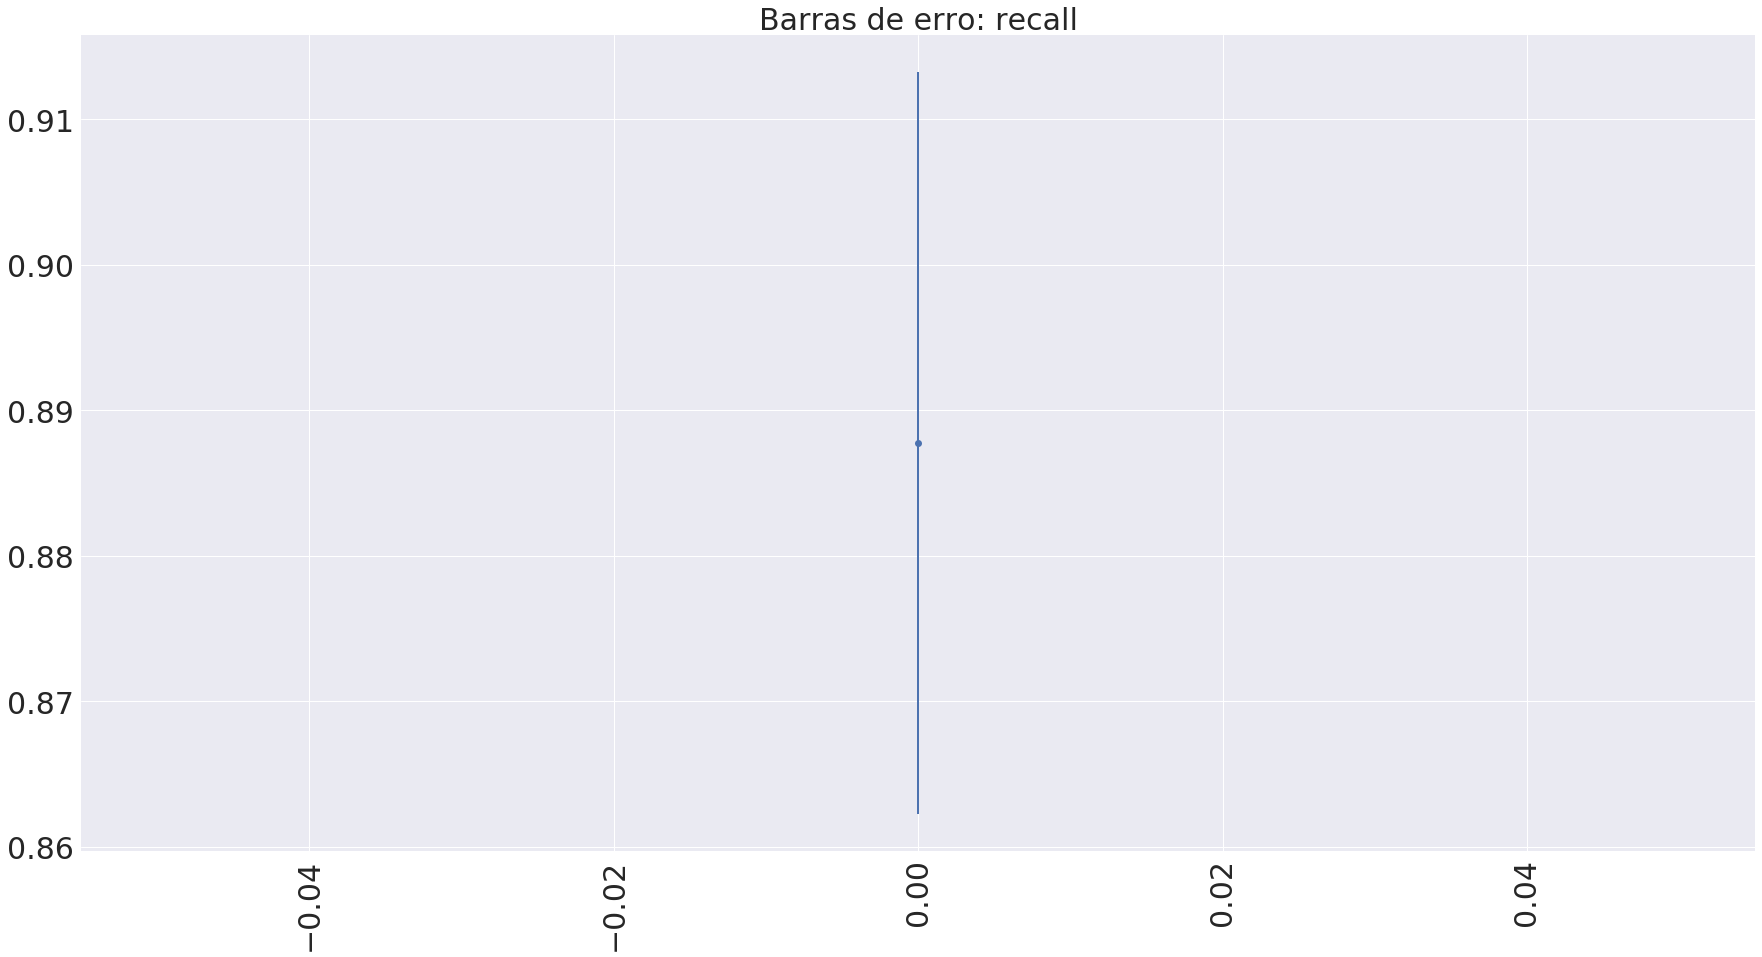

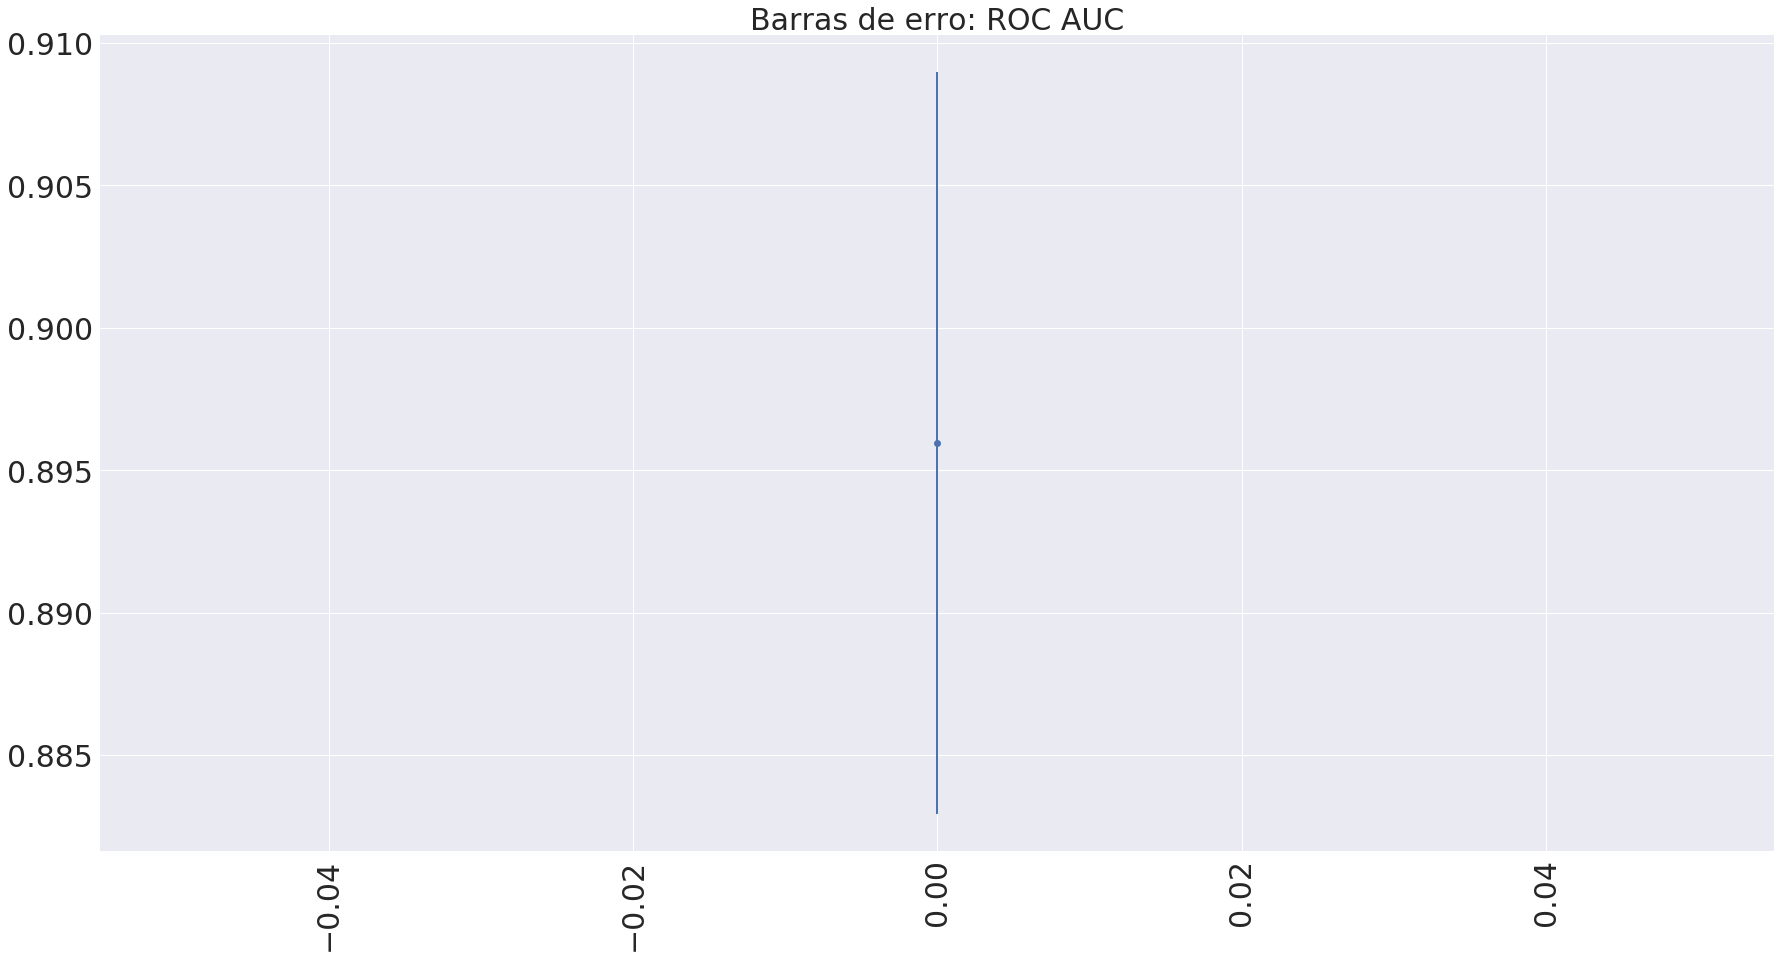

In [25]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_balanceado = joblib.load(path_arquivos+'naive-bayes-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

results = pd.DataFrame(clf_bnb_balanceado.cv_results_)

results_test = results.loc[:, 'split0_test_accuracy':'split9_train_roc_auc']
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('average_precision', 'PRC AUC'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(results_test_filtered.columns, results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    plt.show()

In [26]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Naive-bayes/'

clf_bnb_final = BernoulliNB(alpha=1, binarize=None, fit_prior=True, class_prior=None)

clf_bnb_final.fit(pd.get_dummies(train_data_4), train_target_4)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

clf_bnb_final.fit(pd.get_dummies(train_data_b_4), train_target_b_4)
joblib.dump(clf_bnb_final, 
            path_arquivos+'naive-bayes-final-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada

['Classificadores/Naive-bayes/naive-bayes-final-abordagem-4-balanceado-dataset-10pct.pkl']

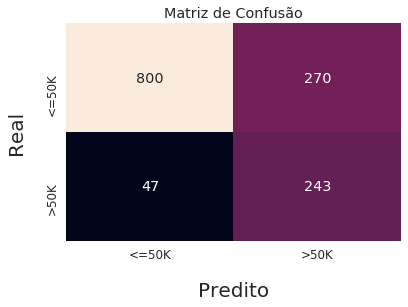

Acurácia: 76.691 %
Precisão: 47.368 %
Recall: 83.793 %
ROC AUC: 79.280 %
PRC AUC: 43.147 %


In [27]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_desbalanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-4-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_desbalanceado, 
                         test_data=pd.get_dummies(test_data_4), 
                         test_target=test_target_4, 
                         id_abordagem=4, 
                         str_balanceamento='desbalanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')

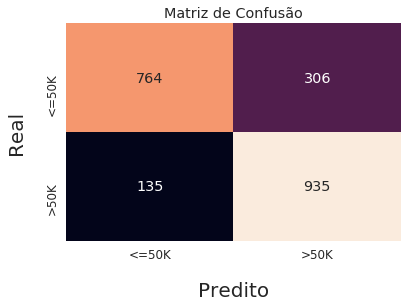

Acurácia: 79.393 %
Precisão: 75.342 %
Recall: 87.383 %
ROC AUC: 79.393 %
PRC AUC: 72.145 %


In [28]:
path_arquivos = 'Classificadores/Naive-bayes/'

clf_balanceado = joblib.load(path_arquivos+'naive-bayes-final-abordagem-4-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')

exibir_resultados_finais(clf=clf_balanceado, 
                         test_data=pd.get_dummies(test_data_b_4), 
                         test_target=test_target_b_4, 
                         id_abordagem=4, 
                         str_balanceamento='balanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='naive-bayes')